Our implementation (no moldicts):

In [1]:
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import chex
import functools
import pandas as pd
import e3nn_jax as e3nn
import posebusters
import sys
import os
import ase
import ase.io
import rdkit.Chem as Chem
import nglview as nv
sys.path.append("..")

/Users/ameyad/Documents/spherical-harmonic-net/.venv/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/ameyad/Documents/spherical-harmonic-net/.venv/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import sys
sys.path.append("..")
from analyses.metrics import *

/Users/ameyad/Documents/spherical-harmonic-net/.venv/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [4]:
models = ["Symphony", "Symphony (UFF relaxed)", "EDM", "EDM (UFF relaxed)", "GSchNet", "GSchNet (UFF relaxed)", "GSphereNet", "GSphereNet (UFF relaxed)"]
colors = sns.color_palette("Paired", n_colors=len(models))
model_palette = {model: color for model, color in zip(models, colors)}
model_palette["QM9"] = "black"
model_palette

{'Symphony': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Symphony (UFF relaxed)': (0.12156862745098039,
  0.47058823529411764,
  0.7058823529411765),
 'EDM': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'EDM (UFF relaxed)': (0.2, 0.6274509803921569, 0.17254901960784313),
 'GSchNet': (0.984313725490196, 0.6039215686274509, 0.6),
 'GSchNet (UFF relaxed)': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745),
 'GSphereNet': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 'GSphereNet (UFF relaxed)': (1.0, 0.4980392156862745, 0.0),
 'QM9': 'black'}

Paths:

In [5]:
generated_paths = {
    "QM9": "/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz",
    "Symphony": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/molecules",
    # "Symphony": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_7SEP/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/molecules",
    "EDM": "/Users/ameyad/Documents/spherical-harmonic-net/others/edm/samples_edm_xyz",
    "GSchNet": "/Users/ameyad/Documents/spherical-harmonic-net/others/gschnet/molecules",
    "GSphereNet": "/Users/ameyad/Documents/spherical-harmonic-net/others/gspherenet/molecules",
}

generated_and_relaxed_paths = {
    **generated_paths,
    "Symphony (UFF relaxed)": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/relaxed_molecules",
    "EDM (UFF relaxed)": "/Users/ameyad/Documents/spherical-harmonic-net/others/edm/samples_edm_relaxed",
    "GSchNet (UFF relaxed)": "/Users/ameyad/Documents/spherical-harmonic-net/others/gschnet/relaxed_molecules",
    "GSphereNet (UFF relaxed)": "/Users/ameyad/Documents/spherical-harmonic-net/others/gspherenet/relaxed_molecules",
}

Corresponding molecules:

In [6]:
all_generated_molecules = {
    model: get_all_molecules(path) for model, path in generated_paths.items()
}

valid_molecules = {
    model: get_all_valid_molecules(molecules) for model, molecules in all_generated_molecules.items()
}

[19:02:48] Conflicting single bond directions around double bond at index 1.
[19:02:48]   BondStereo set to STEREONONE and single bond directions set to NONE.


Number of Atoms Per Molecule

In [7]:
molecule_sizes = {
    model: compute_molecule_sizes(molecules) for model, molecules in valid_molecules.items()
}

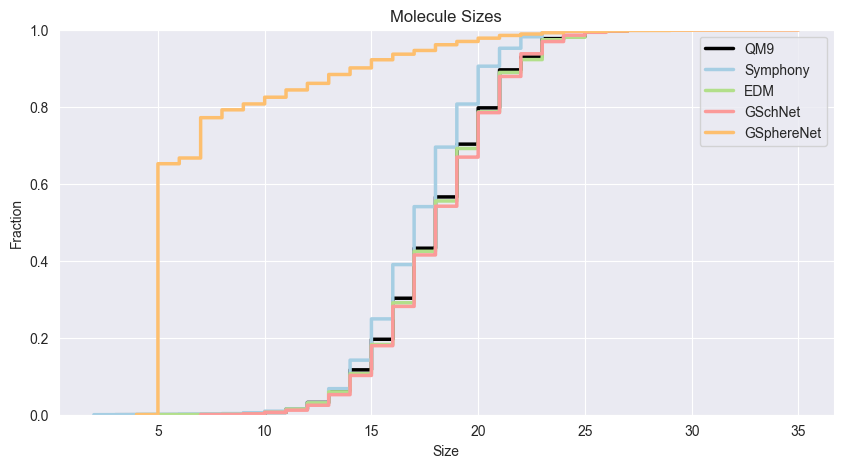

In [8]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
for model in molecule_sizes:
    sns.ecdfplot(data=molecule_sizes[model], label=model, color=model_palette[model], linewidth=2.5, ax=ax)
plt.title(f"Molecule Sizes")
plt.legend()
plt.xlabel("Size")
plt.ylabel("Fraction")
plt.show()

Atom type counts!

In [9]:
atom_type_counts = {
    model: count_atom_types(molecules, normalize=True) for model, molecules in valid_molecules.items()
}

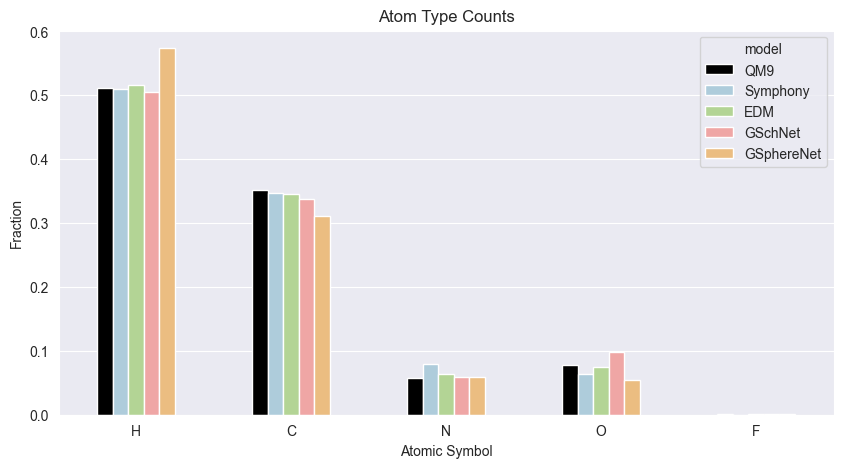

In [10]:
# Make a dataframe of all molecule sizes.
def make_atom_type_counts_df() -> pd.DataFrame:
    atom_types = ['H', 'C', 'N', 'O', 'F']
    df = pd.DataFrame(columns=["model", "atom_type", "count"])
    for model in atom_type_counts:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "atom_type": atom_type,
                        "count": atom_type_counts[model].get(atom_type, 0),
                    }
                    for atom_type in atom_types
                ),
            ],
            ignore_index=True,
        )
    return df

atom_type_counts_df = make_atom_type_counts_df()
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=atom_type_counts_df, x="atom_type", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
plt.title(f"Atom Type Counts")
plt.xlabel("Atomic Symbol")
plt.ylabel("Fraction")
plt.show()

Local environments:

In [11]:
local_environments = {
    model: compute_local_environments(molecules, max_num_molecules=1000)
    for model, molecules in valid_molecules.items()
}

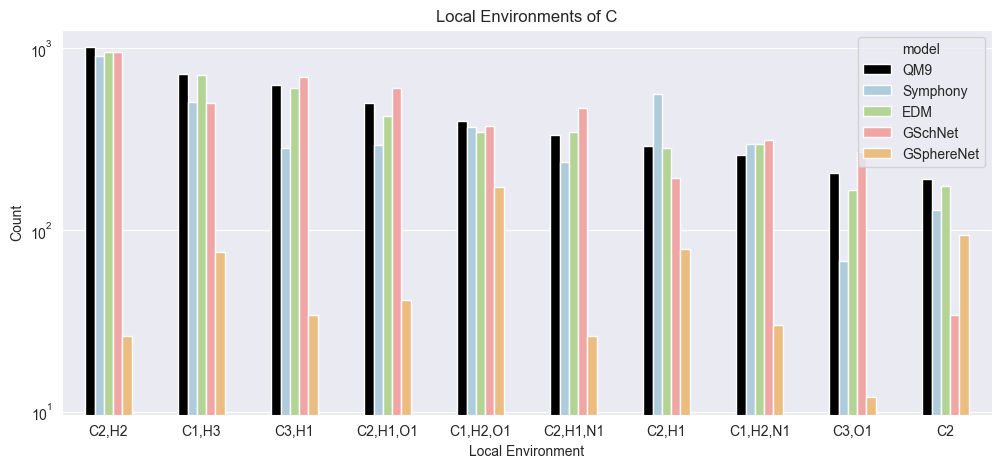

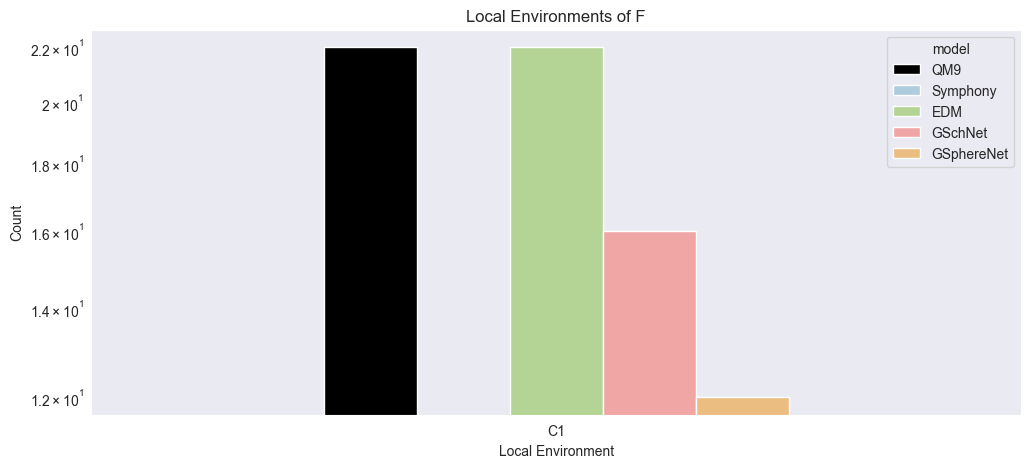

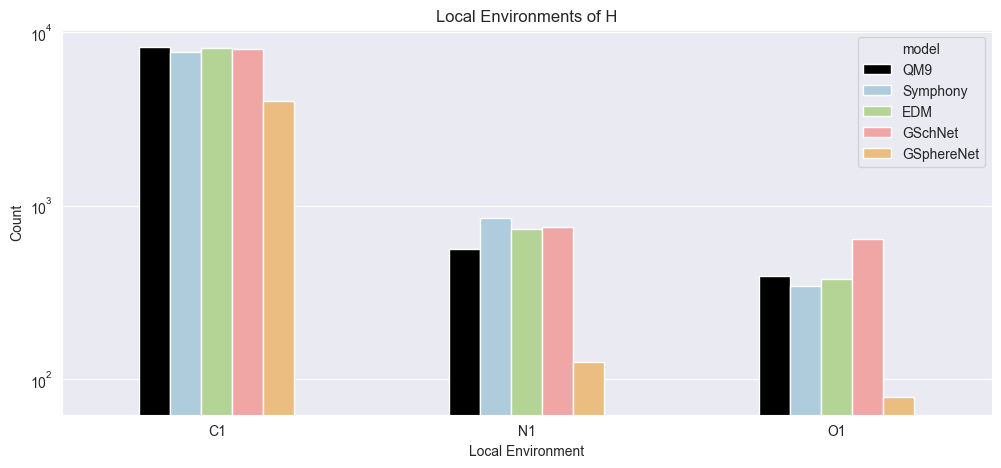

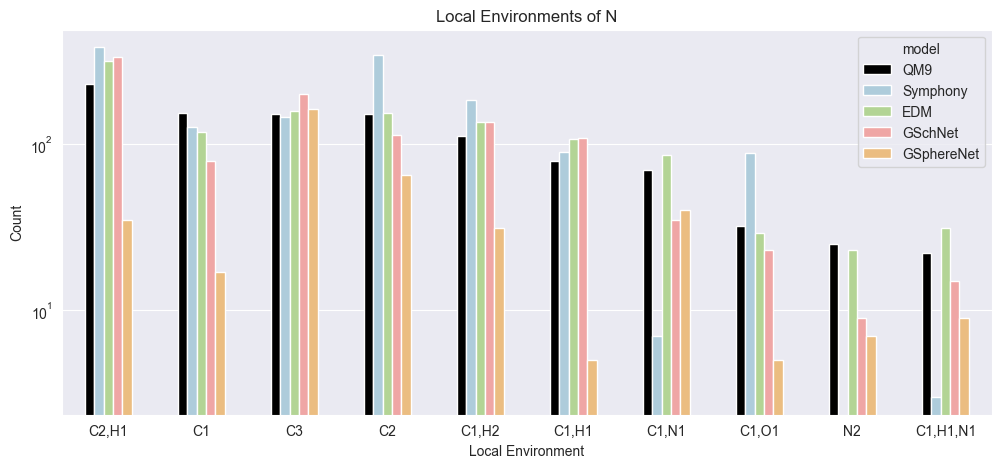

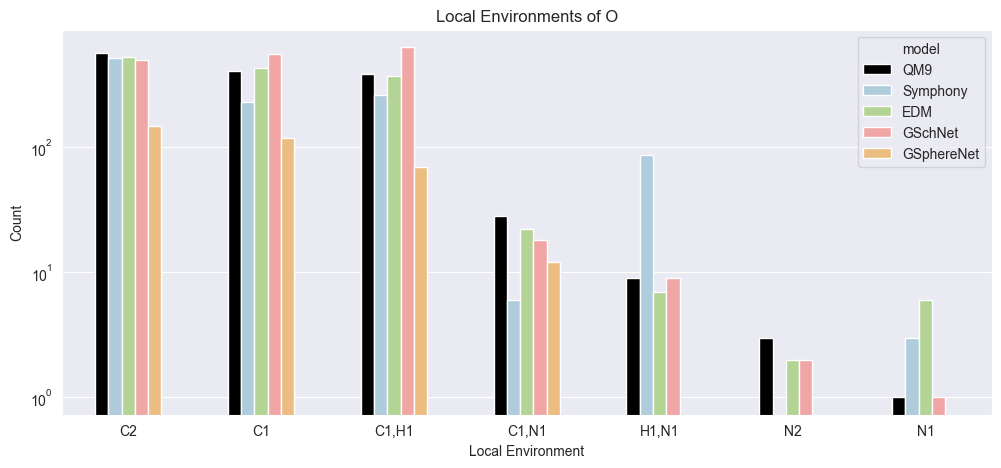

In [12]:
def make_local_environments_dataframe(central_atom_type: str, max_unique_environments: int) -> pd.DataFrame:
    """Make a dataframe of counts for each of QM9, Symphony and EDM."""
    neighbors = dict(sorted(local_environments["QM9"][central_atom_type].items(), key=lambda x: x[1], reverse=True)[:max_unique_environments])
    df = pd.DataFrame(columns=["model", "neighbors", "count"])
    for model in generated_paths:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "neighbors": neighbor,
                        "count": local_environments[model].get(central_atom_type, {}).get(neighbor, 0),
                    }
                    for neighbor in neighbors
                ),
            ],
            ignore_index=True,
        )
    return df


for central_atom_type in sorted(local_environments["QM9"]):
    local_environments_df = make_local_environments_dataframe(central_atom_type, max_unique_environments=10)

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(data=local_environments_df, x="neighbors", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
    plt.title(f"Local Environments of {central_atom_type}")
    plt.xlabel("Local Environment")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.show()

Bispectra of local environments:

In [13]:
lmax = 4
max_num_molecules = 1000

bispectra = {
    model: compute_bispectra_of_local_environments(molecules, lmax, max_num_molecules)
    for model, molecules in valid_molecules.items()
}

1000it [01:38, 10.11it/s]
1000it [01:26, 11.57it/s]
1000it [01:34, 10.61it/s]
1000it [01:39, 10.05it/s]
1000it [00:34, 28.96it/s]


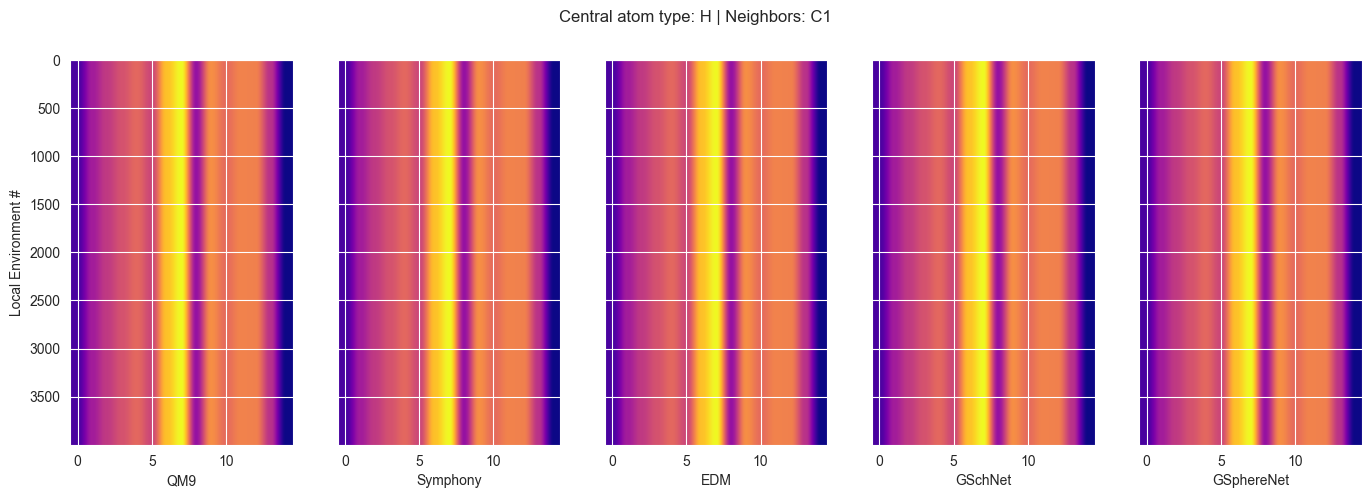

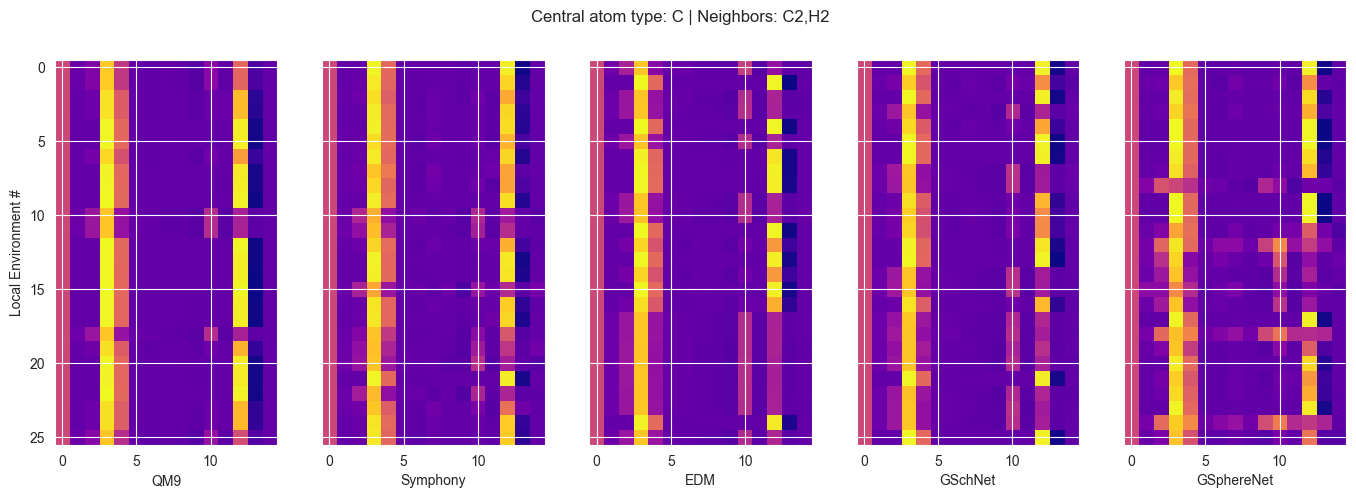

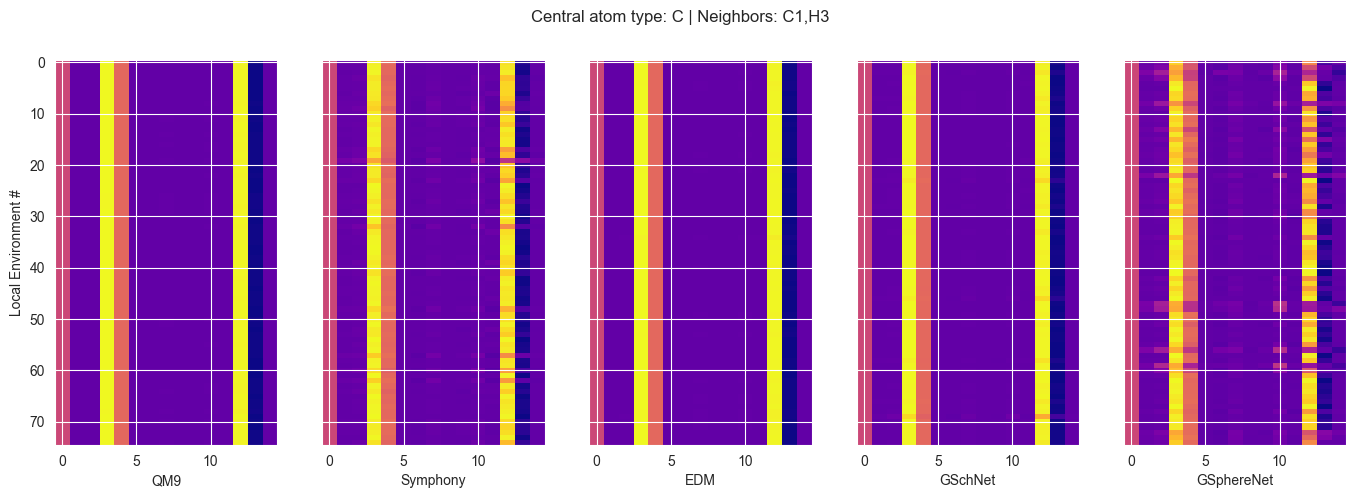

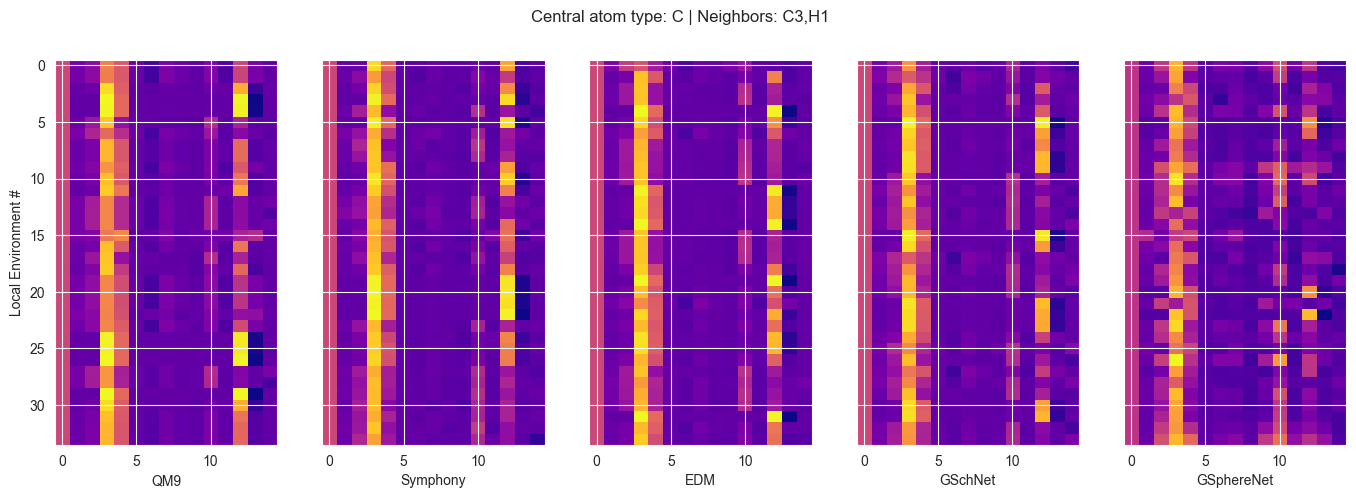

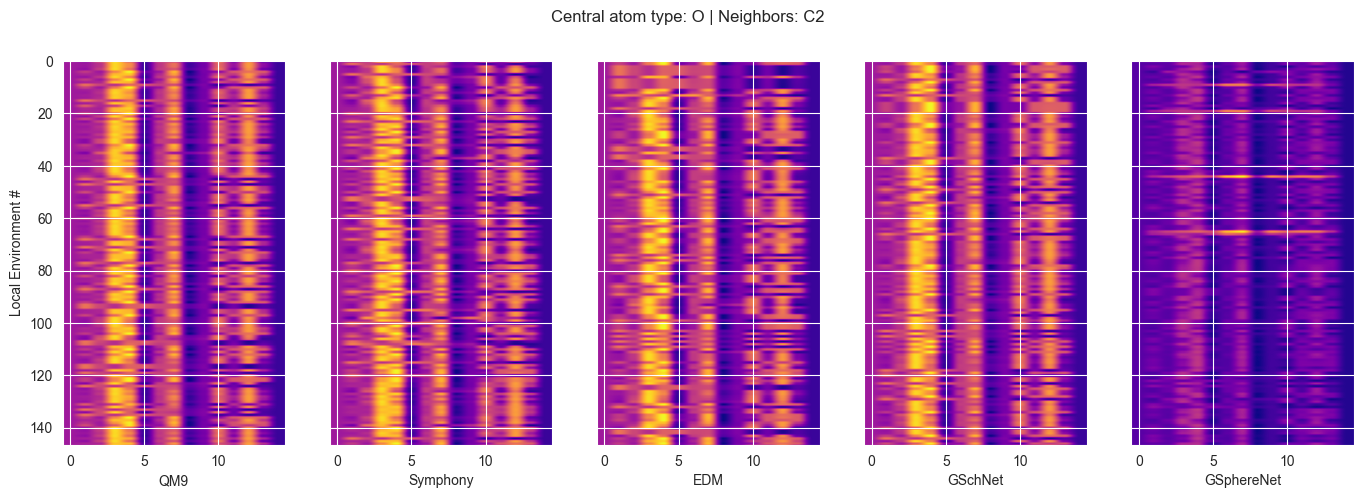

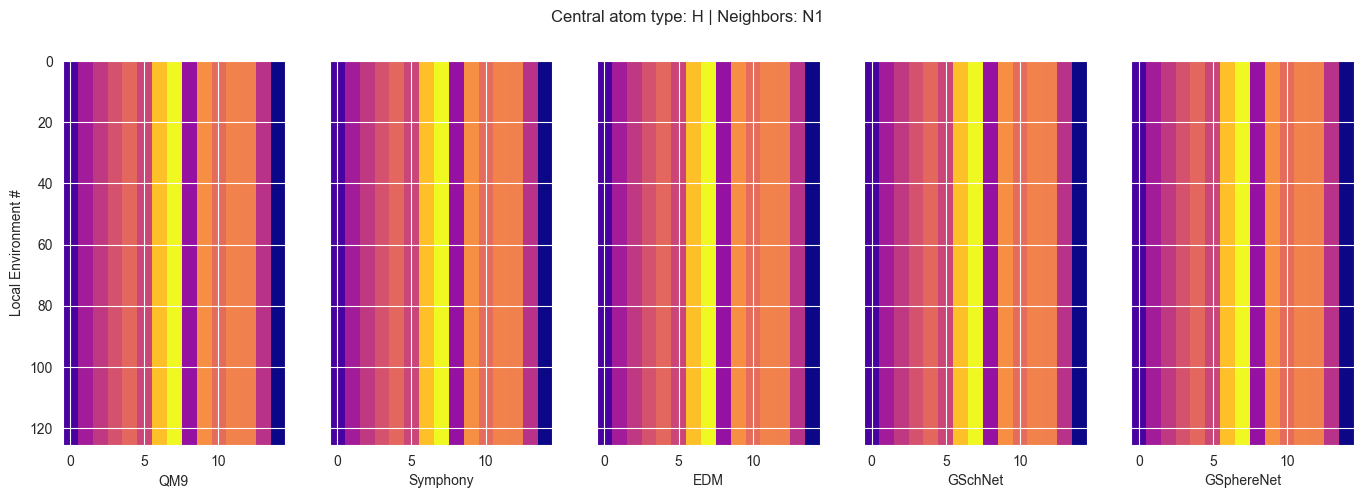

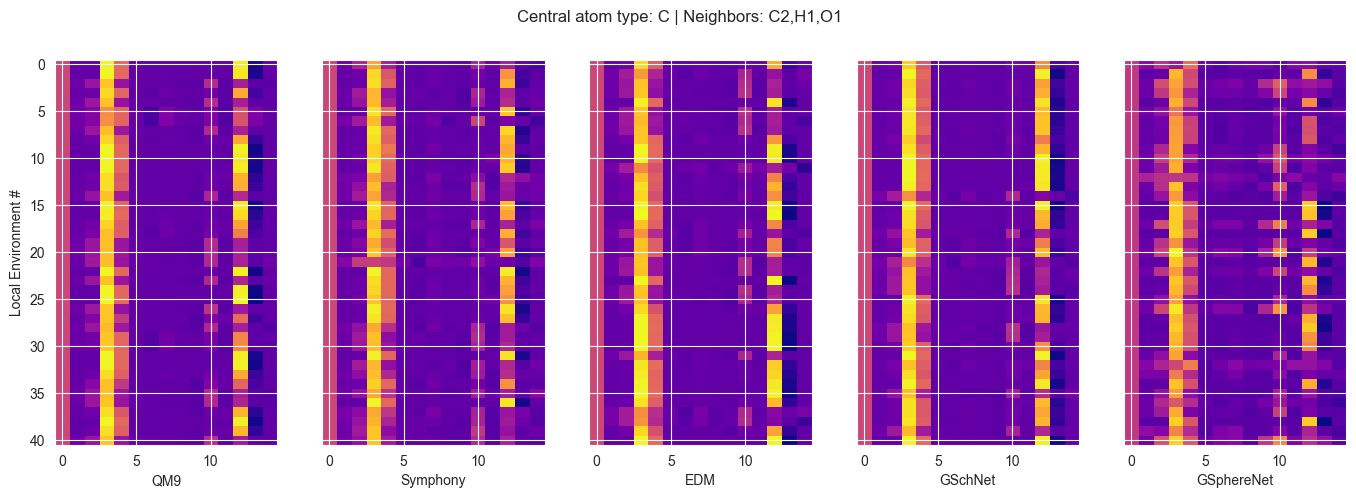

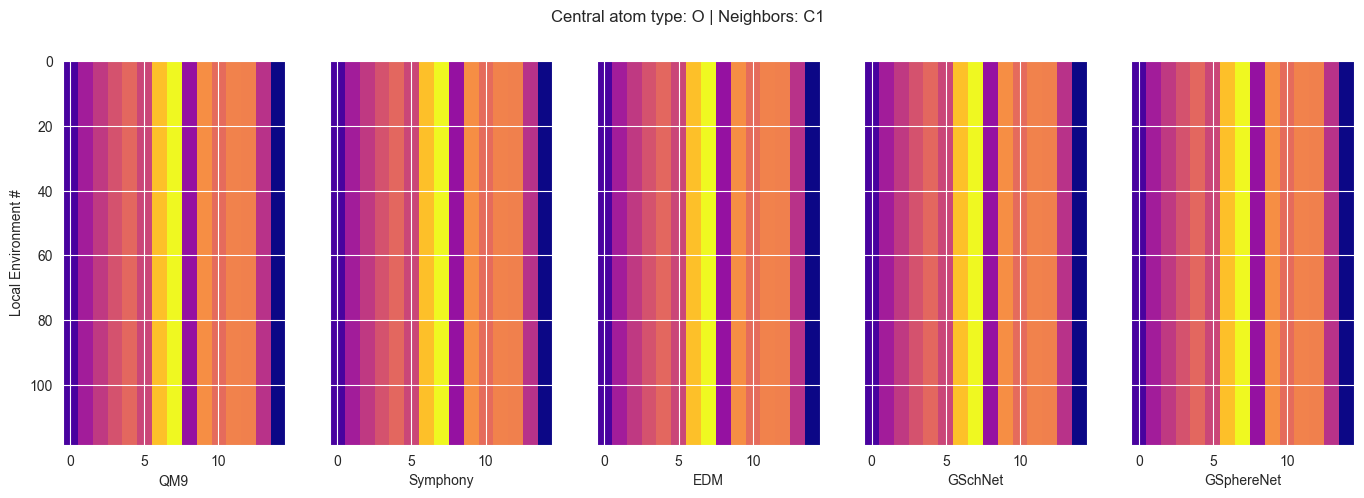

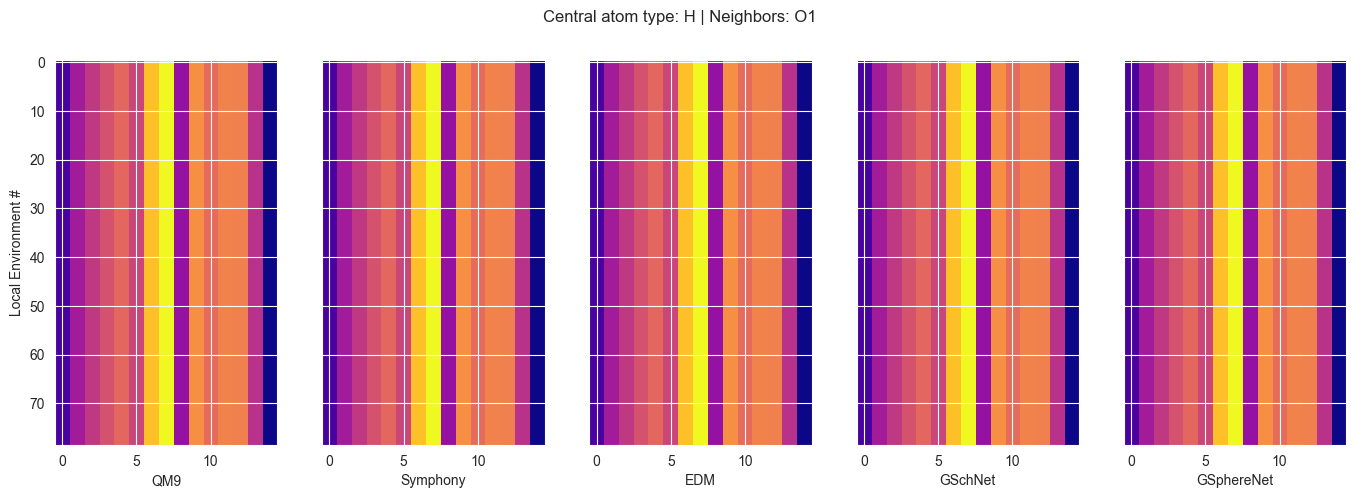

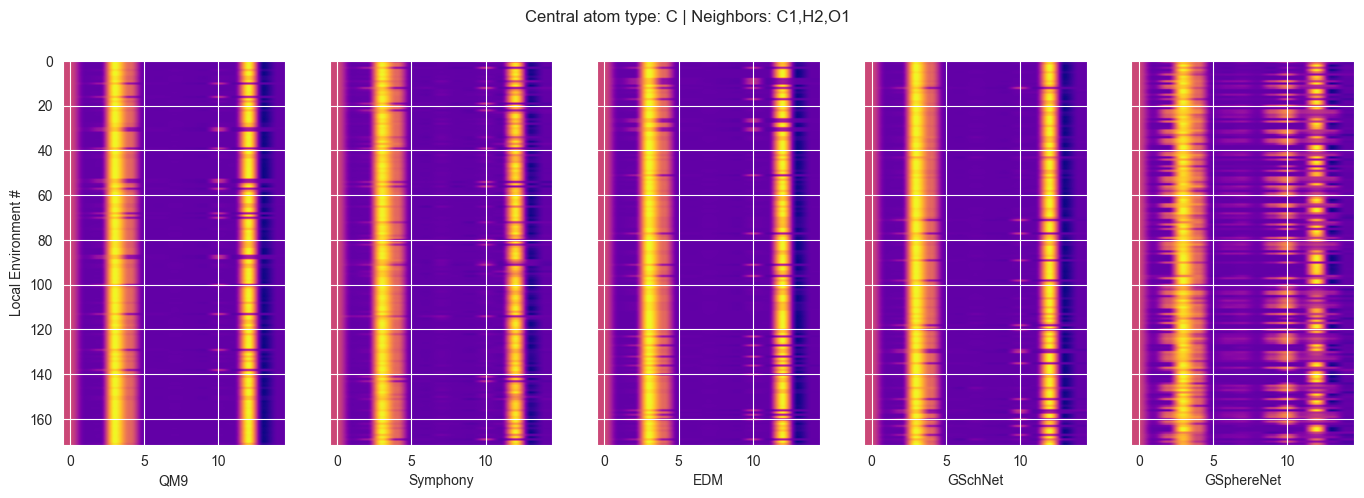

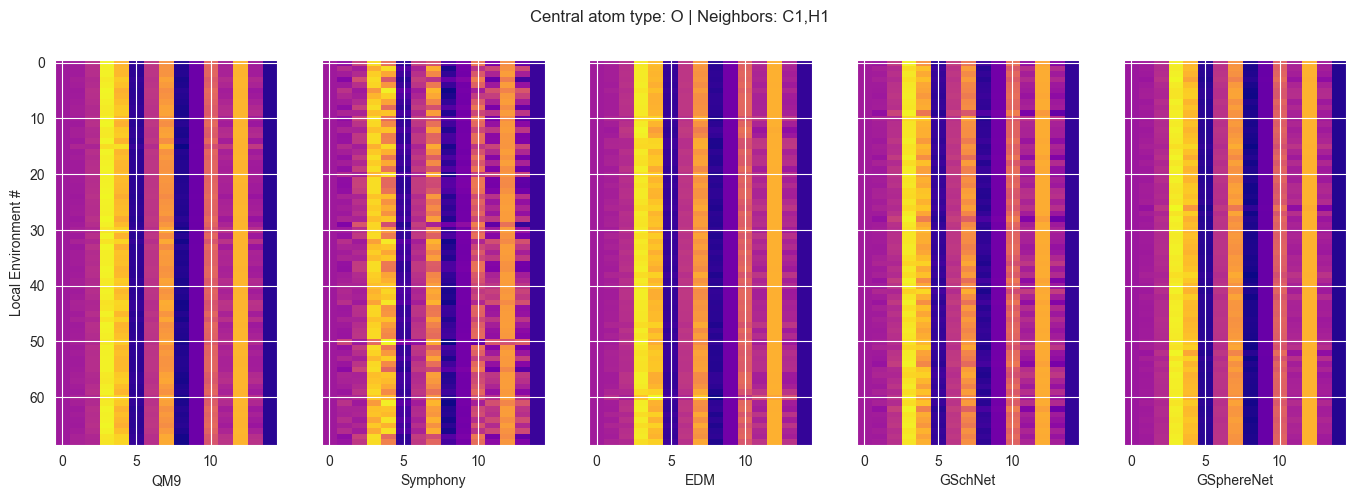

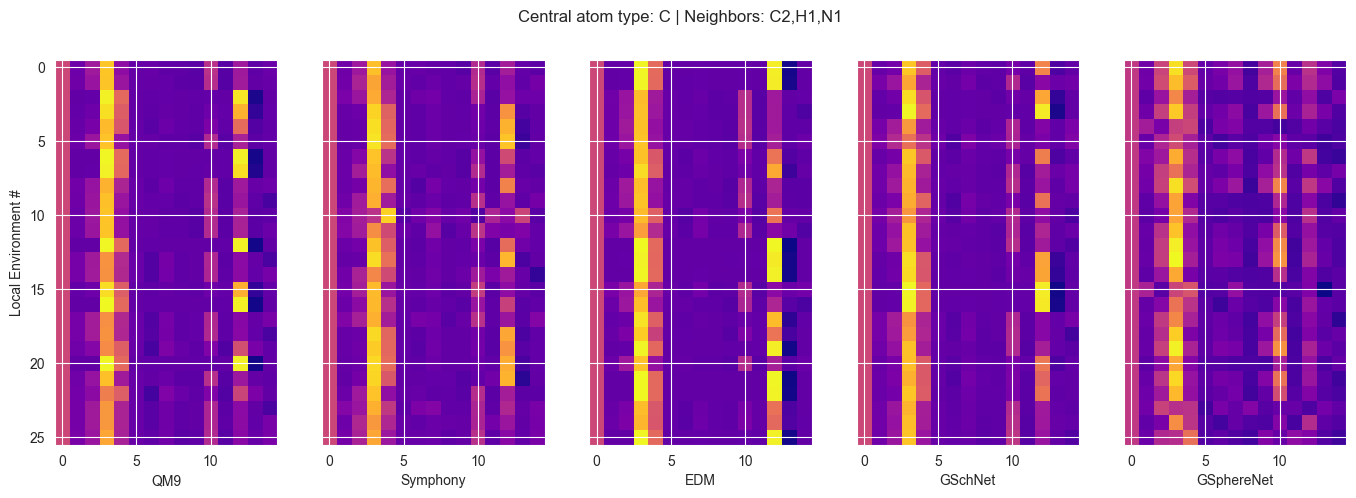

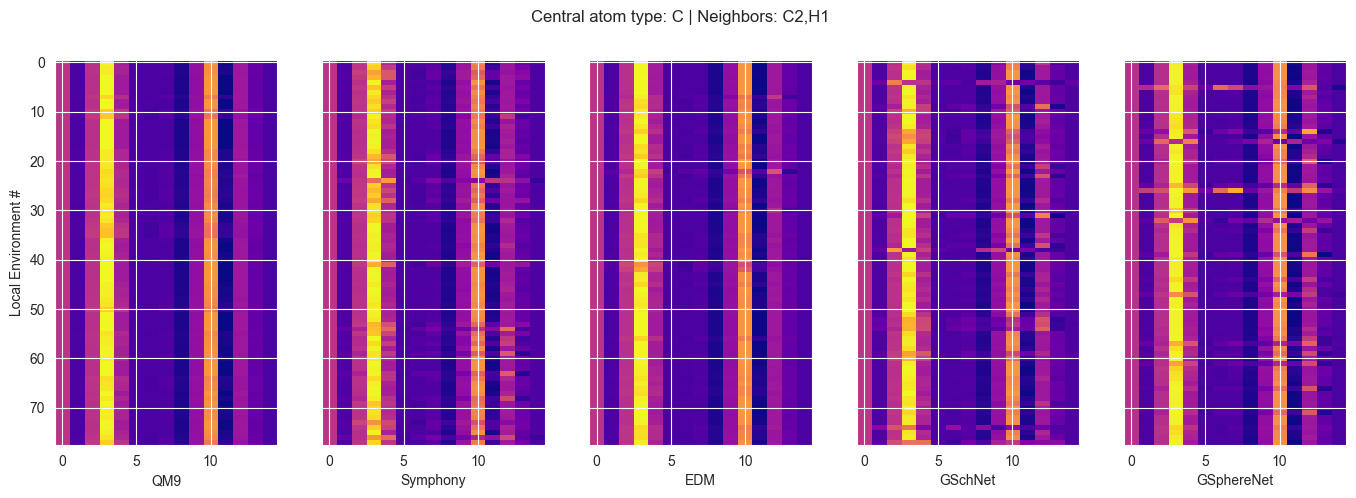

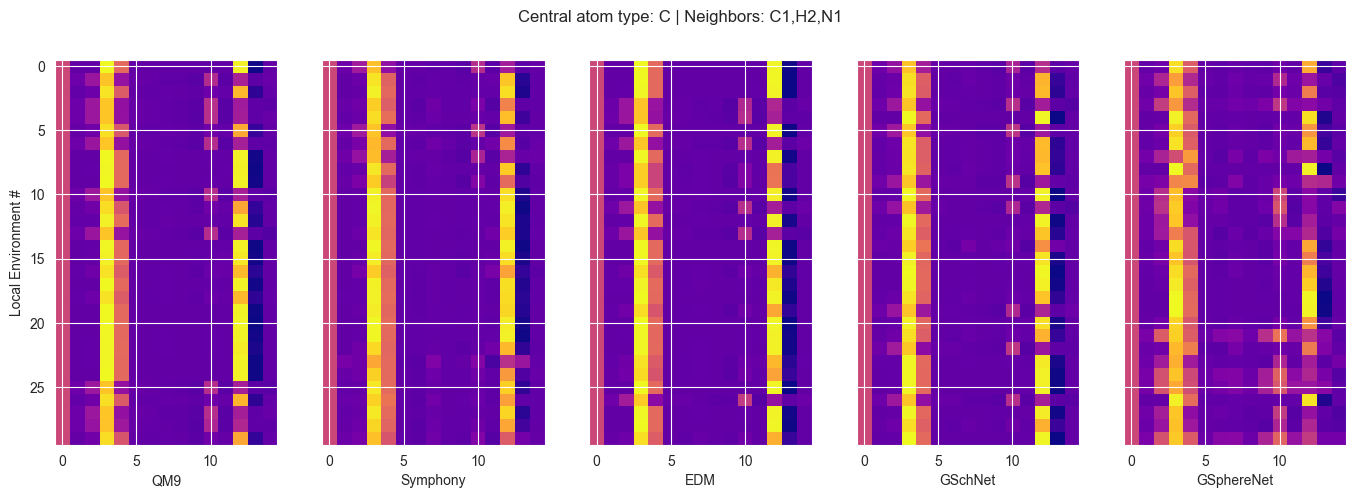

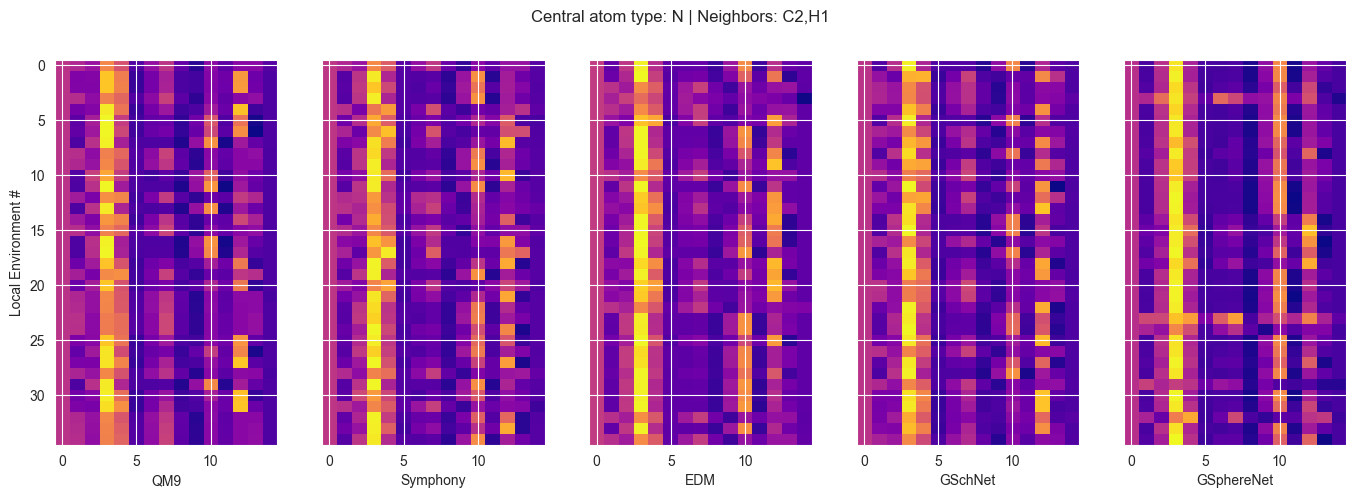

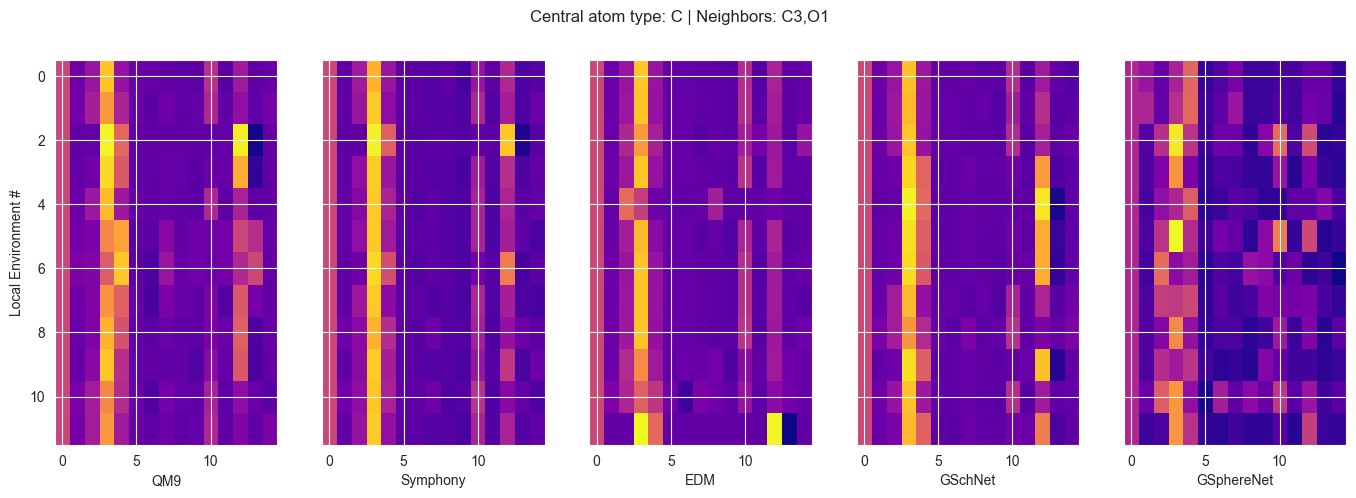

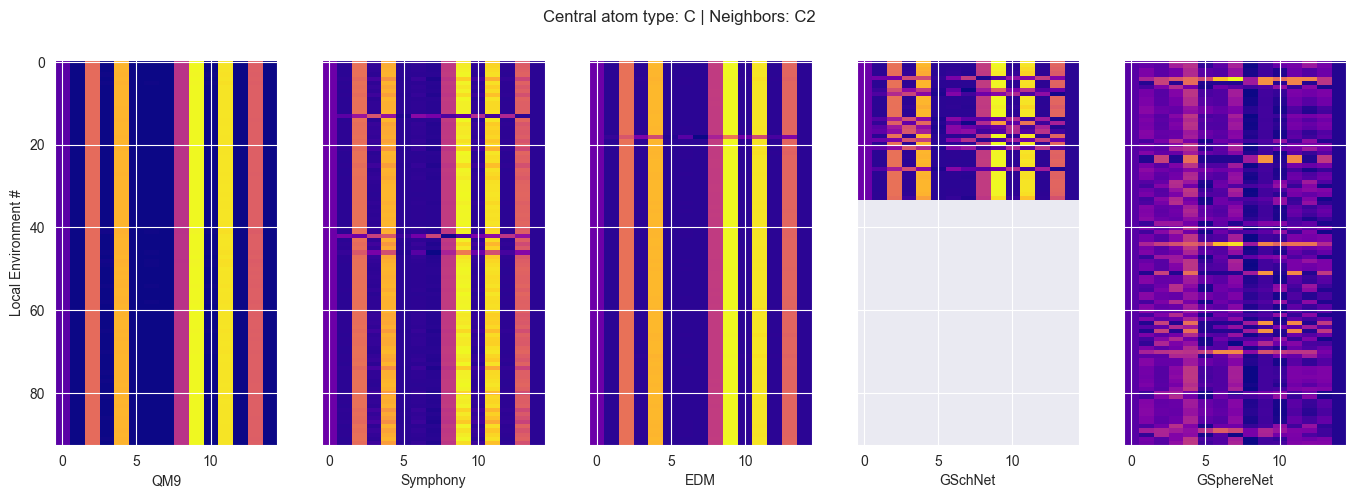

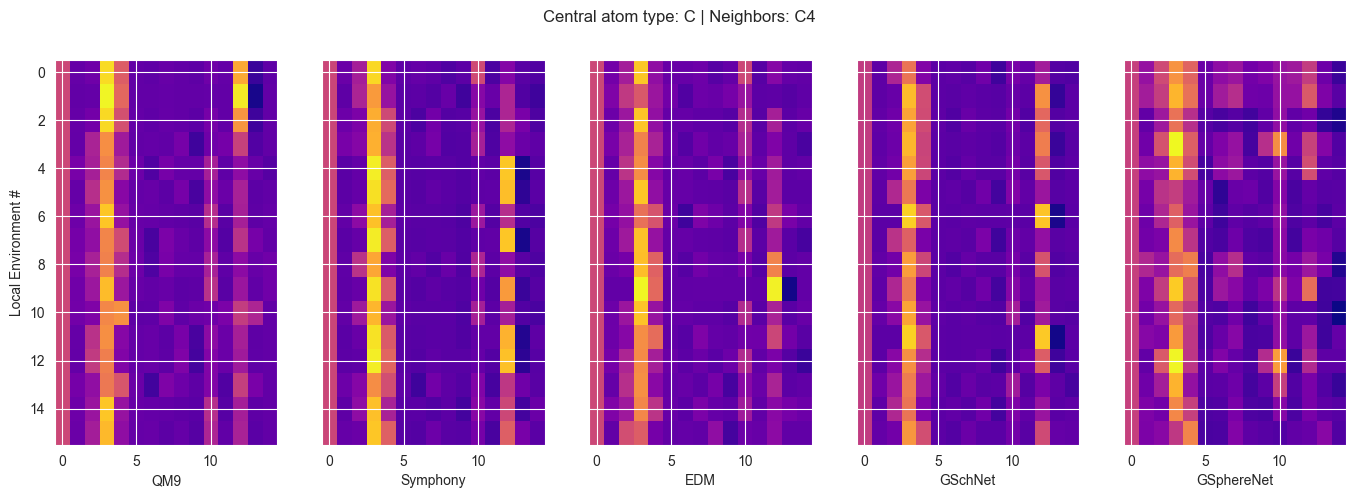

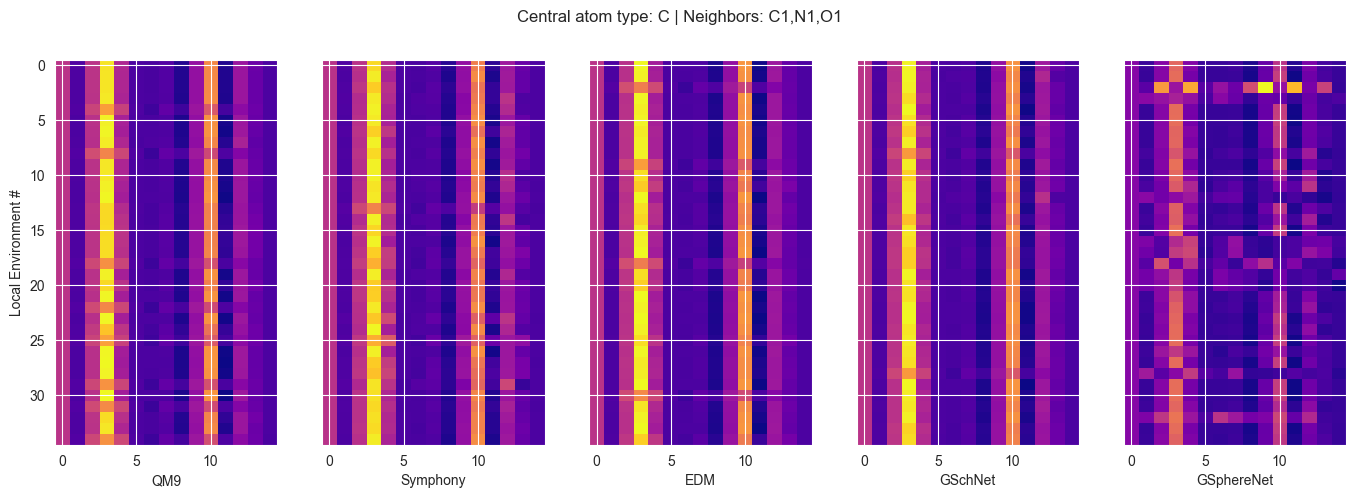

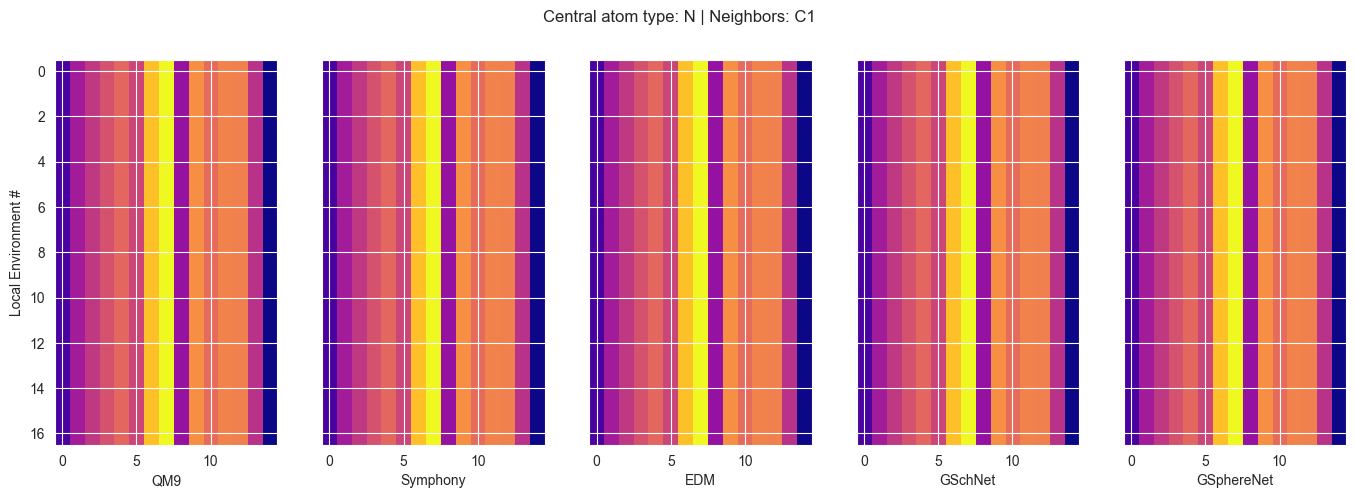

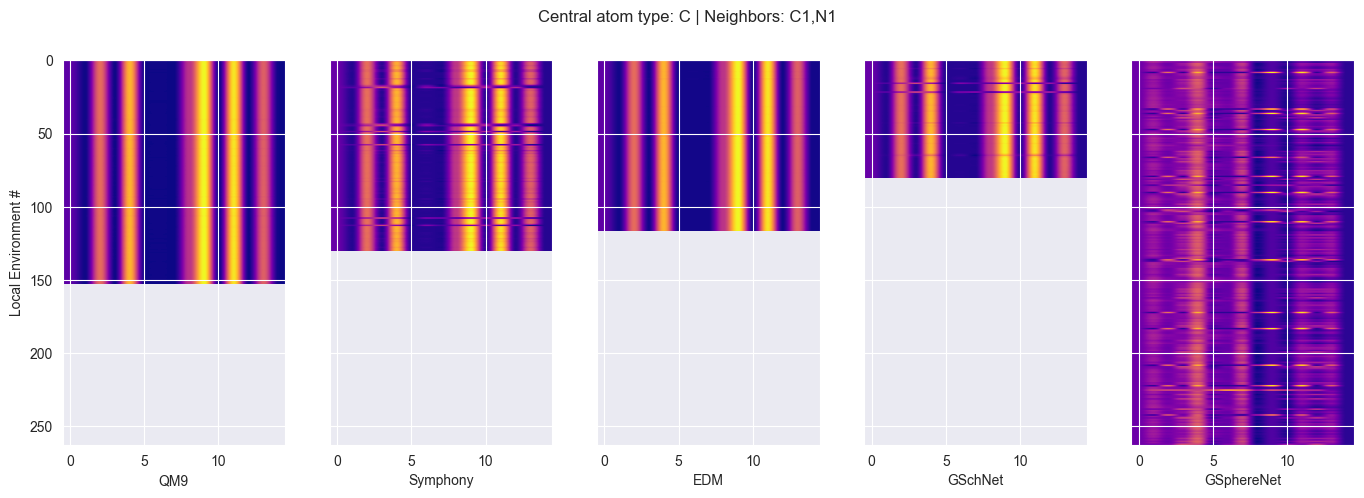

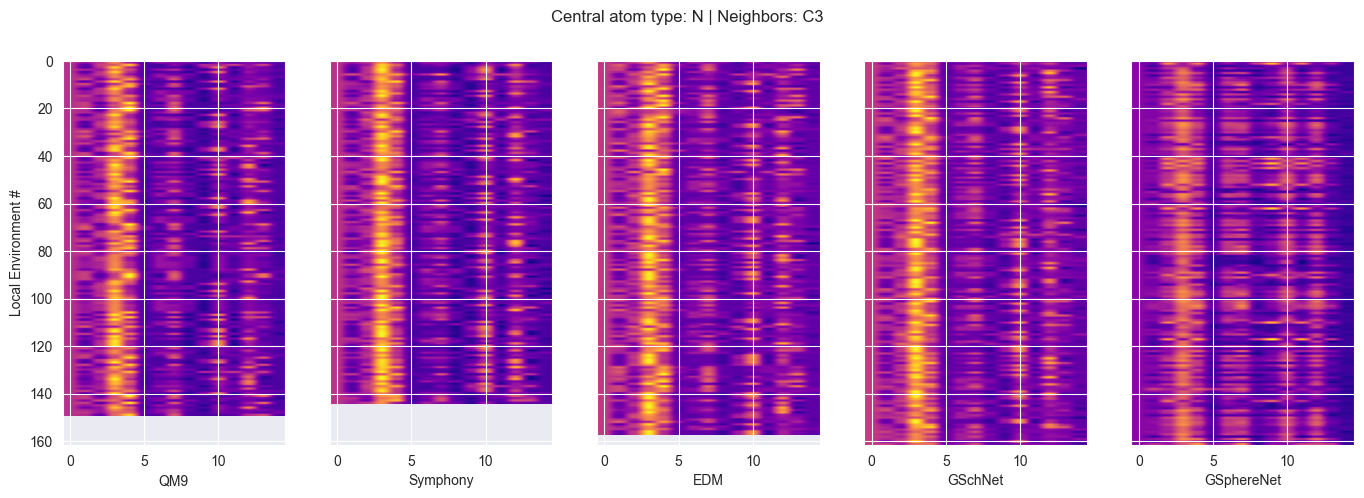

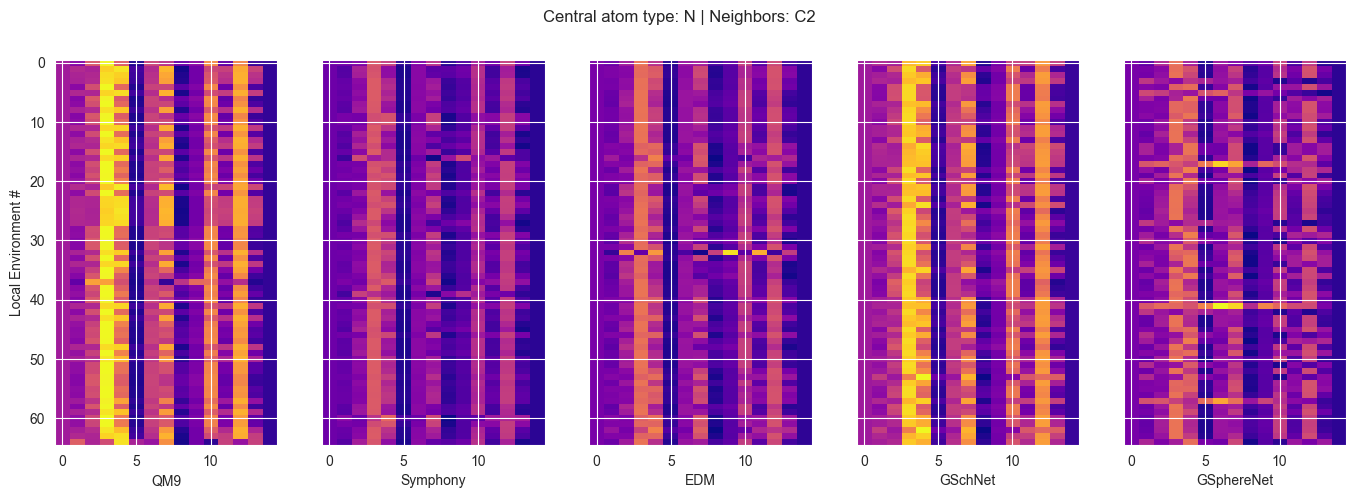

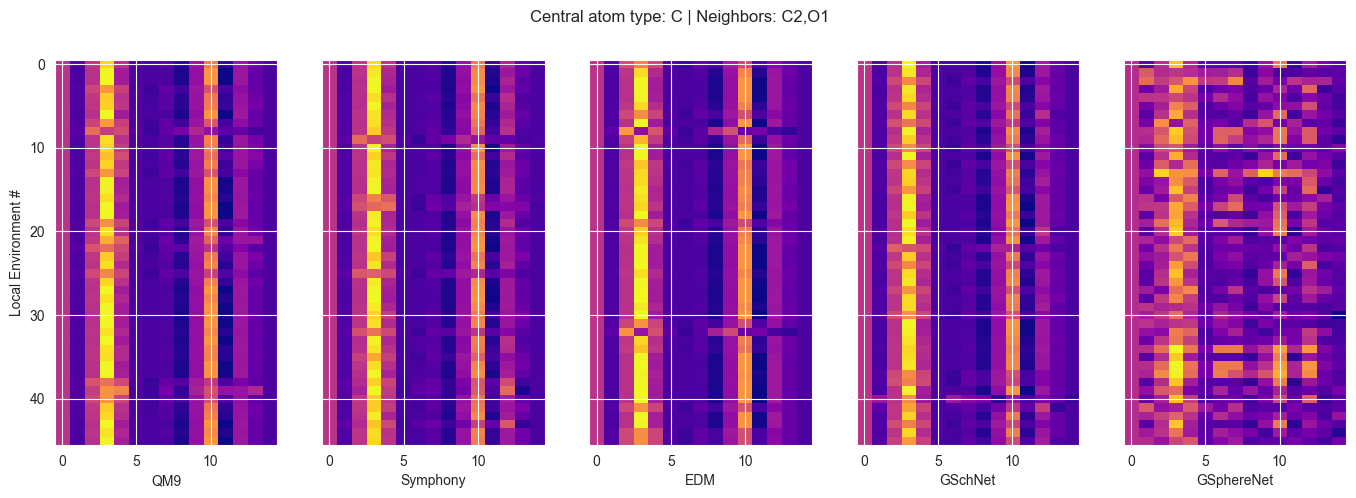

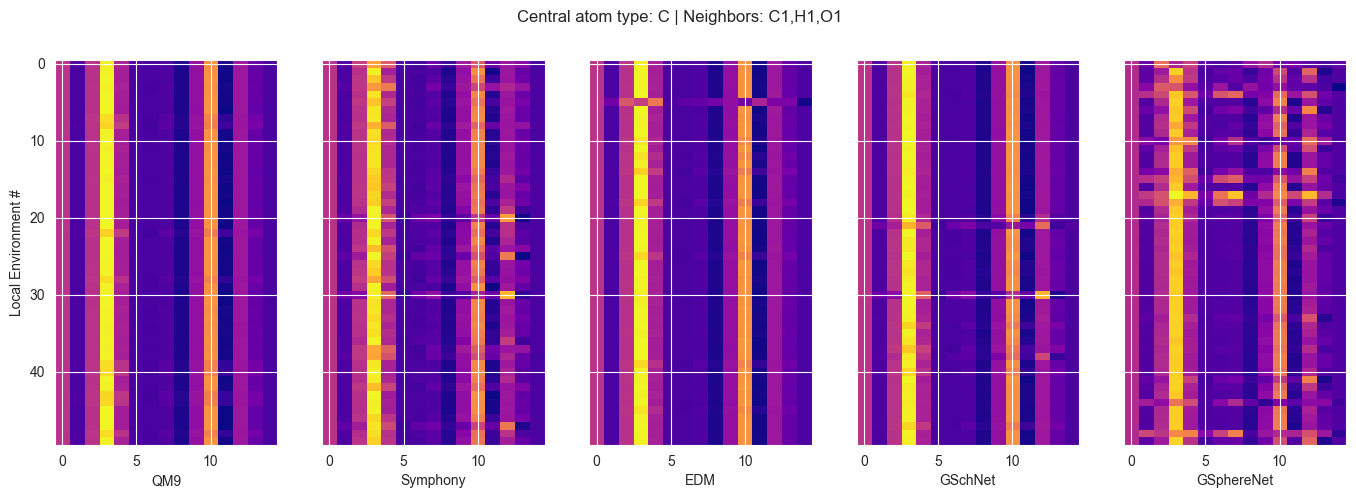

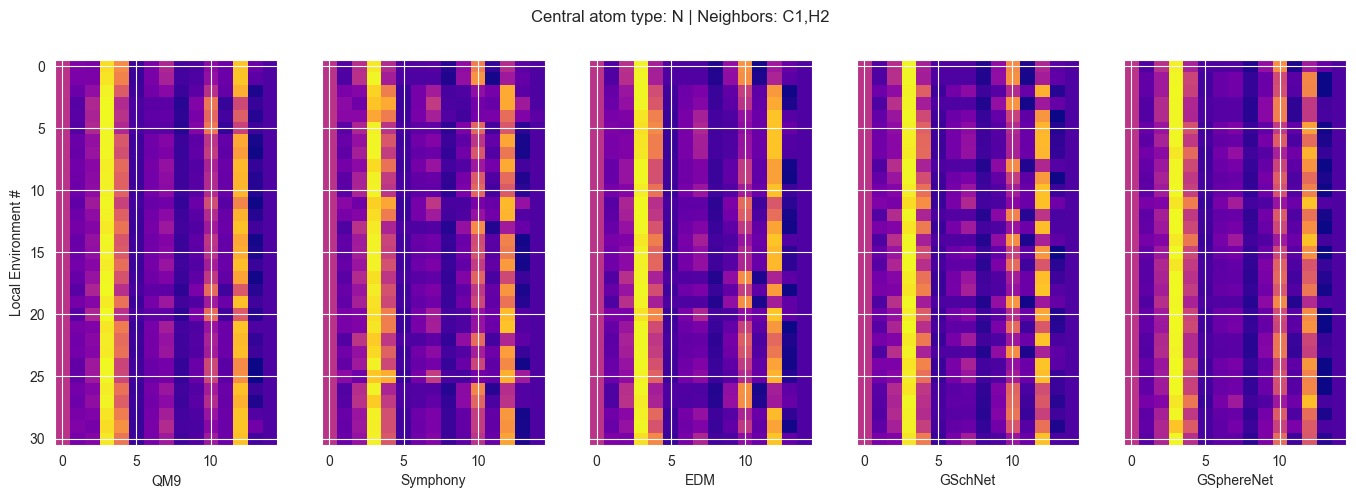

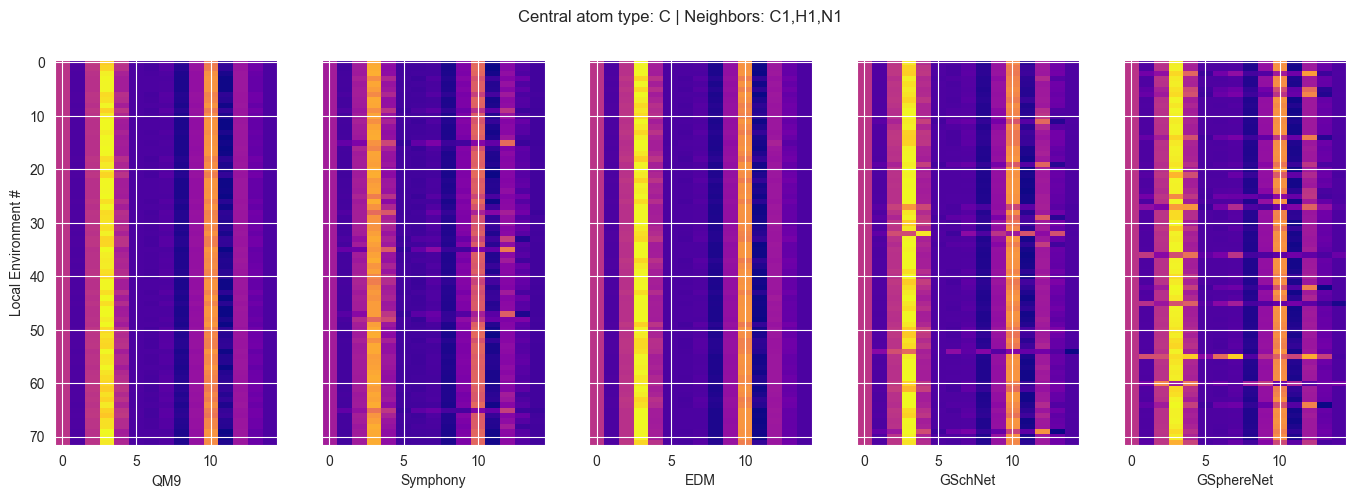

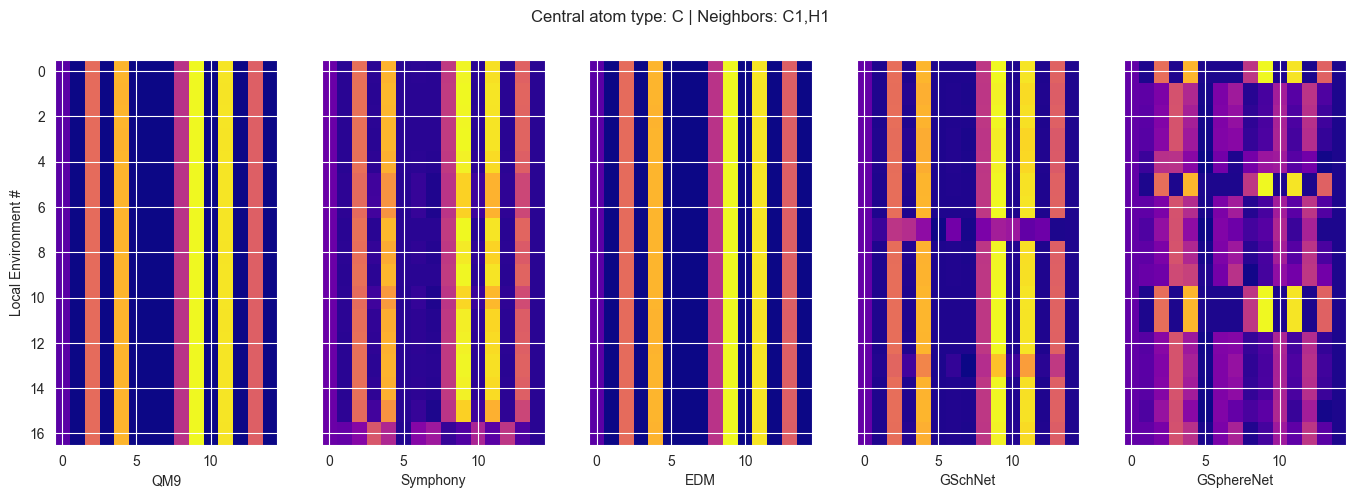

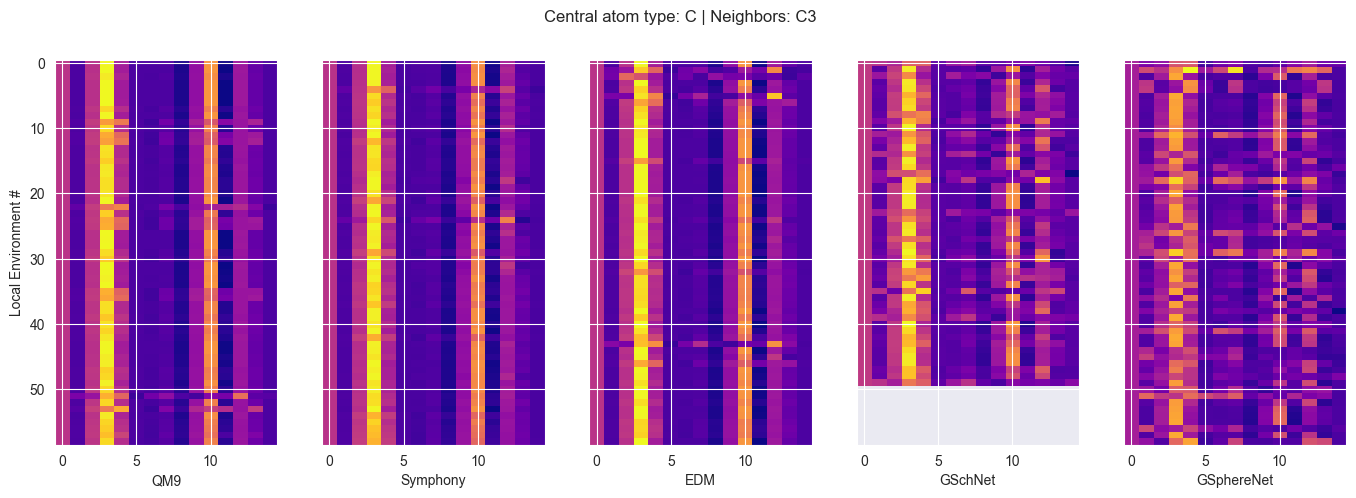

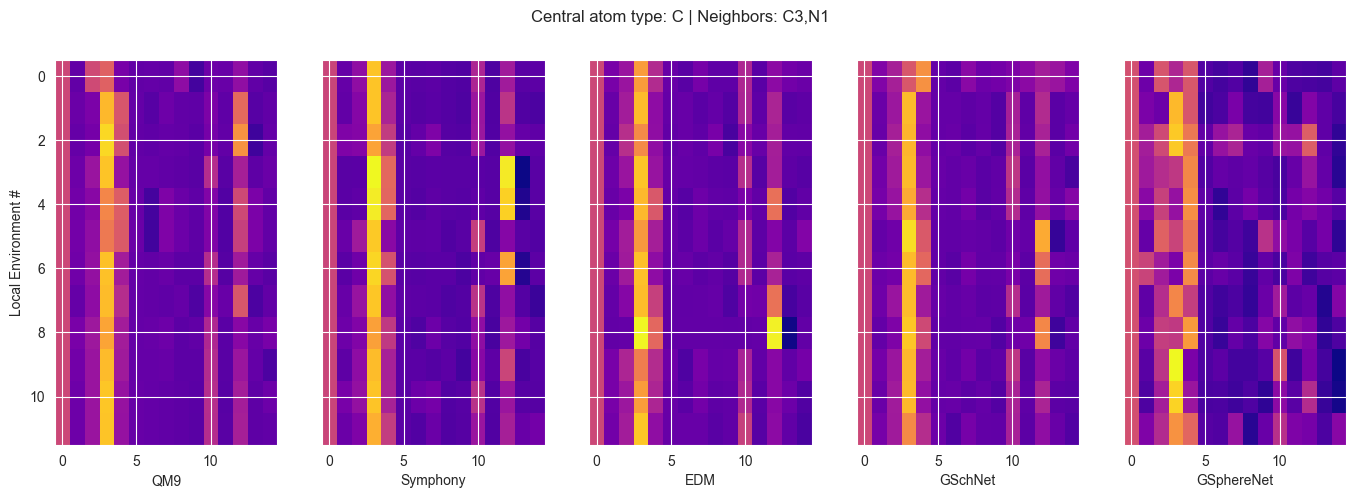

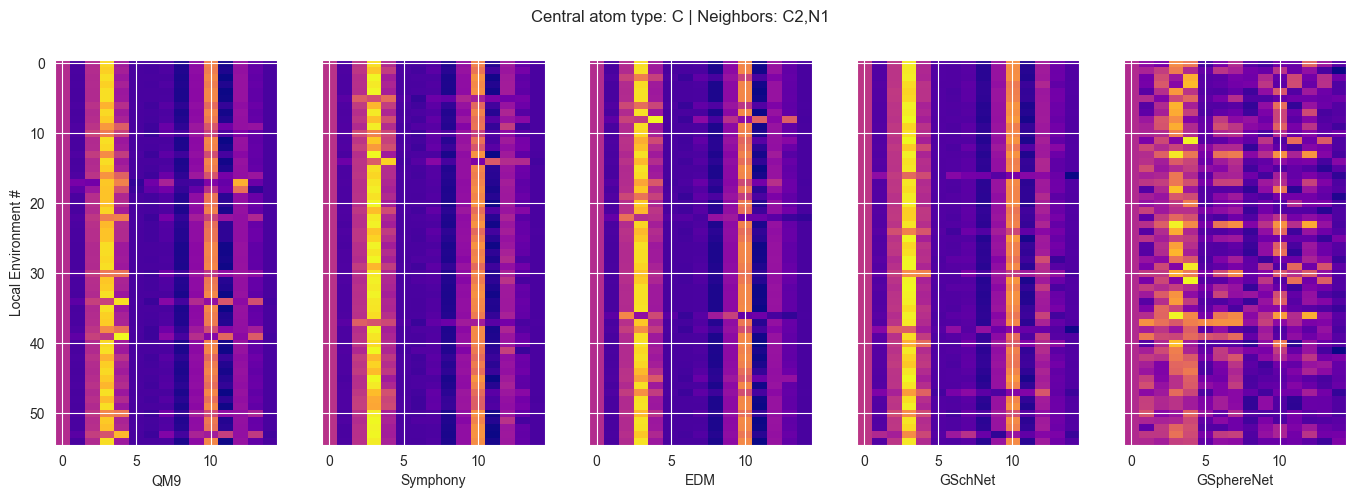

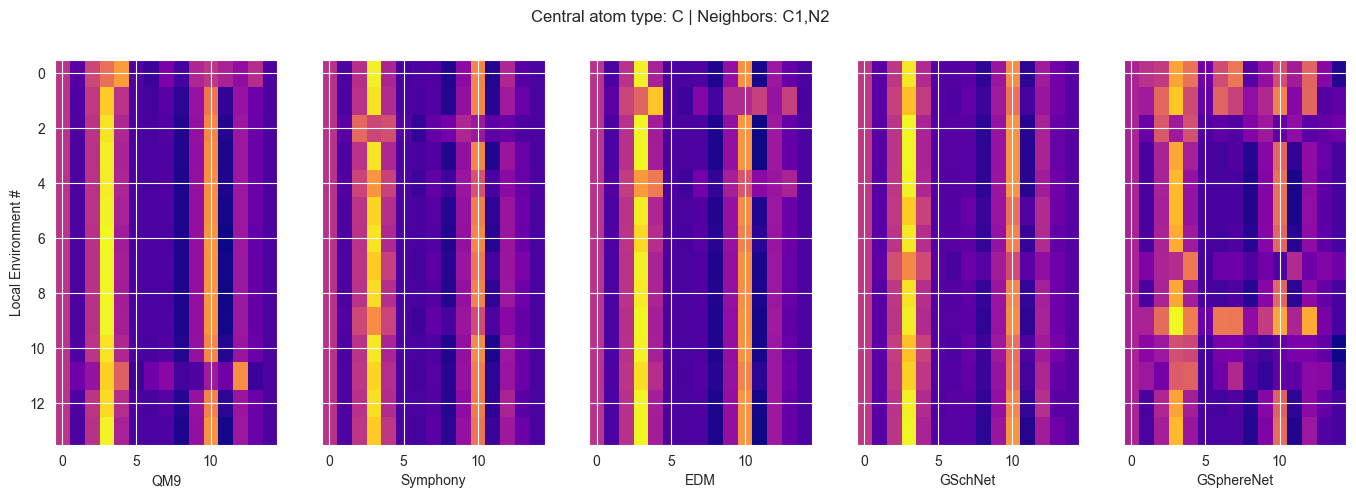

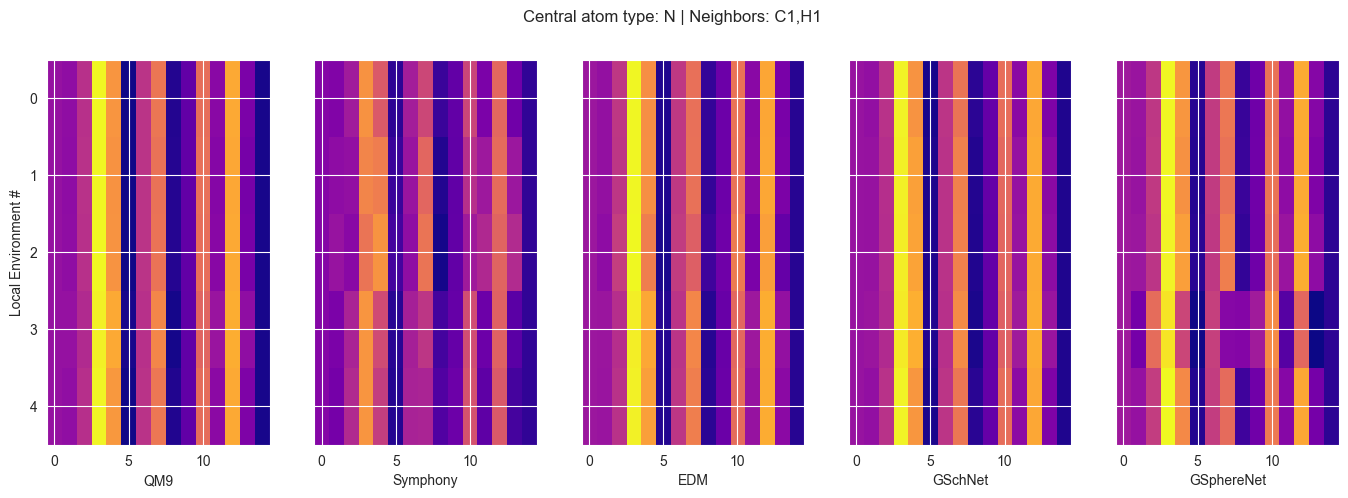

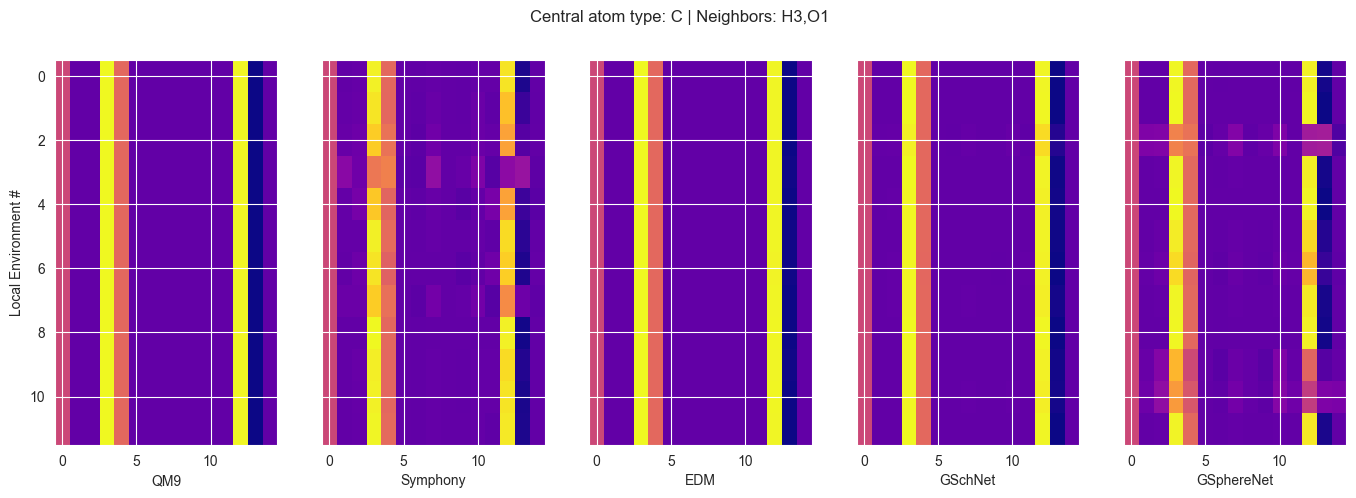

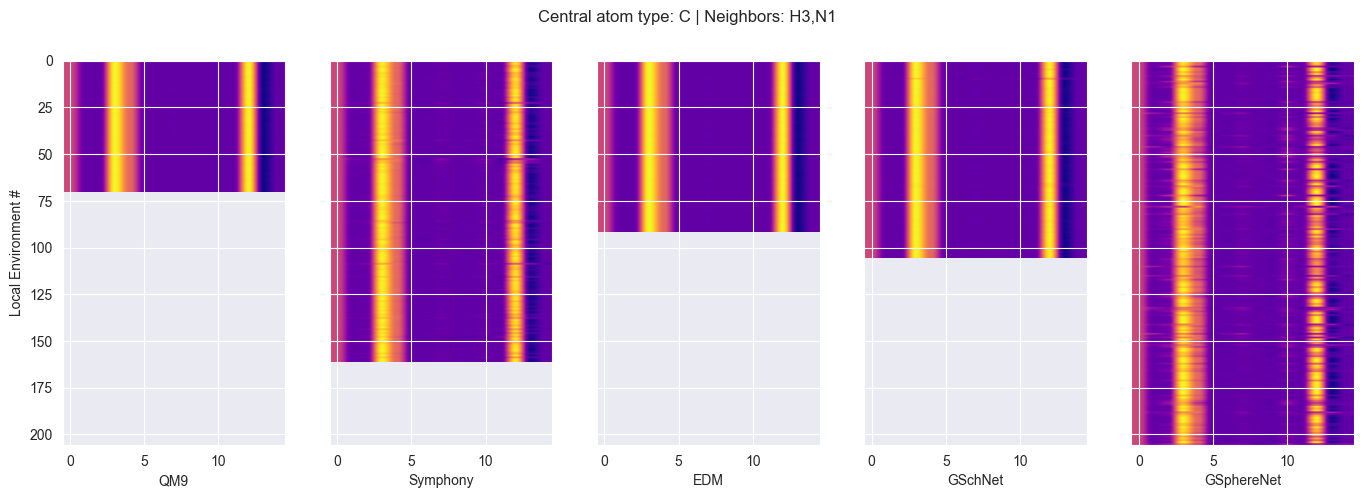

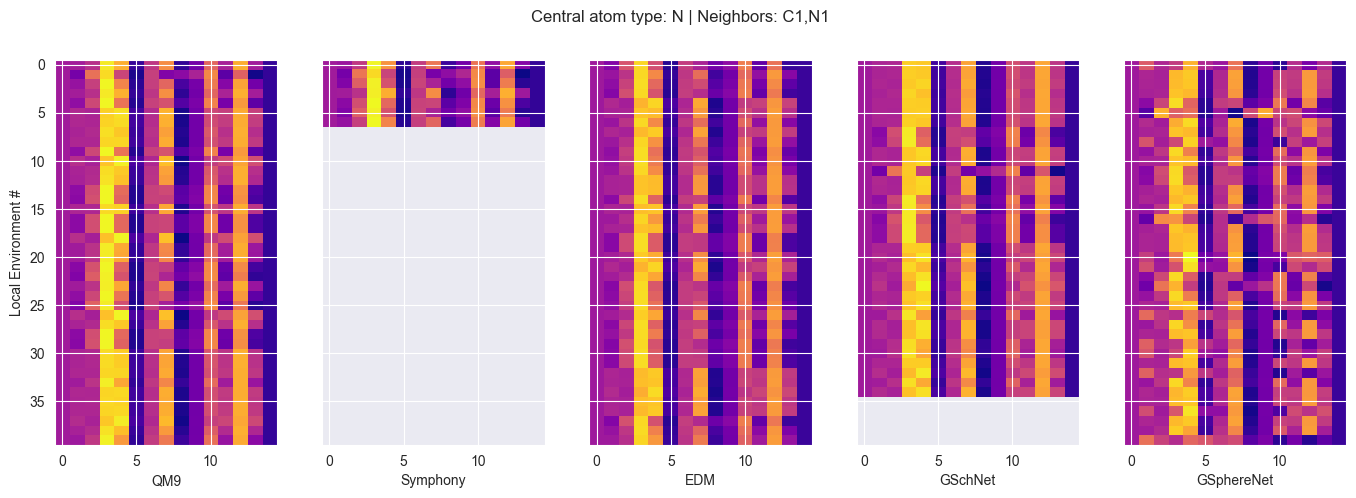

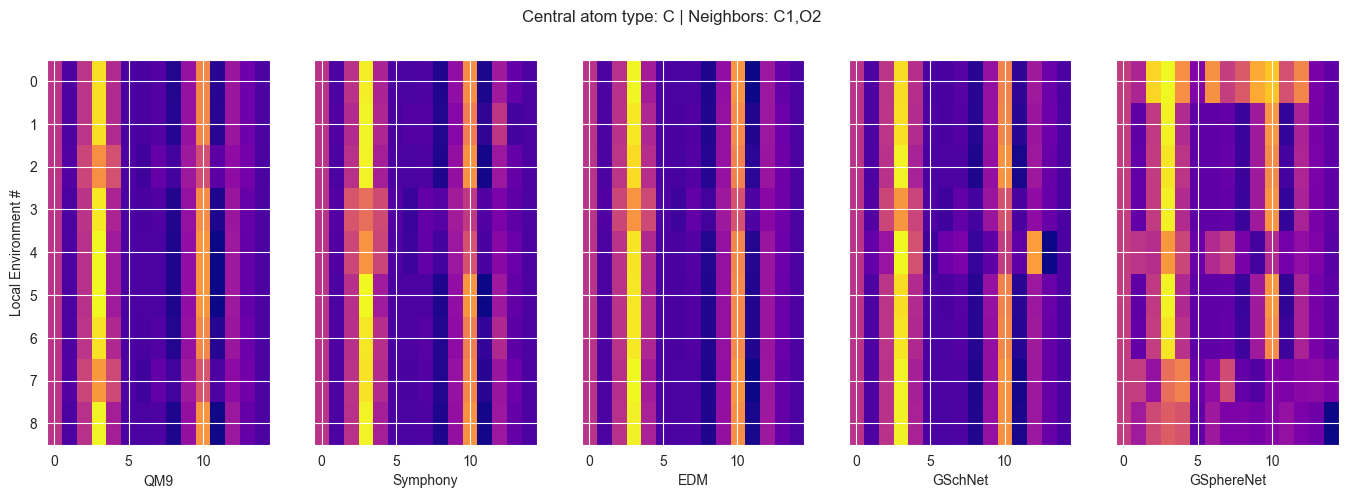

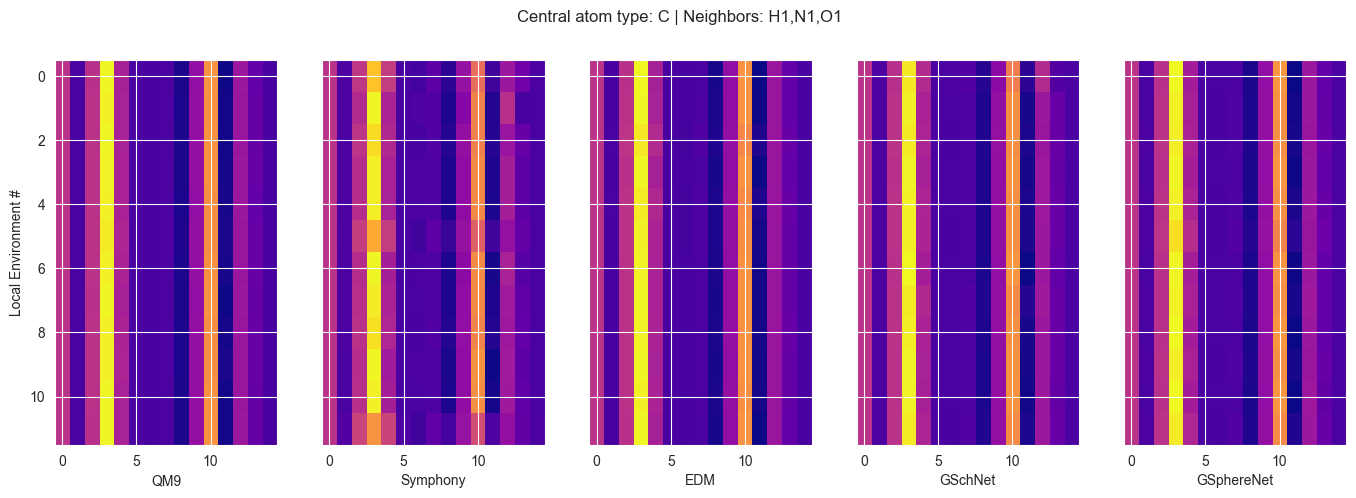

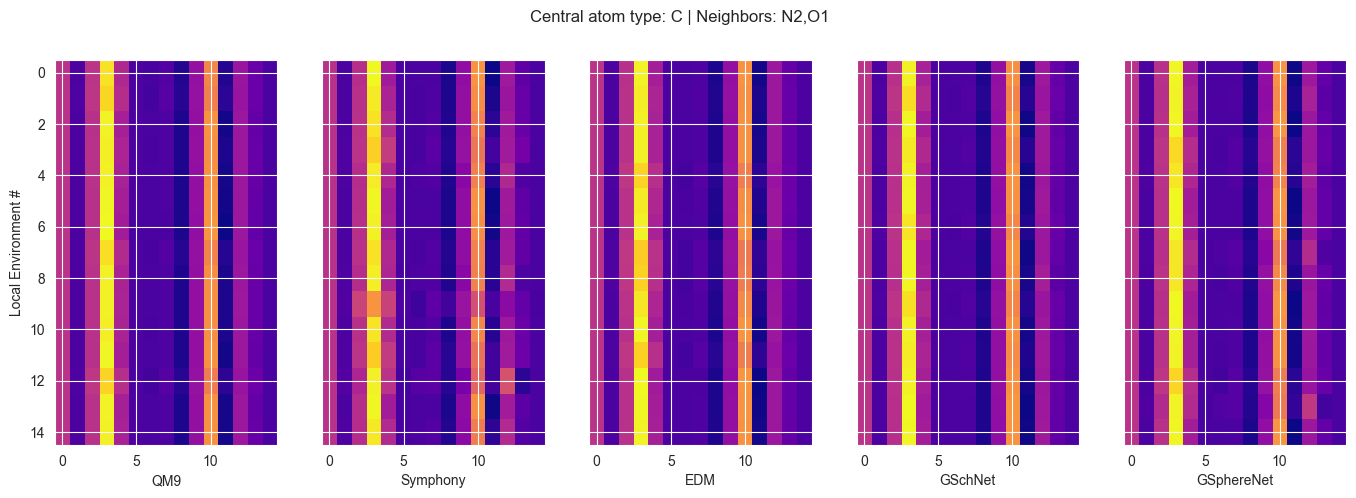

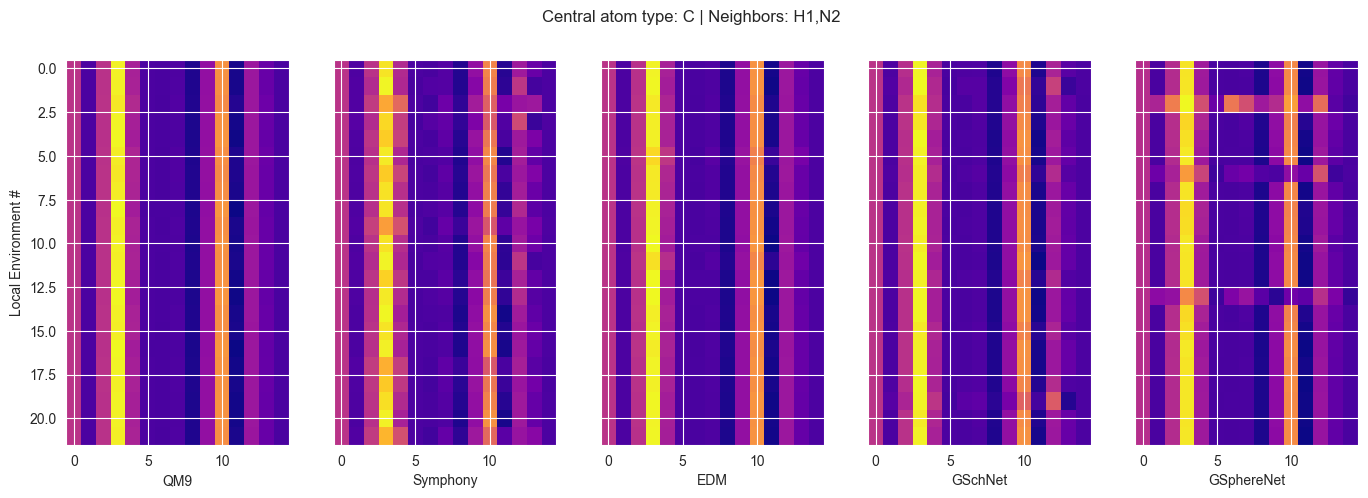

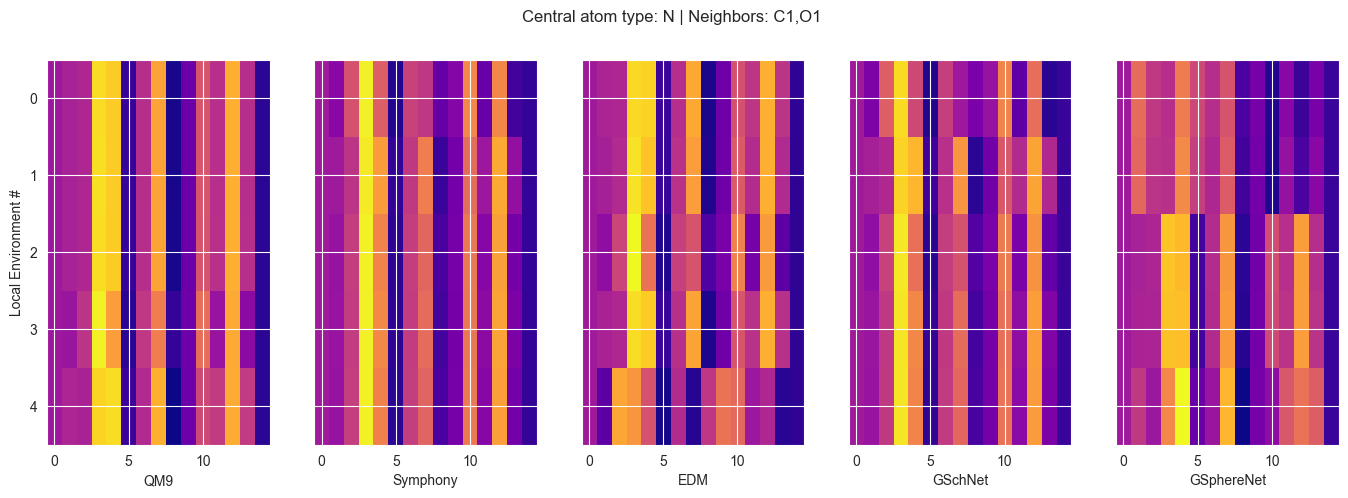

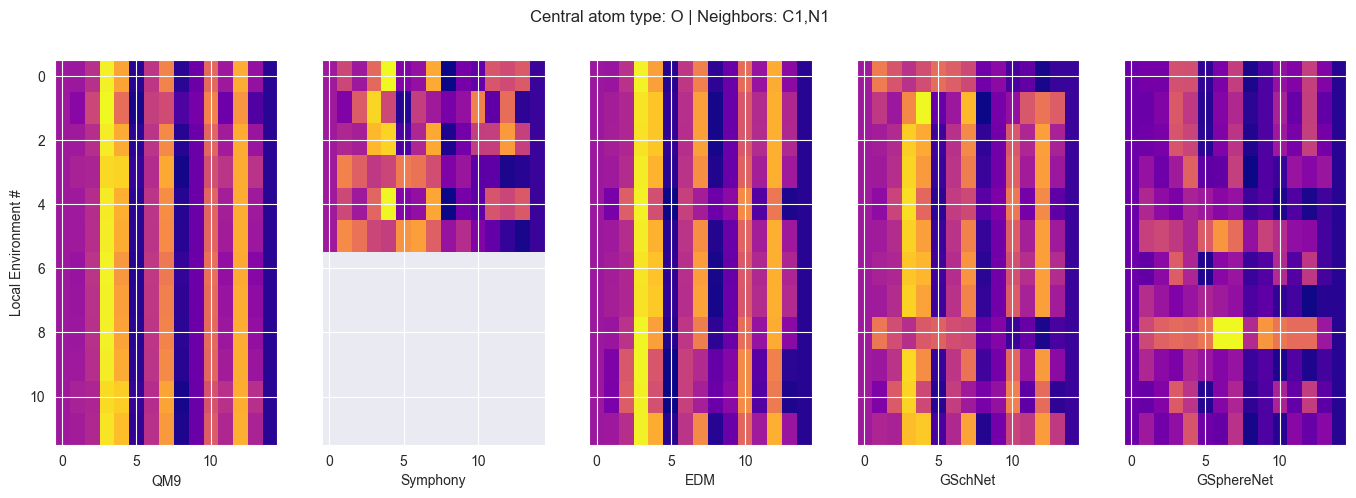

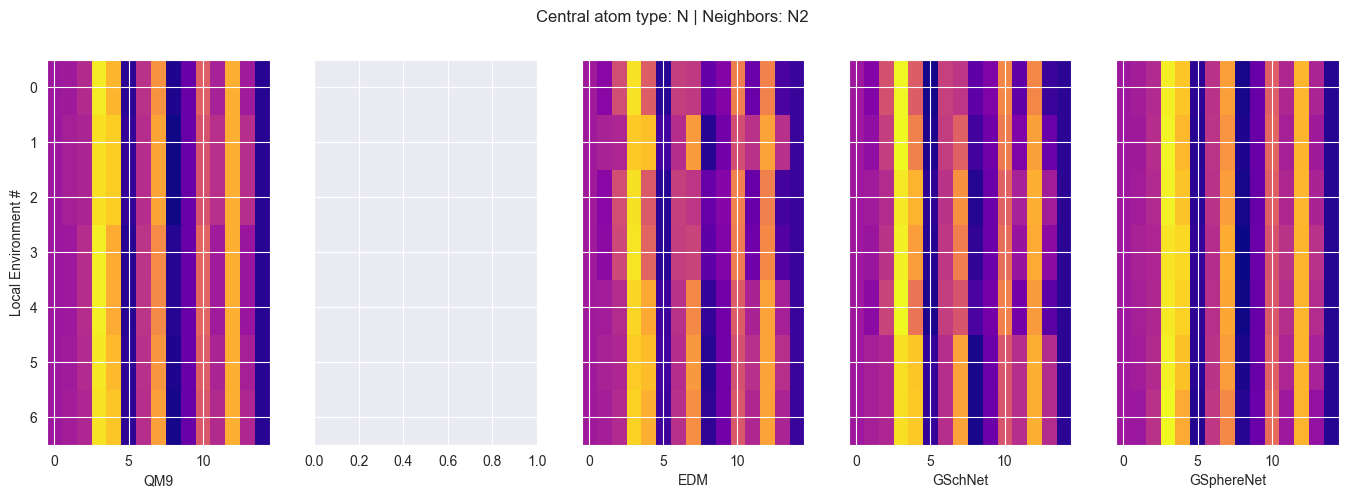

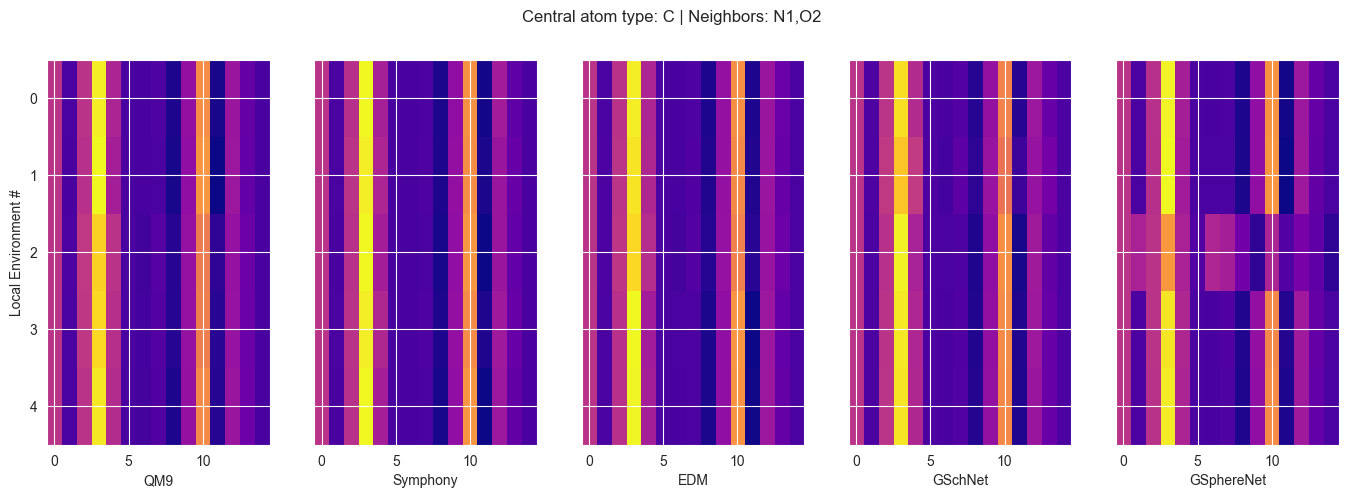

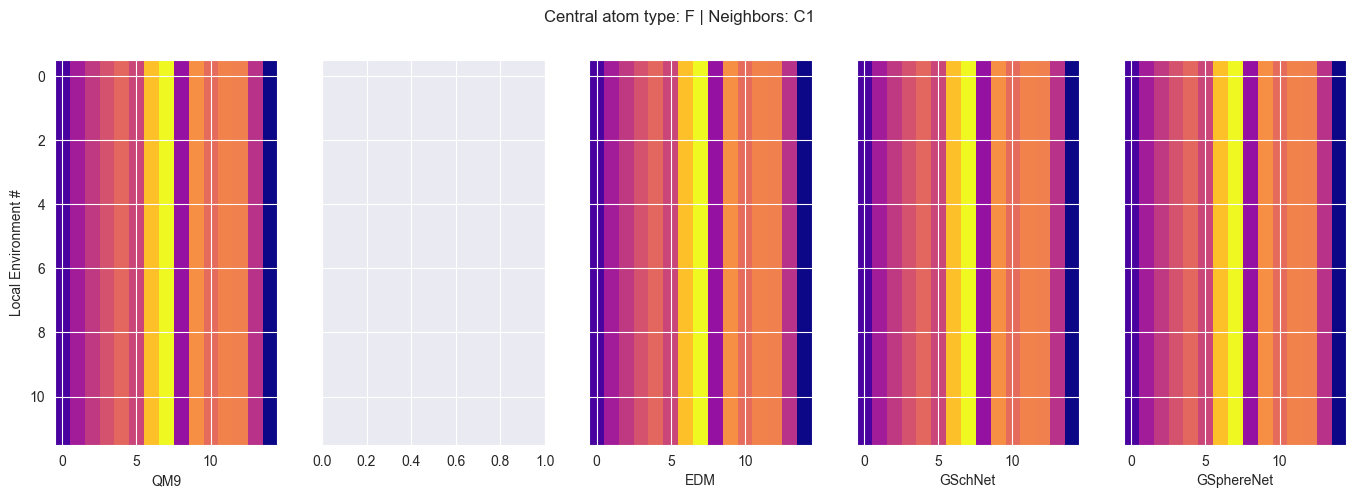

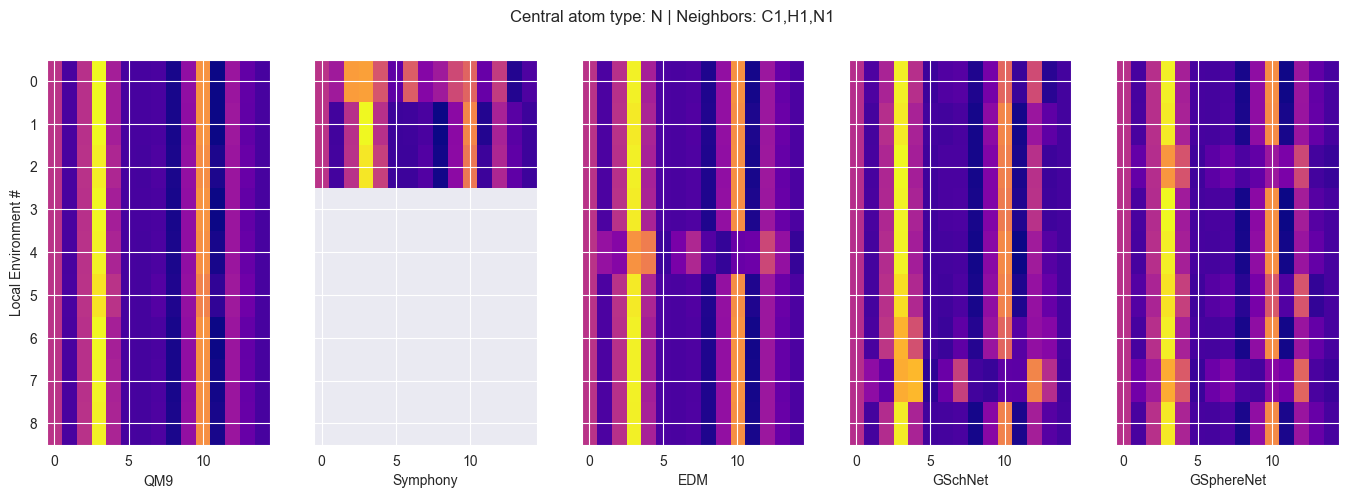

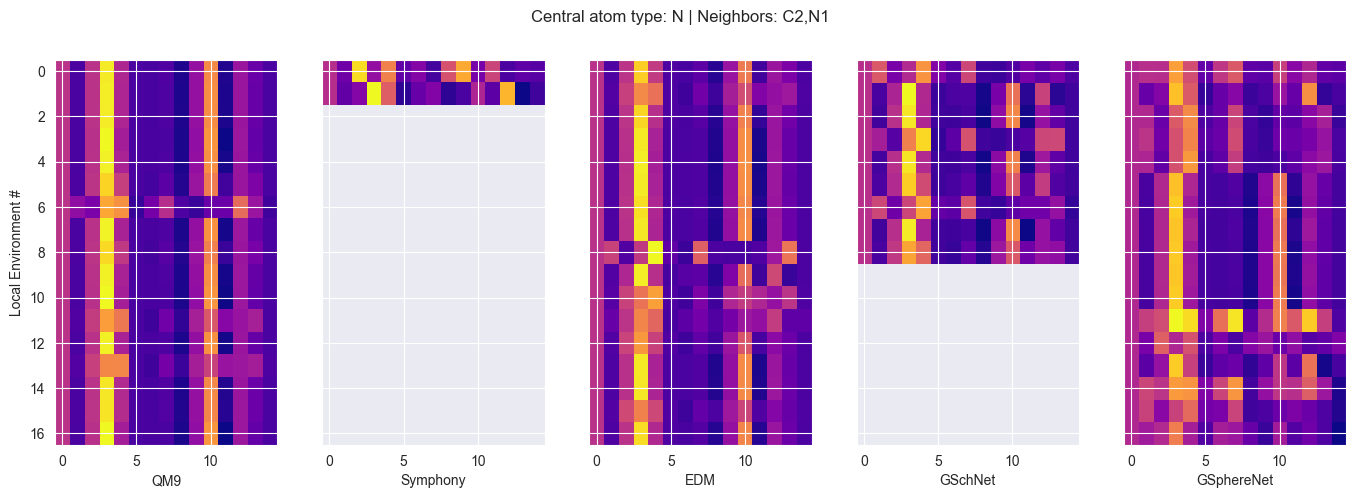

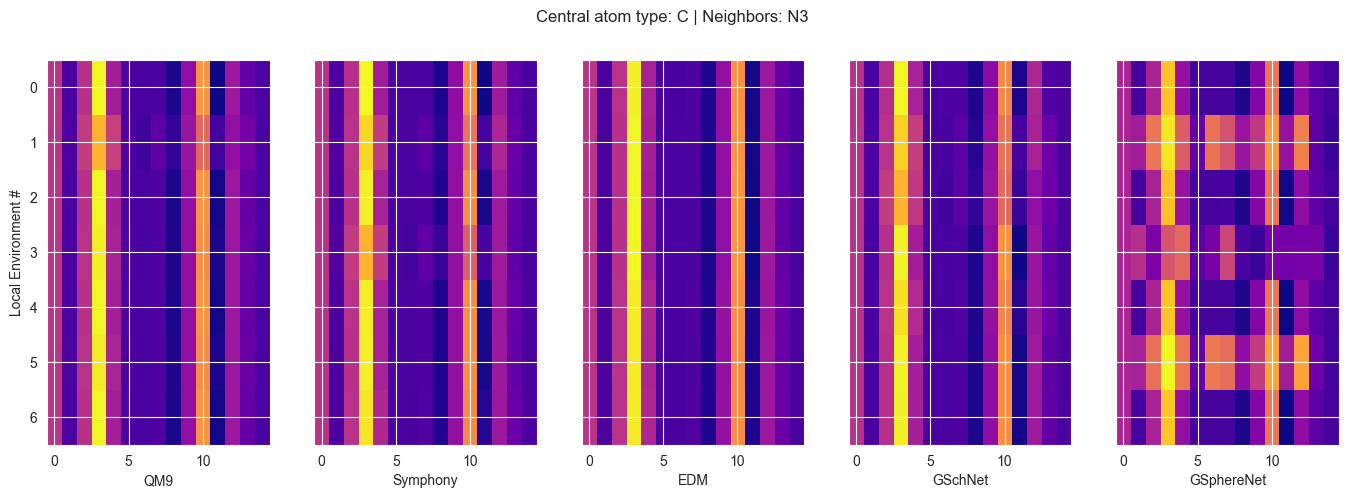

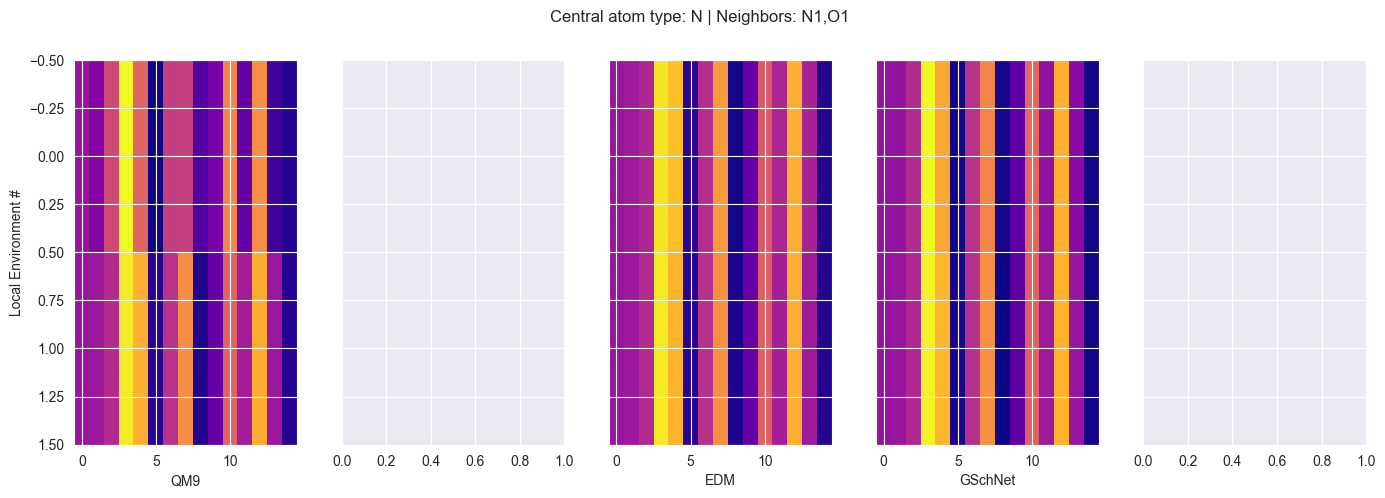

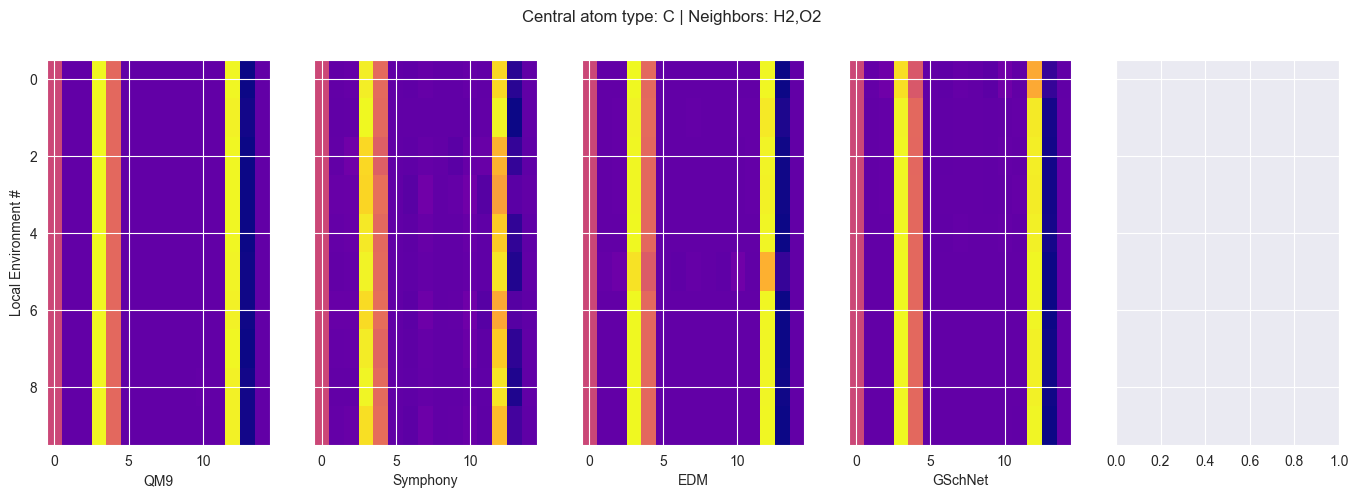

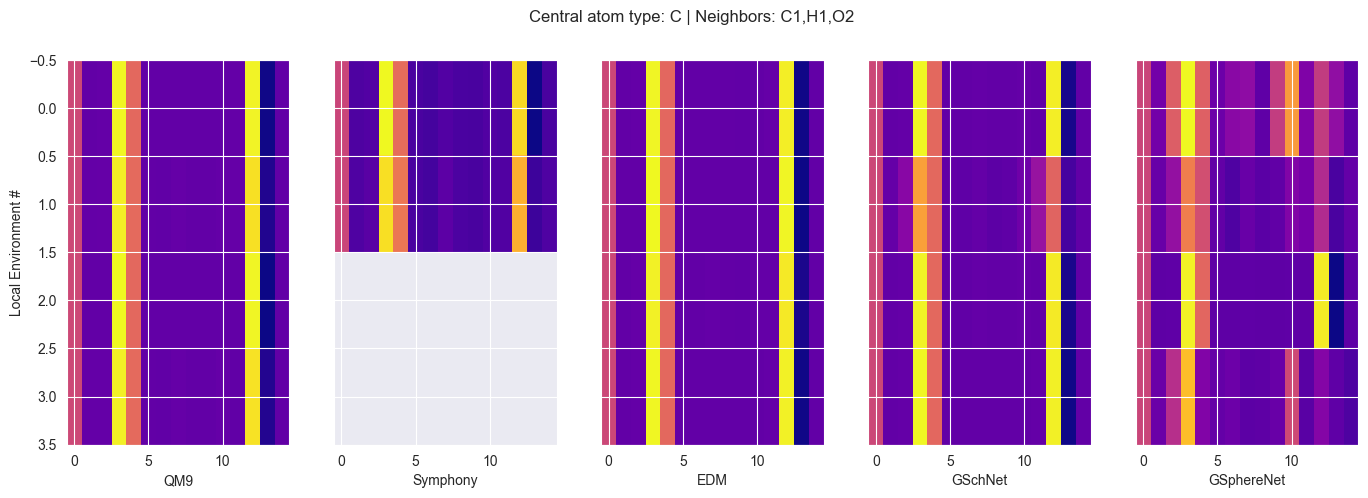

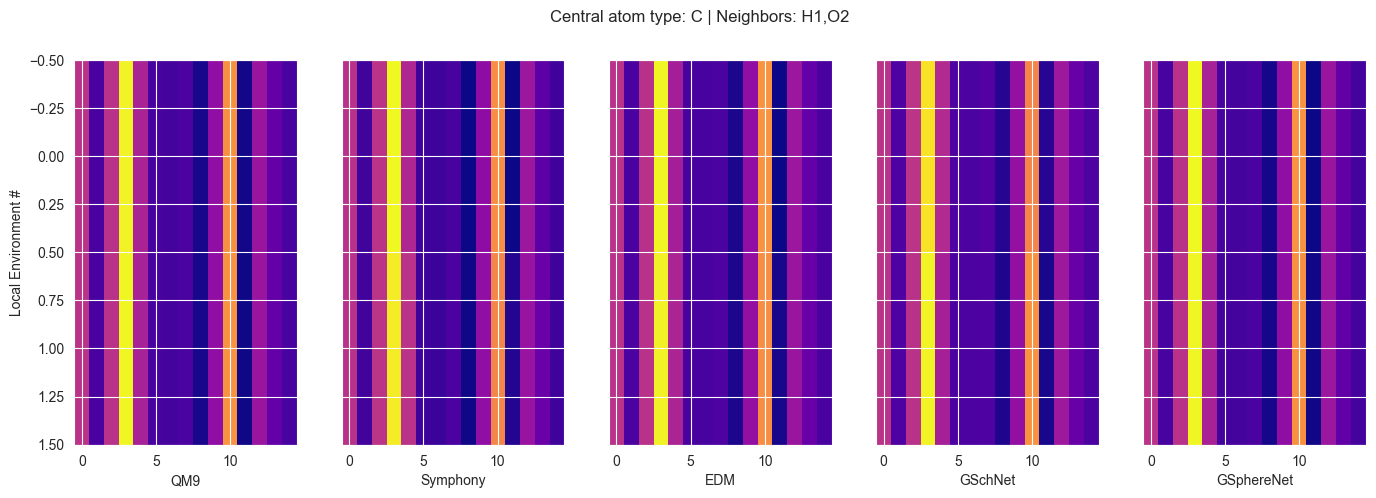

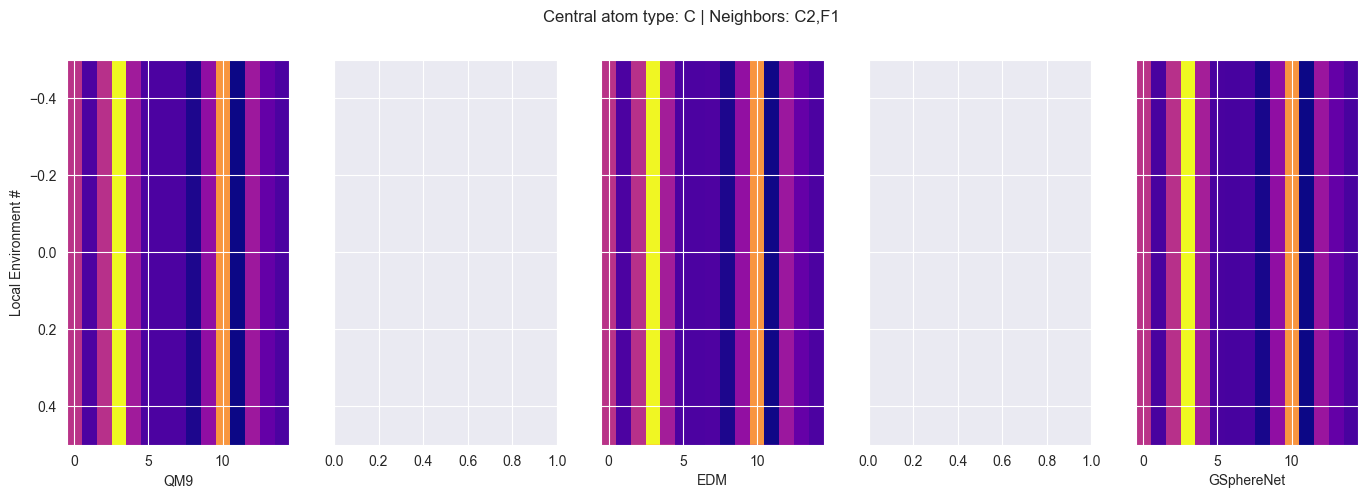

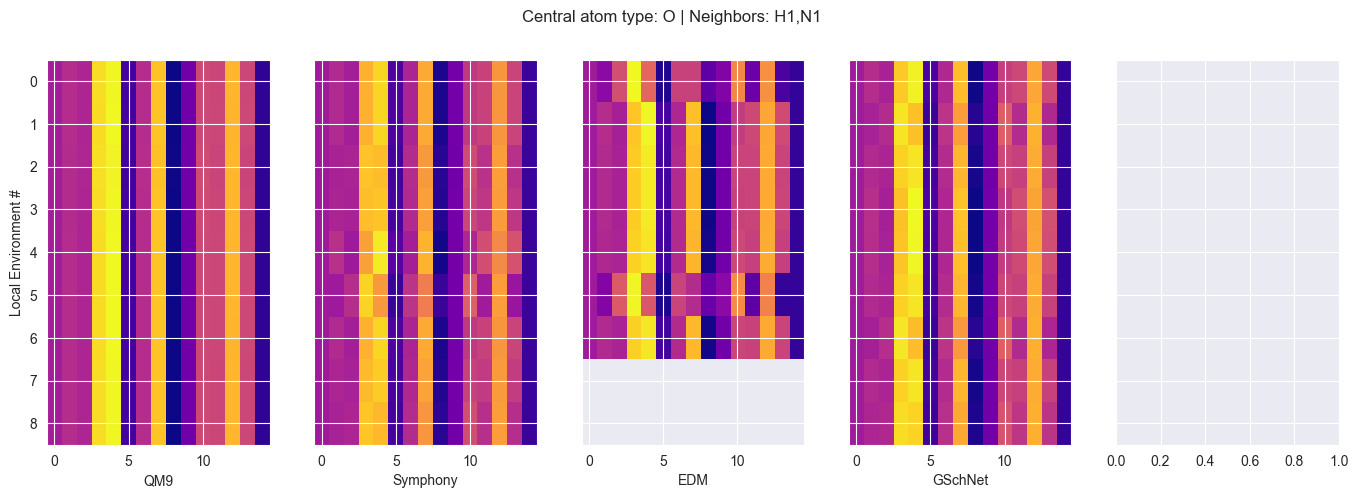

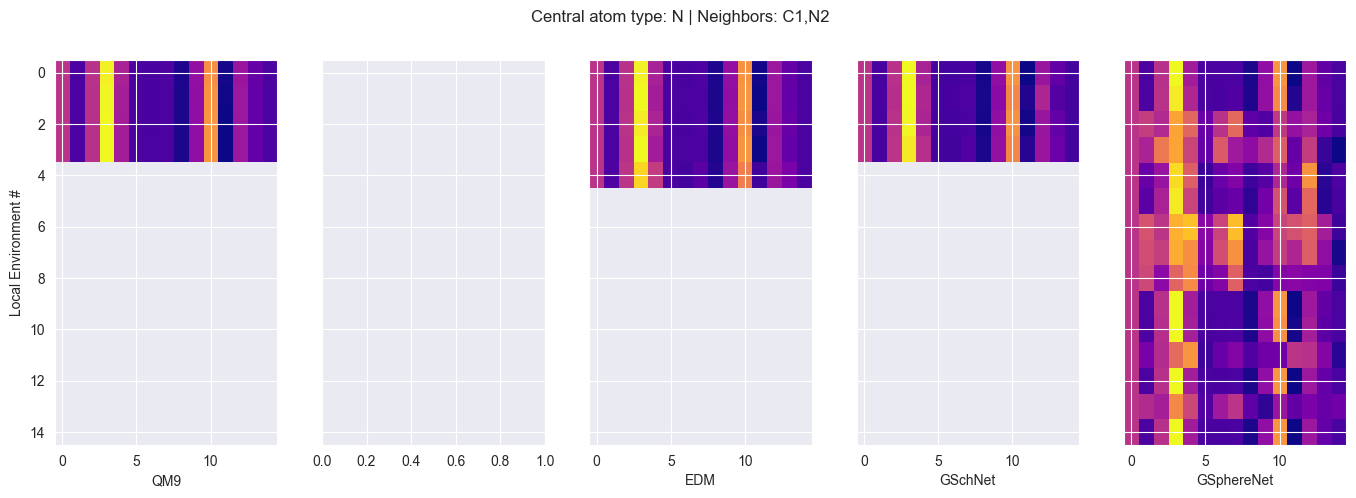

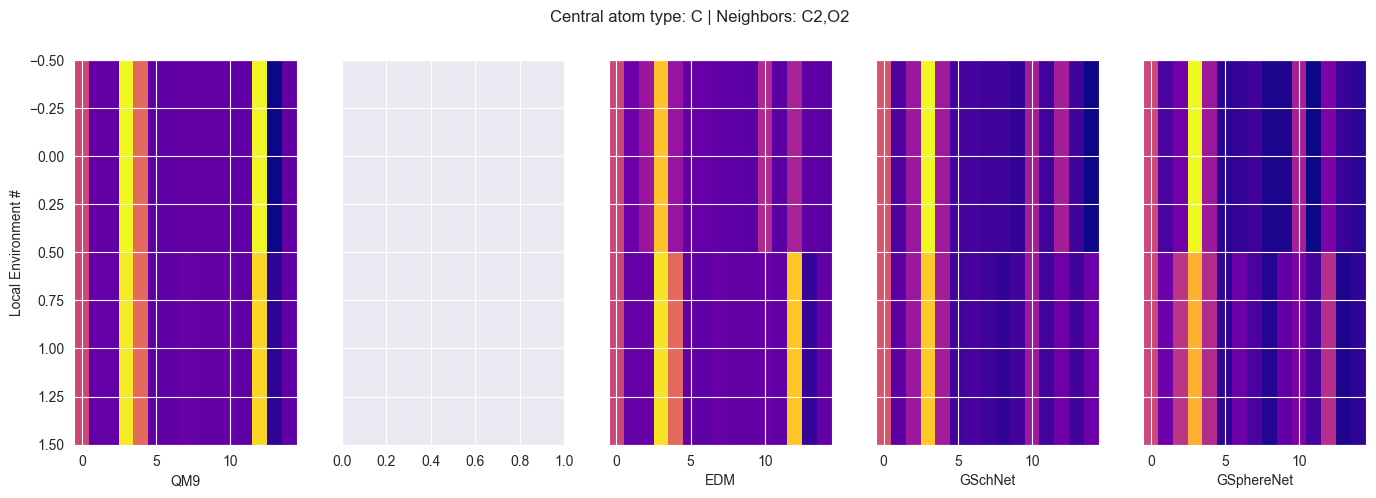

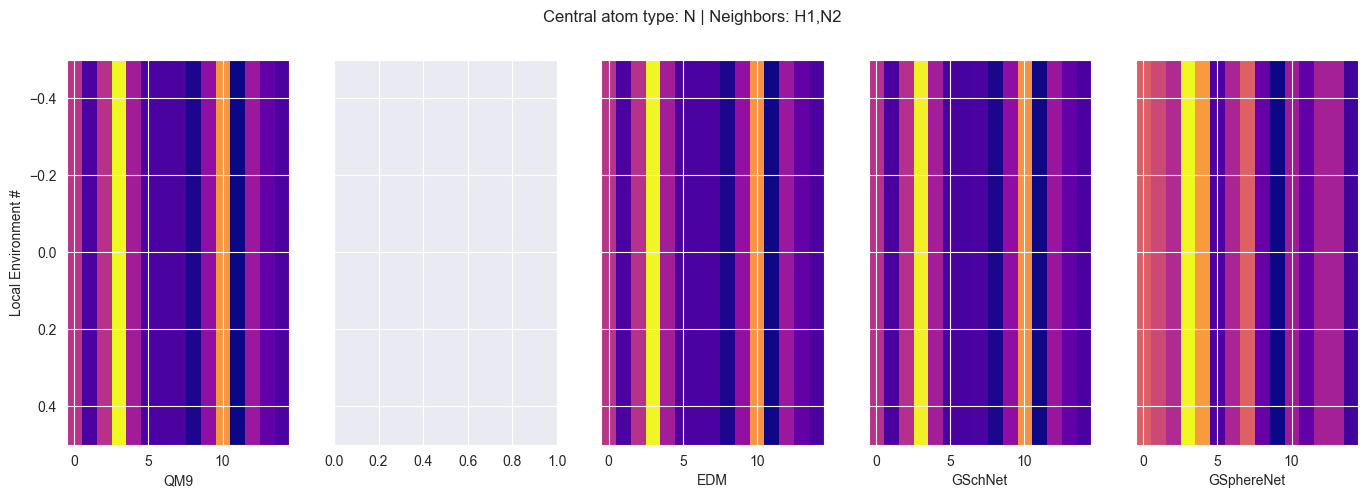

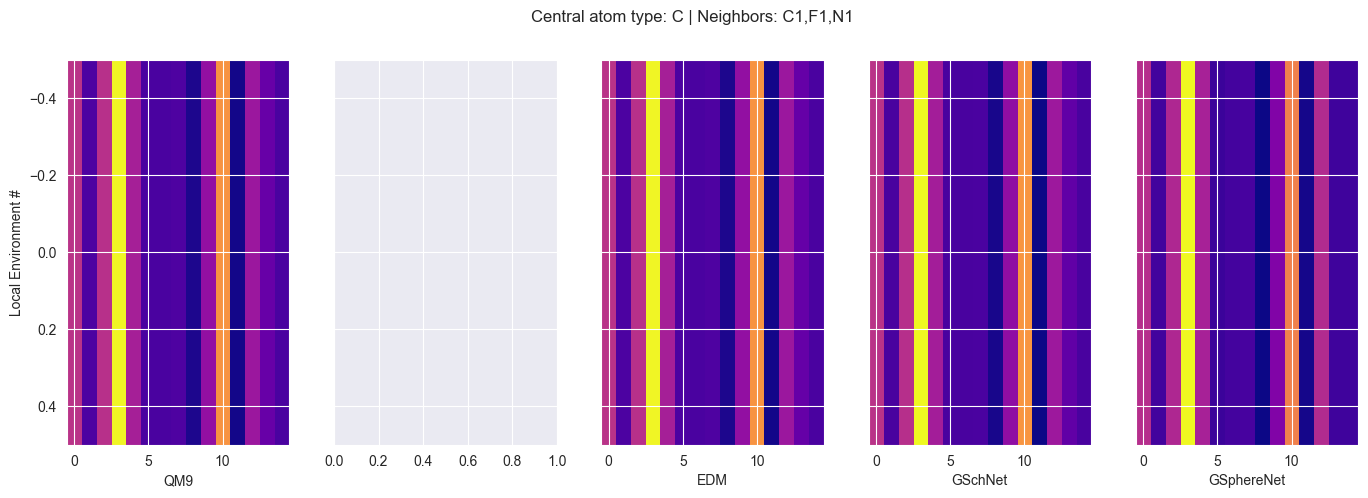

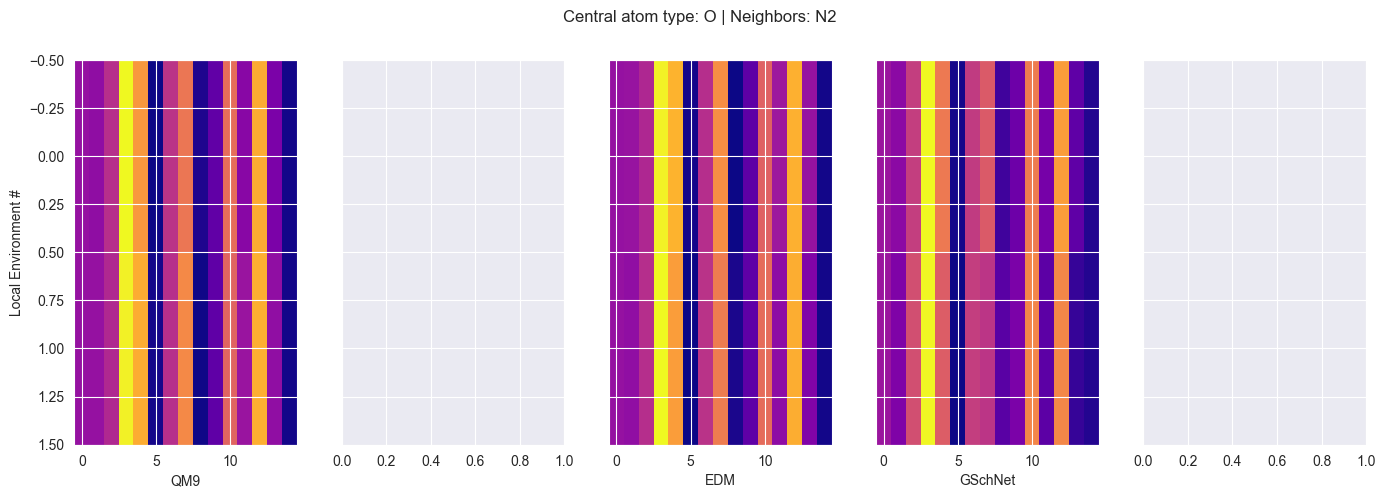

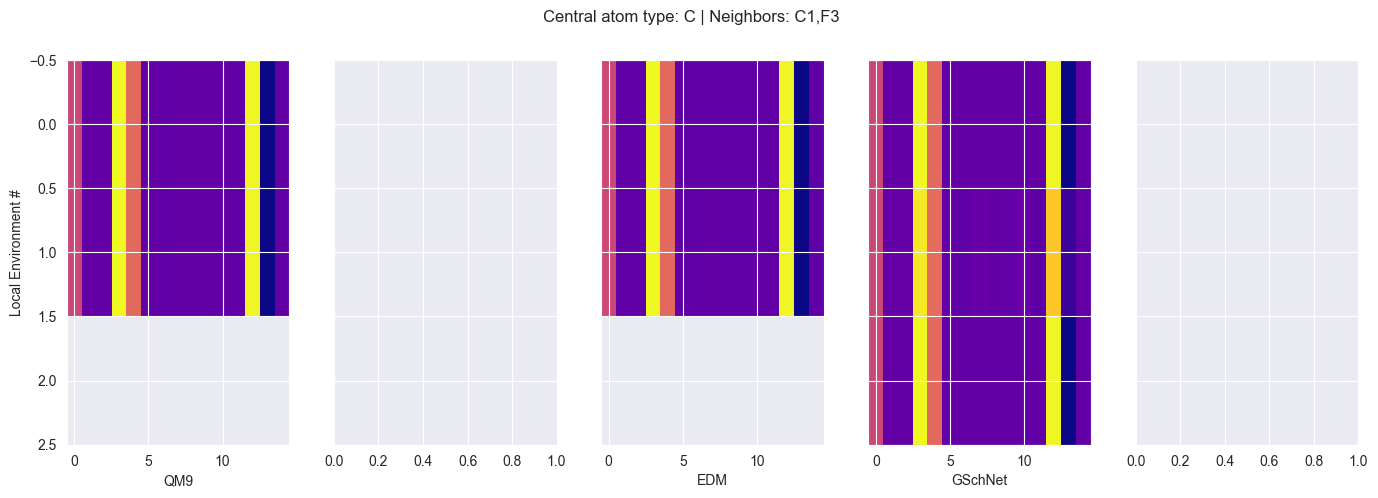

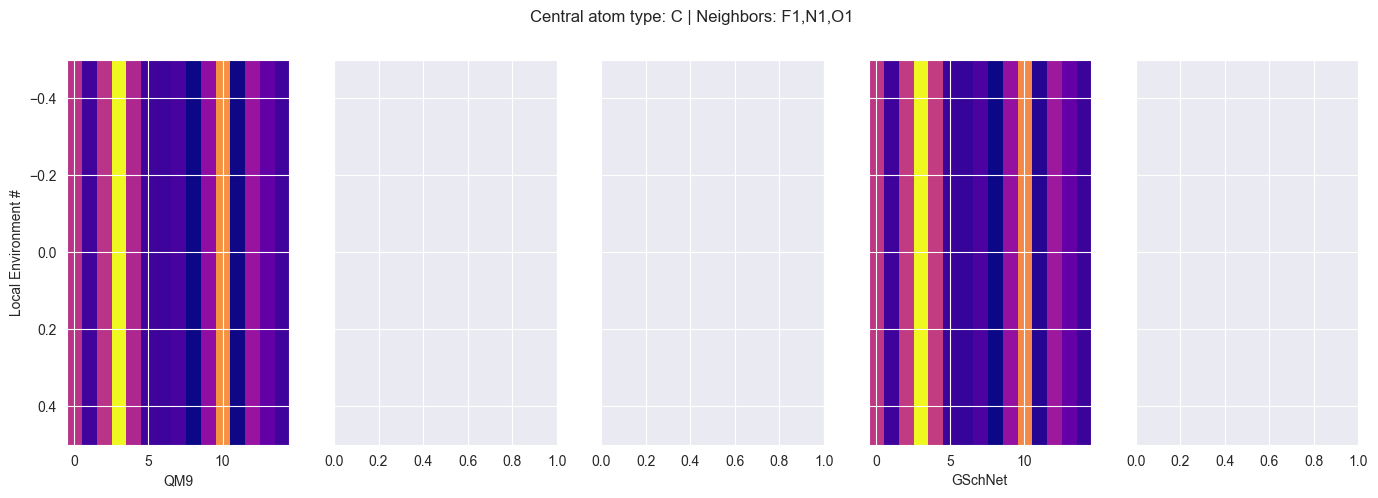

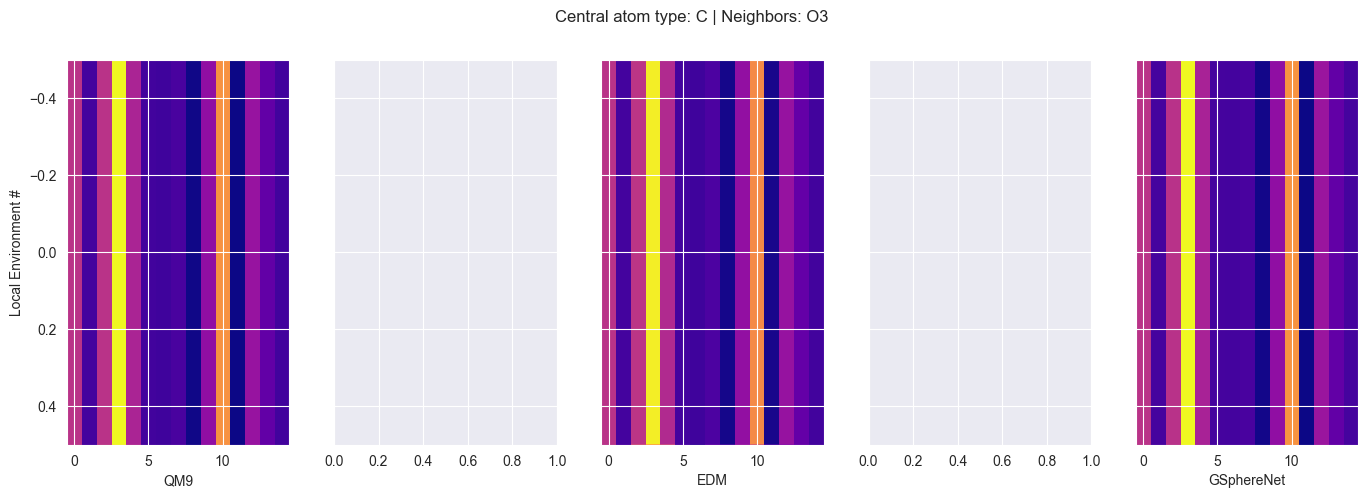

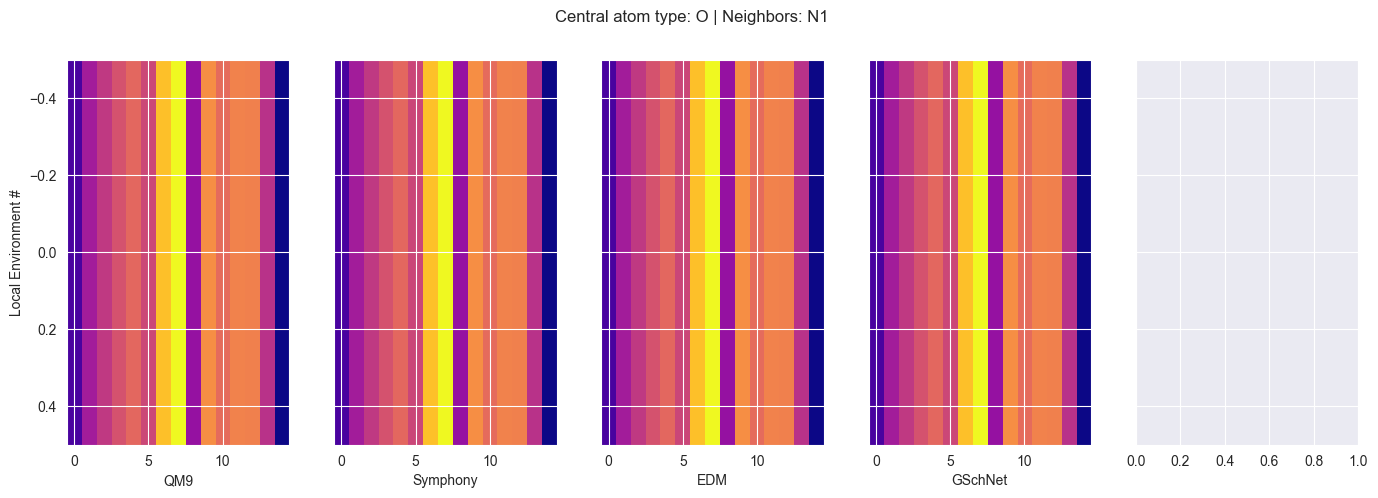

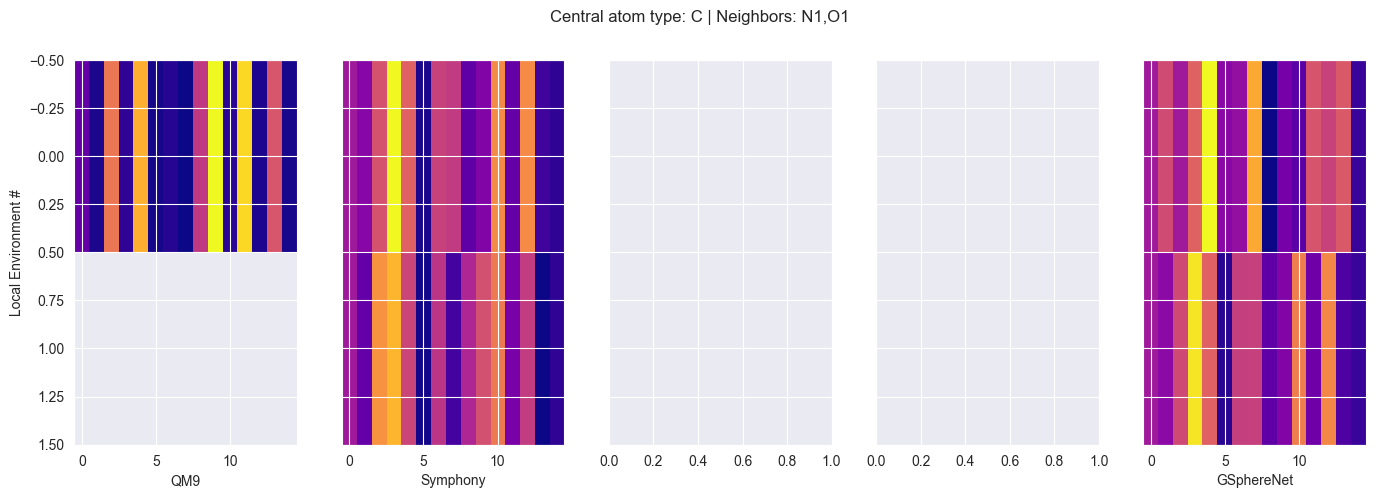

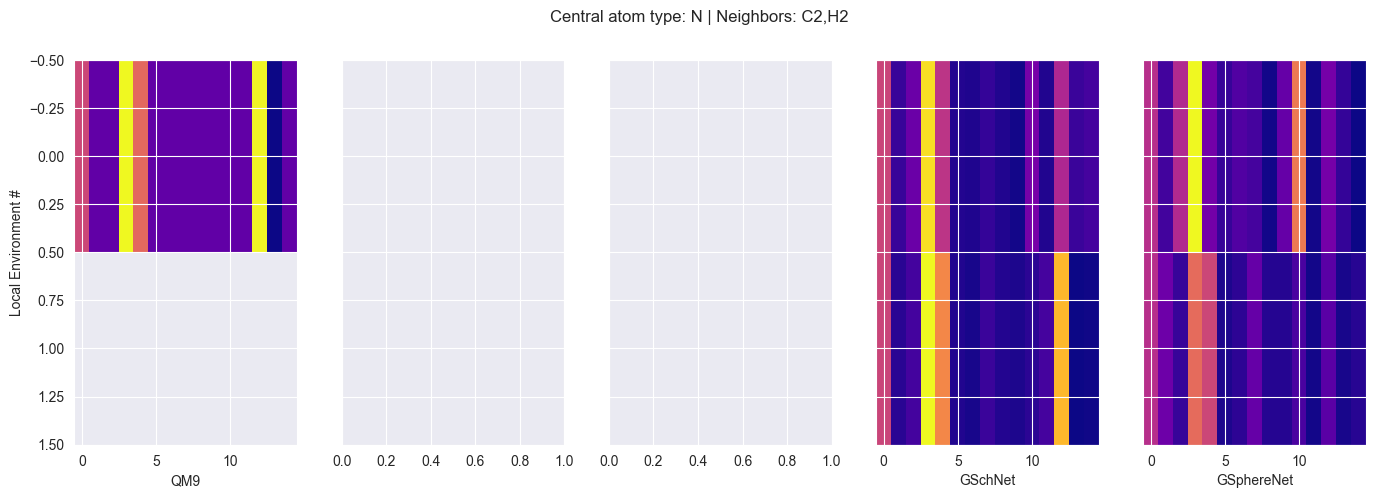

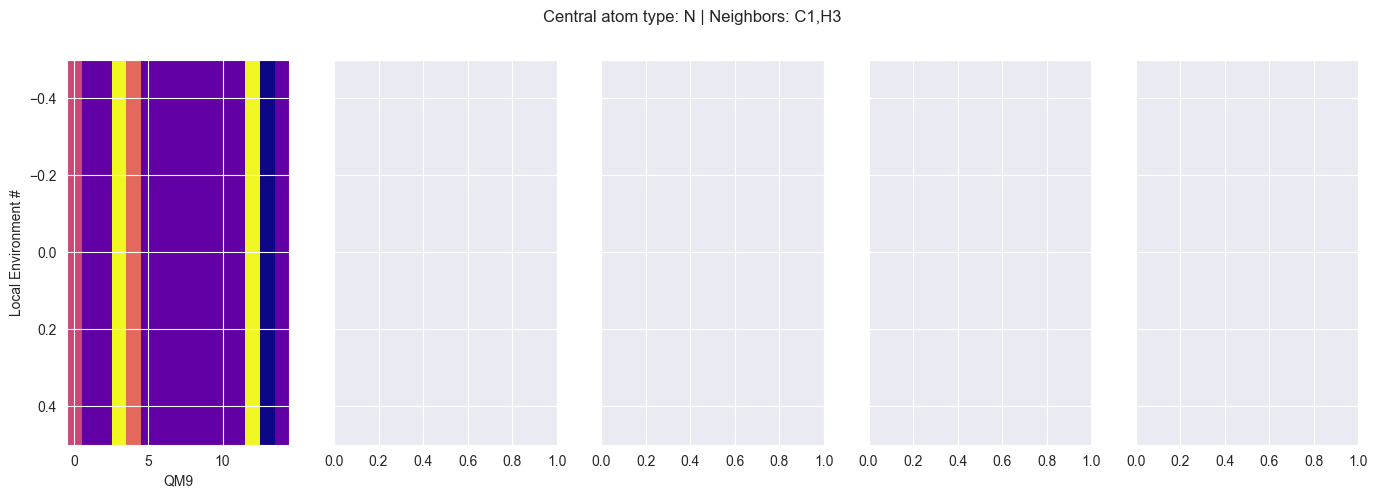

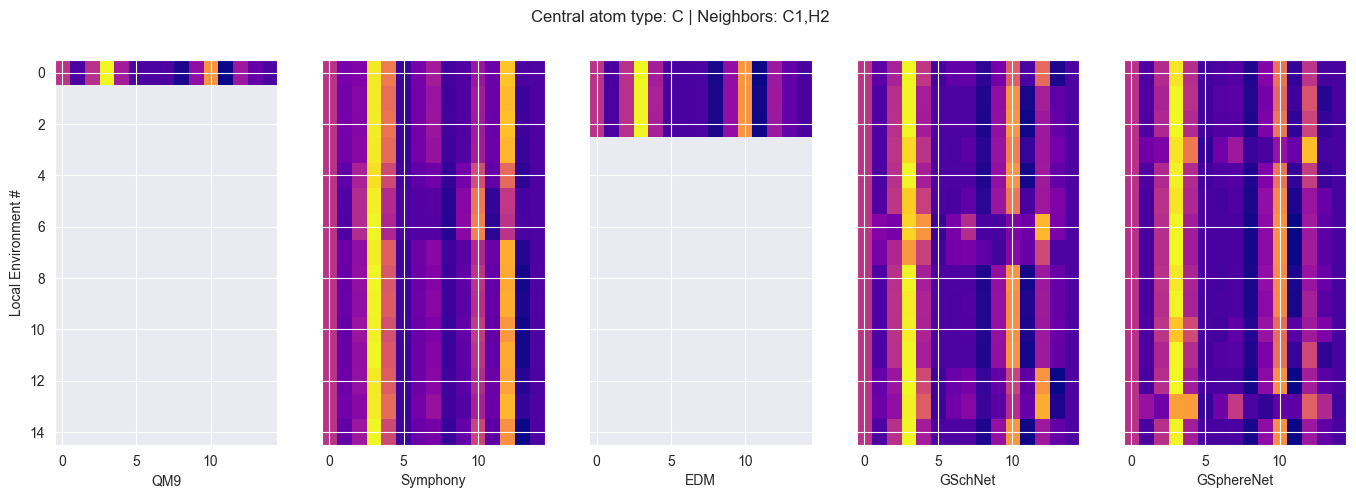

In [14]:
for environment, _ in sorted(bispectra["QM9"].items(), key=lambda x: len(x[1]), reverse=True):
    num_models = len(bispectra)
    # Set color scheme as plasma
    plt.rcParams['image.cmap'] = 'plasma'
    fig, axs = plt.subplots(ncols=num_models, figsize=(10 * num_models / 3, 5), sharey=True)
    
    for index, (model, model_bispectra) in enumerate(bispectra.items()):
        try:
            axs[index].imshow(model_bispectra[environment], aspect='auto')
            axs[index].set_xlabel(model)
        except KeyError:
            pass

    central_atom_type, neighbors = environment
    fig.suptitle(f"Central atom type: {central_atom_type} | Neighbors: {neighbors}")
    axs[0].set_ylabel("Local Environment #")
    plt.show()

MMD (Maximum Mean Discrepancy) of Bispectra:

In [15]:
rng = jax.random.PRNGKey(0)
batch_size = 1000
num_batches = 10

mmd_bispectra = {
    model: compute_maximum_mean_discrepancies(bispectra["QM9"], model_bispectra, rng, batch_size, num_batches)
    for model, model_bispectra in bispectra.items()
    if model != "QM9"
}

In [16]:
qm9_local_environments_count = {environment: len(bispectra["QM9"][environment]) for environment in bispectra["QM9"]}
qm9_local_environments_count = dict(sorted(qm9_local_environments_count.items(), key=lambda x: qm9_local_environments_count[x[0]], reverse=True))
sorted_qm9_valid_local_environments_counts = {environment: count for environment, count in qm9_local_environments_count.items() if "," in environment[-1]}
sorted_qm9_valid_local_environments_counts

{('C', 'C2,H2'): 1008,
 ('C', 'C1,H3'): 719,
 ('C', 'C3,H1'): 625,
 ('C', 'C2,H1,O1'): 498,
 ('C', 'C1,H2,O1'): 394,
 ('O', 'C1,H1'): 387,
 ('C', 'C2,H1,N1'): 332,
 ('C', 'C2,H1'): 289,
 ('C', 'C1,H2,N1'): 256,
 ('N', 'C2,H1'): 228,
 ('C', 'C3,O1'): 206,
 ('C', 'C1,N1,O1'): 162,
 ('C', 'C1,N1'): 153,
 ('C', 'C2,O1'): 143,
 ('C', 'C1,H1,O1'): 138,
 ('N', 'C1,H2'): 111,
 ('C', 'C1,H1,N1'): 110,
 ('C', 'C1,H1'): 109,
 ('C', 'C3,N1'): 103,
 ('C', 'C2,N1'): 90,
 ('C', 'C1,N2'): 85,
 ('N', 'C1,H1'): 79,
 ('C', 'H3,O1'): 74,
 ('C', 'H3,N1'): 71,
 ('N', 'C1,N1'): 70,
 ('C', 'C1,O2'): 56,
 ('C', 'H1,N1,O1'): 50,
 ('C', 'N2,O1'): 41,
 ('C', 'H1,N2'): 35,
 ('N', 'C1,O1'): 32,
 ('O', 'C1,N1'): 28,
 ('C', 'N1,O2'): 22,
 ('N', 'C1,H1,N1'): 22,
 ('N', 'C2,N1'): 20,
 ('N', 'N1,O1'): 12,
 ('C', 'H2,O2'): 12,
 ('C', 'C1,H1,O2'): 12,
 ('C', 'H1,O2'): 10,
 ('C', 'C2,F1'): 10,
 ('O', 'H1,N1'): 9,
 ('N', 'C1,N2'): 4,
 ('C', 'C2,O2'): 4,
 ('N', 'H1,N2'): 4,
 ('C', 'C1,F1,N1'): 4,
 ('C', 'C1,F3'): 2,
 ('C', '

In [17]:
# Make a dataframe for each model, indicating the bond type and the MMD.
def environment_as_string(environment: Tuple[str, str]) -> str:
    """Converts an environment to a string."""
    return f"{environment[0]}: {environment[1]}"

mmd_bispectra_df = pd.DataFrame(columns=["model", "environment", "mmd"])
for environment, _ in list(sorted_qm9_valid_local_environments_counts.items())[:10]:
    for model in mmd_bispectra:
        mmd_bispectra_df = pd.concat(
            [
                mmd_bispectra_df,
                pd.DataFrame.from_records(
                    {"model": model, "environment": [environment_as_string(environment)], "mmd": mmd_bispectra[model][environment]}
                ),
            ],
            ignore_index=True,
        )
        
mmd_bispectra_df["mmd"] = mmd_bispectra_df["mmd"].astype(float)
mmd_bispectra_df

model  environment           mmd
0     Symphony     C: C2,H2  9.523255e-02
1          EDM     C: C2,H2  4.737828e-03
2      GSchNet     C: C2,H2  3.100792e-01
3   GSphereNet     C: C2,H2  3.865398e-01
4     Symphony     C: C1,H3  3.377671e-01
5          EDM     C: C1,H3 -1.105762e-07
6      GSchNet     C: C1,H3  7.068568e-03
7   GSphereNet     C: C1,H3  1.440677e+00
8     Symphony     C: C3,H1  3.375428e-02
9          EDM     C: C3,H1  3.153033e-02
10     GSchNet     C: C3,H1  2.893695e-02
11  GSphereNet     C: C3,H1  1.257411e+00
12    Symphony  C: C2,H1,O1  1.200051e-01
13         EDM  C: C2,H1,O1  2.859484e-02
14     GSchNet  C: C2,H1,O1  5.958405e-02
15  GSphereNet  C: C2,H1,O1  7.001591e-01
16    Symphony  C: C1,H2,O1  3.548487e-01
17         EDM  C: C1,H2,O1  2.283760e-02
18     GSchNet  C: C1,H2,O1  7.038876e-03
19  GSphereNet  C: C1,H2,O1  2.816065e+00
20    Symphony     O: C1,H1  2.842750e-03
21         EDM     O: C1,H1 -2.699907e-05
22     GSchNet     O: C1,H1  1.410111e-03
23  GSphereNet     O: C1,H1 -3.097116e-05
24    Symphony  C: C2,H1,N1  6.831521e-02
25         EDM  C: C2,H1,N1  3.180233e-02
26     GSchNet  C: C2,H1,N1  3.423580e-02
27  GSphereNet  C: C2,H1,N1  1.813413e+00
28    Symphony     C: C2,H1  7.319932e-02
29         EDM     C: C2,H1  4.105702e-04
30     GSchNet     C: C2,H1  6.105357e-02
31  GSphereNet     C: C2,H1  5.796614e-02
32    Symphony  C: C1,H2,N1  1.208196e-01
33         EDM  C: C1,H2,N1  2.699552e-02
34     GSchNet  C: C1,H2,N1  8.050392e-03
35  GSphereNet  C: C1,H2,N1  8.443366e-01
36    Symphony     N: C2,H1  1.077931e-01
37         EDM     N: C2,H1  2.282978e-02
38     GSchNet     N: C2,H1  4.888104e-02
39  GSphereNet     N: C2,H1  3.778595e-01

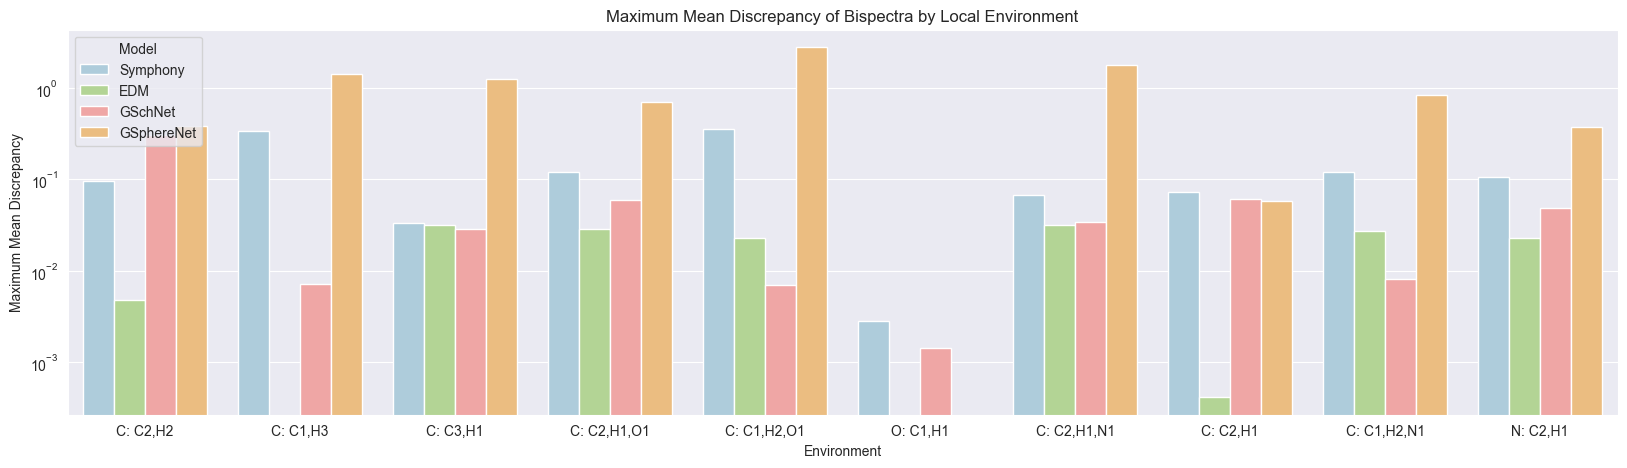

In [18]:
# Make a bar plot of the MMD values for each model, by bond_key.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="environment", y="mmd", hue="model", data=mmd_bispectra_df, ax=ax, palette=model_palette)
plt.xlabel("Environment")
plt.ylabel("Maximum Mean Discrepancy")
plt.yscale("log")
plt.legend(title="Model", loc="upper left")
plt.title("Maximum Mean Discrepancy of Bispectra by Local Environment")
plt.show()

Compute all bond lengths:

In [19]:
bond_dists = {
    model: compute_bond_lengths(molecules)
    for model, molecules in valid_molecules.items()
}

Distribution of Bond Lengths:

In [20]:
qm9_bond_counts = jax.tree_map(np.size, bond_dists["QM9"])
sorted_qm9_bond_counts = dict(sorted(
    qm9_bond_counts.items(), key=lambda x: x[1], reverse=True
))

print("Bond counts in QM9:")
total_counts = sum(qm9_bond_counts.values())
sum_counts_so_far = 0
for bond_key, count in sorted_qm9_bond_counts.items():
    sum_counts_so_far += count
    print(f"{bond_key }: {count} (cdf: {sum_counts_so_far / total_counts:.3f})")

Bond counts in QM9:
('C', 'H', 1.0): 1103196 (cdf: 0.444)
('C', 'C', 1.0): 662158 (cdf: 0.710)
('C', 'O', 1.0): 188304 (cdf: 0.786)
('C', 'N', 1.0): 139383 (cdf: 0.842)
('H', 'N', 1.0): 73049 (cdf: 0.872)
('C', 'O', 2.0): 55898 (cdf: 0.894)
('C', 'N', 1.5): 55247 (cdf: 0.917)
('H', 'O', 1.0): 52204 (cdf: 0.938)
('C', 'C', 1.5): 43463 (cdf: 0.955)
('C', 'N', 2.0): 20618 (cdf: 0.963)
('C', 'C', 3.0): 19497 (cdf: 0.971)
('C', 'C', 2.0): 17987 (cdf: 0.978)
('C', 'N', 3.0): 17475 (cdf: 0.985)
('C', 'O', 1.5): 14893 (cdf: 0.991)
('N', 'N', 1.5): 10793 (cdf: 0.996)
('N', 'O', 1.5): 4825 (cdf: 0.998)
('C', 'F', 1.0): 3296 (cdf: 0.999)
('N', 'O', 1.0): 2038 (cdf: 1.000)
('N', 'O', 2.0): 177 (cdf: 1.000)
('N', 'N', 3.0): 112 (cdf: 1.000)
('N', 'N', 2.0): 53 (cdf: 1.000)
('N', 'N', 1.0): 16 (cdf: 1.000)


Maximum Mean Discrepancy of Bond Lengths:

In [21]:
rng = jax.random.PRNGKey(0)
batch_size = 1000
num_batches = 10

mmd_bond_lengths = {
    model: compute_maximum_mean_discrepancies(bond_dists["QM9"], model_bond_dists, rng, batch_size, num_batches)
    for model, model_bond_dists in bond_dists.items()
    if model != "QM9"
}

In [25]:
# Make a dataframe for each model, indicating the bond type and the MMD.
def bond_key_as_string(bond_key: Tuple[int, int, int]) -> str:
    return f"{bond_key[0]}-{bond_key[1]}: {bond_key[2]}"

mmd_bond_lengths_df = pd.DataFrame(columns=["model", "bond_key", "mmd"])
for bond_key, _ in list(sorted_qm9_bond_counts.items())[:10]:
    for model in mmd_bond_lengths:
        mmd_bond_lengths_df = pd.concat(
            [
                mmd_bond_lengths_df,
                pd.DataFrame.from_records(
                    {"model": model, "bond_key": [bond_key_as_string(bond_key)], "mmd": mmd_bond_lengths[model][bond_key]}
                ),
            ],
            ignore_index=True,
        )

mmd_bond_lengths_df["mmd"] = mmd_bond_lengths_df["mmd"].astype(float)
mmd_bond_lengths_df

model  bond_key       mmd
0     Symphony  C-H: 1.0  1.391868
1          EDM  C-H: 1.0  0.005720
2      GSchNet  C-H: 1.0  0.167373
3   GSphereNet  C-H: 1.0  0.017910
4     Symphony  C-C: 1.0  0.828580
5          EDM  C-C: 1.0  0.011925
6      GSchNet  C-C: 1.0  0.066032
7   GSphereNet  C-C: 1.0  1.105812
8     Symphony  C-O: 1.0  0.416261
9          EDM  C-O: 1.0  0.005920
10     GSchNet  C-O: 1.0  0.243148
11  GSphereNet  C-O: 1.0  0.372556
12    Symphony  C-N: 1.0  0.761259
13         EDM  C-N: 1.0  0.029595
14     GSchNet  C-N: 1.0  0.100293
15  GSphereNet  C-N: 1.0  0.185313
16    Symphony  H-N: 1.0  0.656471
17         EDM  H-N: 1.0  0.011712
18     GSchNet  H-N: 1.0  0.358507
19  GSphereNet  H-N: 1.0  0.027661
20    Symphony  C-O: 2.0  0.979684
21         EDM  C-O: 2.0  0.006059
22     GSchNet  C-O: 2.0  0.089567
23  GSphereNet  C-O: 2.0  4.336888
24    Symphony  C-N: 1.5  0.442173
25         EDM  C-N: 1.5  0.024551
26     GSchNet  C-N: 1.5  0.305876
27  GSphereNet  C-N: 1.5  0.246141
28    Symphony  H-O: 1.0  2.141715
29         EDM  H-O: 1.0  0.022064
30     GSchNet  H-O: 1.0  0.613178
31  GSphereNet  H-O: 1.0  0.017345
32    Symphony  C-C: 1.5  0.574960
33         EDM  C-C: 1.5  0.018104
34     GSchNet  C-C: 1.5  0.072198
35  GSphereNet  C-C: 1.5  0.736883
36    Symphony  C-N: 2.0  1.780967
37         EDM  C-N: 2.0  0.076792
38     GSchNet  C-N: 2.0  0.343527
39  GSphereNet  C-N: 2.0  4.494829

We have everything we need for the table:

In [26]:
def flatten_dict(d: Dict) -> Dict:
    return {
        (key, subkey): value
        for key in d
        for subkey, value in d[key].items()
    }

local_environments_flattened = {
    model: flatten_dict(local_environments[model])
    for model in local_environments
}


def make_jsd_df(counts, index: str) -> pd.DataFrame:
    jsd = {}
    for model in counts:
        if model == "QM9":
            continue
        jsd[model] = [compute_jensen_shannon_divergence(counts["QM9"], counts[model])]
    return pd.DataFrame.from_records(jsd, columns=["Symphony", "EDM", "GSchNet", "GSphereNet"], index=[index])


def reshape_mmd_bond_lengths_df(mmd_bond_lengths_df):
    mmd_bond_lengths_df = mmd_bond_lengths_df.pivot(index="bond_key", columns="model", values="mmd")
    mmd_bond_lengths_df = mmd_bond_lengths_df[["Symphony", "EDM", "GSchNet", "GSphereNet"]]
    sorted_qm9_bond_counts_formatted = {bond_key_as_string(key): value for key, value in sorted_qm9_bond_counts.items()}
    mmd_bond_lengths_df = mmd_bond_lengths_df.sort_index(ascending=False, key=lambda keys: [sorted_qm9_bond_counts_formatted[key] for key in keys])
    mmd_bond_lengths_df.index = mmd_bond_lengths_df.index.map(lambda x: f"MMD for Bond {x}")
    return mmd_bond_lengths_df


def reshape_mmd_bispectra_df(mmd_bispectra_df):
    mmd_bispectra_df = mmd_bispectra_df.pivot(index="environment", columns="model", values="mmd")
    mmd_bispectra_df = mmd_bispectra_df[["Symphony", "EDM", "GSchNet", "GSphereNet"]]
    sorted_qm9_local_environments_formatted = {environment_as_string(key): value for key, value in sorted_qm9_valid_local_environments_counts.items()}
    mmd_bispectra_df = mmd_bispectra_df.sort_index(ascending=False, key=lambda keys: [sorted_qm9_local_environments_formatted[key] for key in keys])
    mmd_bispectra_df.index = mmd_bispectra_df.index.map(lambda x: f"MMD for Local Environment {x}")
    return mmd_bispectra_df


mmd_and_jsd_df = pd.concat([
    make_jsd_df(atom_type_counts, "Atom Type JSD"),
    make_jsd_df(local_environments_flattened, "Local Environment JSD"),
    reshape_mmd_bond_lengths_df(mmd_bond_lengths_df),
    reshape_mmd_bispectra_df(mmd_bispectra_df),
])
print(mmd_and_jsd_df.applymap(lambda x: f"\\num{{{x:.2e}}}").style.to_latex())

\begin{tabular}{lllll}
 & Symphony & EDM & GSchNet & GSphereNet \\
Atom Type JSD & \num{1.64e-03} & \num{1.63e-04} & \num{6.73e-04} & \num{2.61e-03} \\
Local Environment JSD & \num{4.16e+02} & \num{8.22e+01} & \num{2.14e+02} & \num{2.27e+03} \\
MMD for Bond C-H: 1.0 & \num{1.39e+00} & \num{5.72e-03} & \num{1.67e-01} & \num{1.79e-02} \\
MMD for Bond C-C: 1.0 & \num{8.29e-01} & \num{1.19e-02} & \num{6.60e-02} & \num{1.11e+00} \\
MMD for Bond C-O: 1.0 & \num{4.16e-01} & \num{5.92e-03} & \num{2.43e-01} & \num{3.73e-01} \\
MMD for Bond C-N: 1.0 & \num{7.61e-01} & \num{2.96e-02} & \num{1.00e-01} & \num{1.85e-01} \\
MMD for Bond H-N: 1.0 & \num{6.56e-01} & \num{1.17e-02} & \num{3.59e-01} & \num{2.77e-02} \\
MMD for Bond C-O: 2.0 & \num{9.80e-01} & \num{6.06e-03} & \num{8.96e-02} & \num{4.34e+00} \\
MMD for Bond C-N: 1.5 & \num{4.42e-01} & \num{2.46e-02} & \num{3.06e-01} & \num{2.46e-01} \\
MMD for Bond H-O: 1.0 & \num{2.14e+00} & \num{2.21e-02} & \num{6.13e-01} & \num{1.73e-02} \\
MMD for Bon

/Users/ameyad/Documents/spherical-harmonic-net/analyses/../analyses/metrics.py:102: RuntimeWarning: divide by zero encountered in log
  log_p = np.where(p > 0, np.log(p), 0)


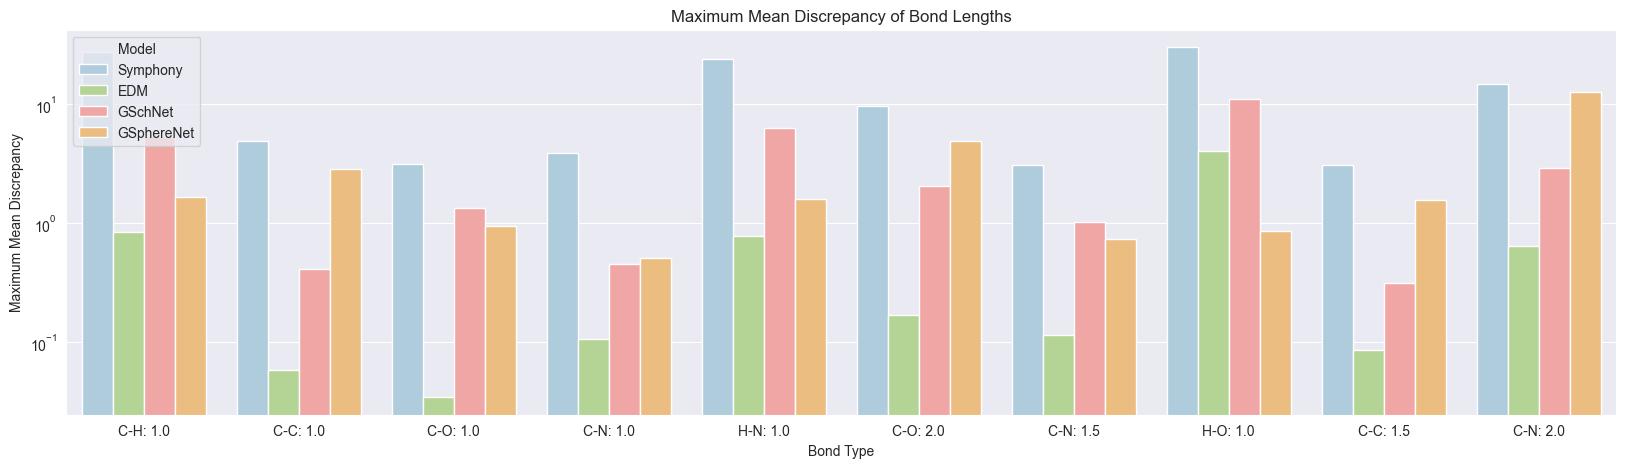

In [ ]:
# Make a bar plot of the MMD values for each model, by bond_key.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="bond_key", y="mmd", hue="model", data=mmd_bond_lengths_df, ax=ax,
            palette=model_palette)
plt.xlabel("Bond Type")
plt.ylabel("Maximum Mean Discrepancy")
plt.yscale("log")
plt.legend(title="Model", loc="upper left")
plt.title("Maximum Mean Discrepancy of Bond Lengths")
plt.show()

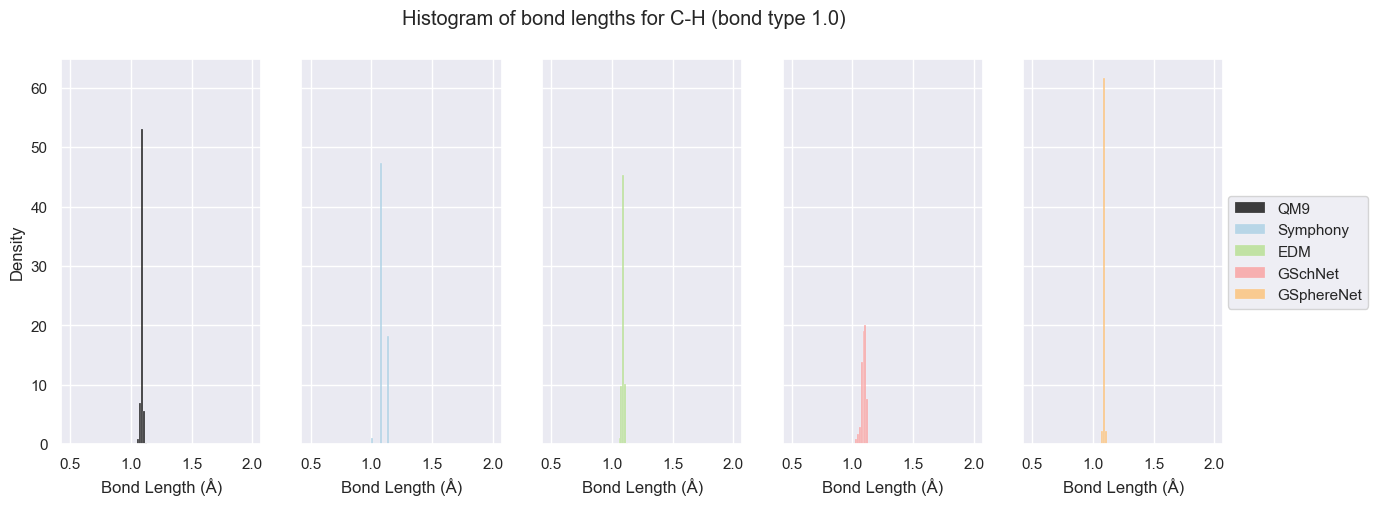

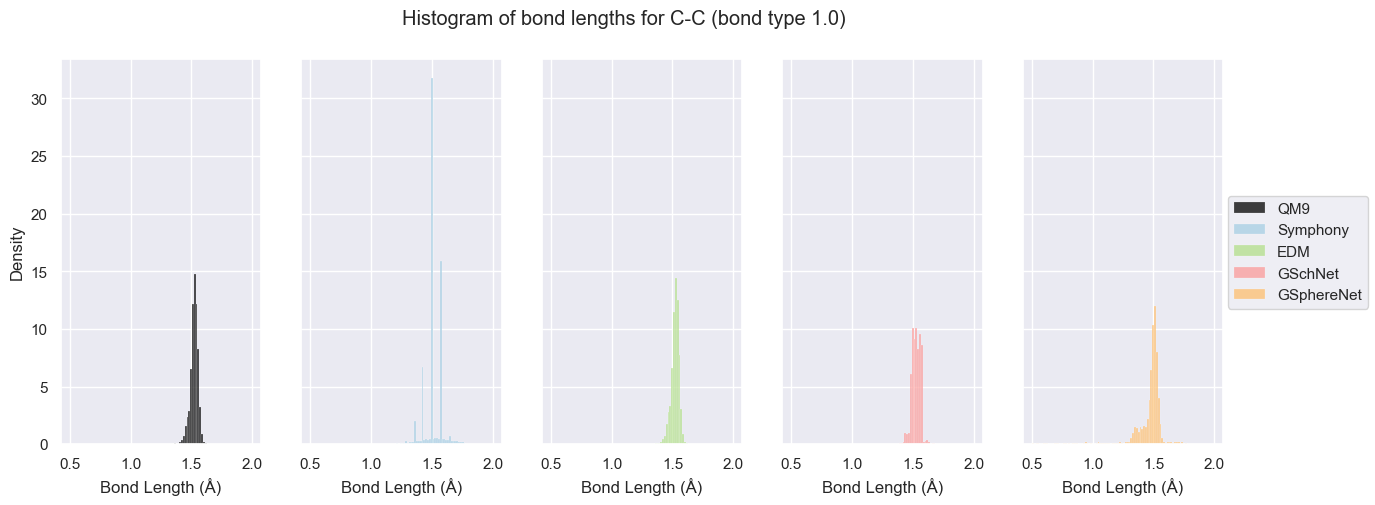

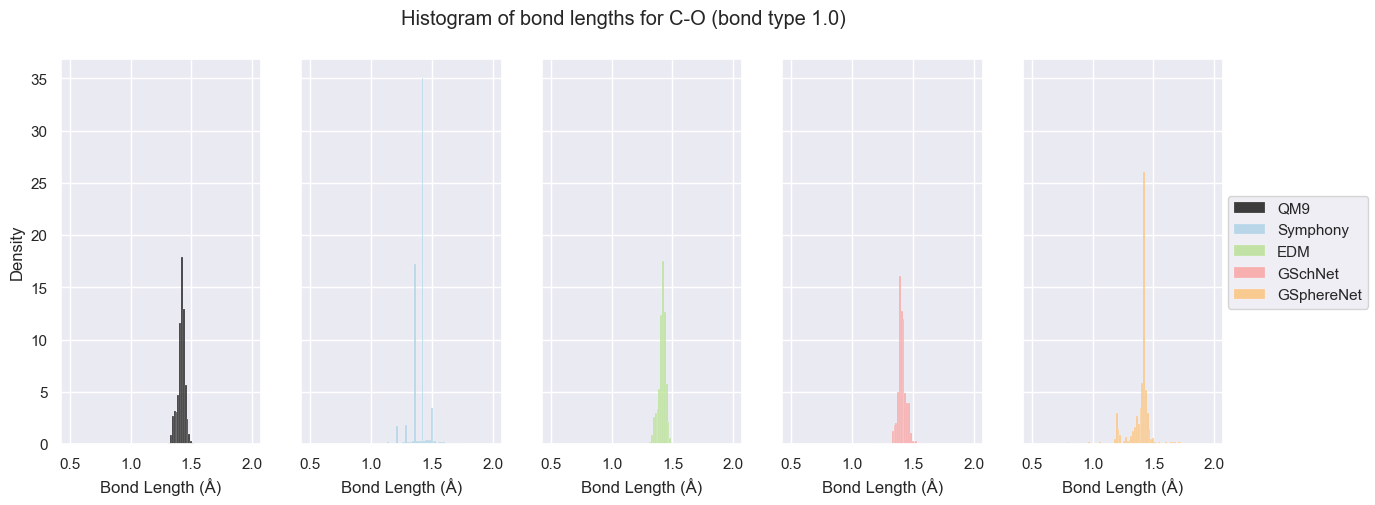

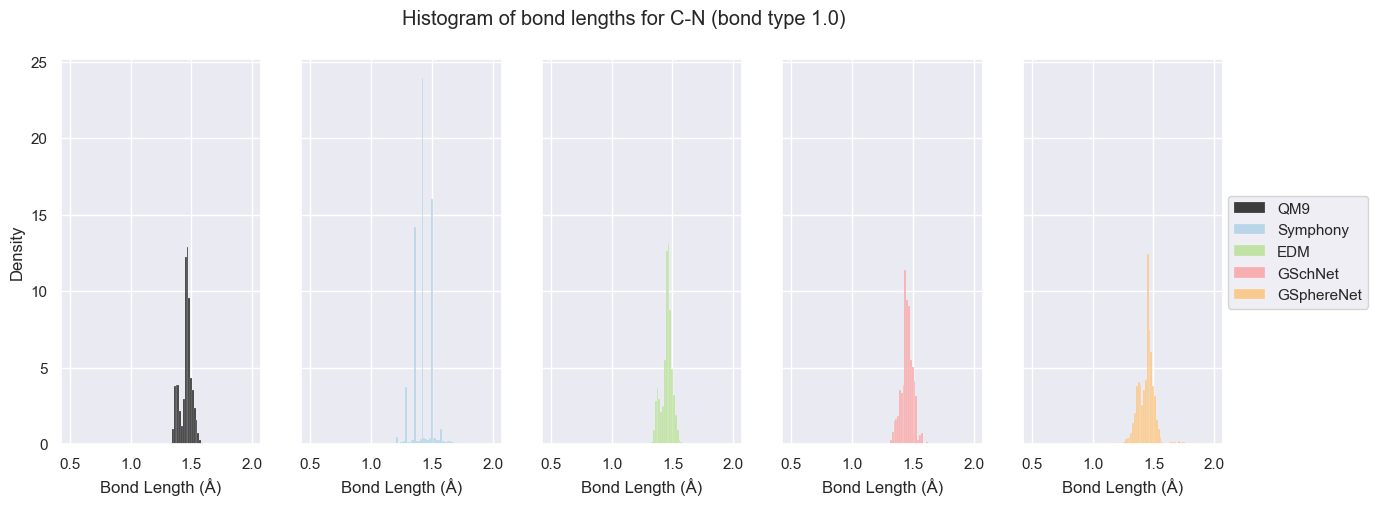

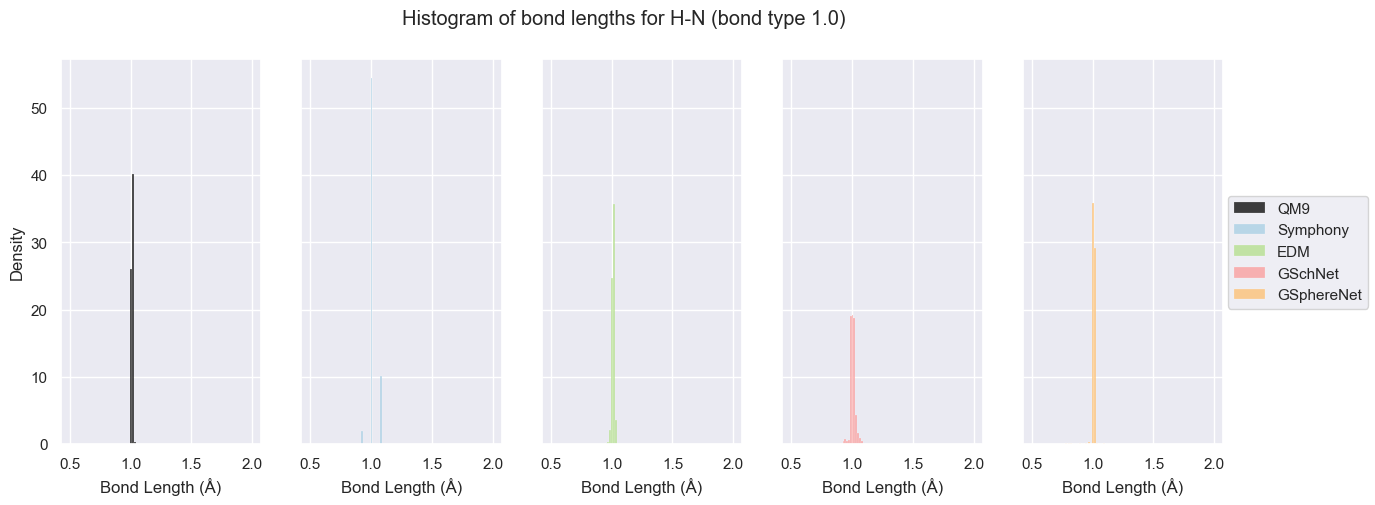

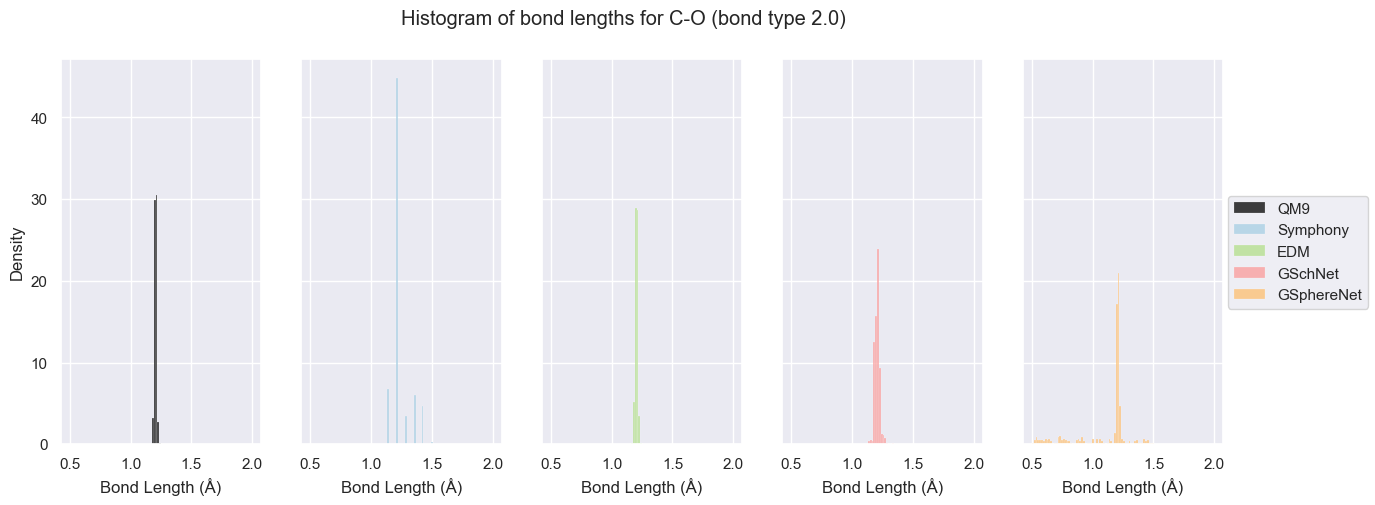

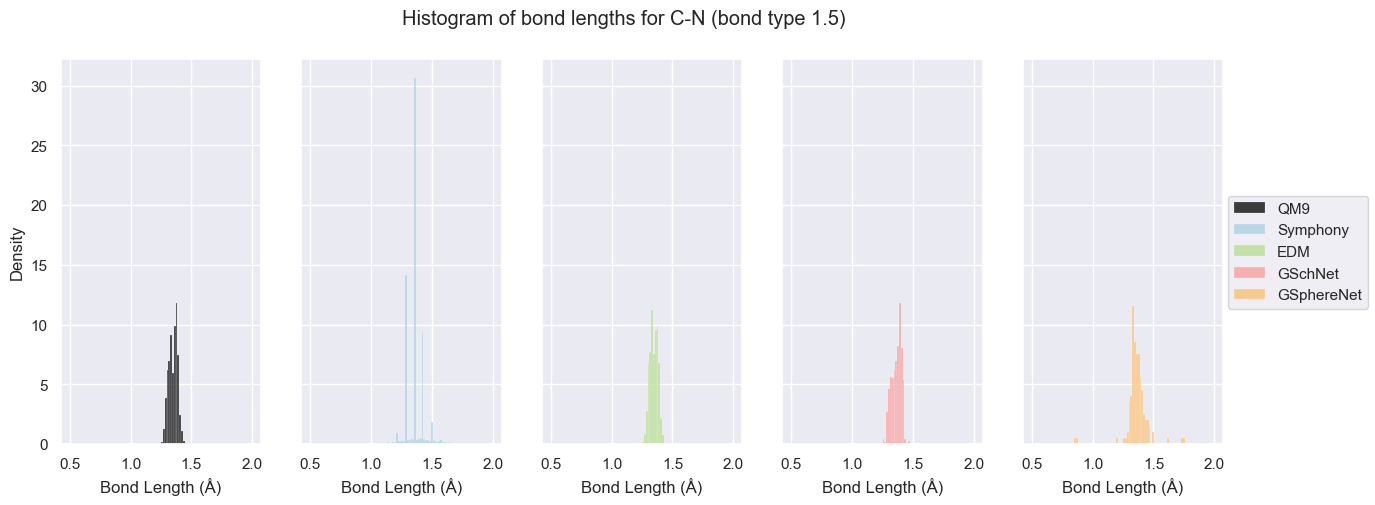

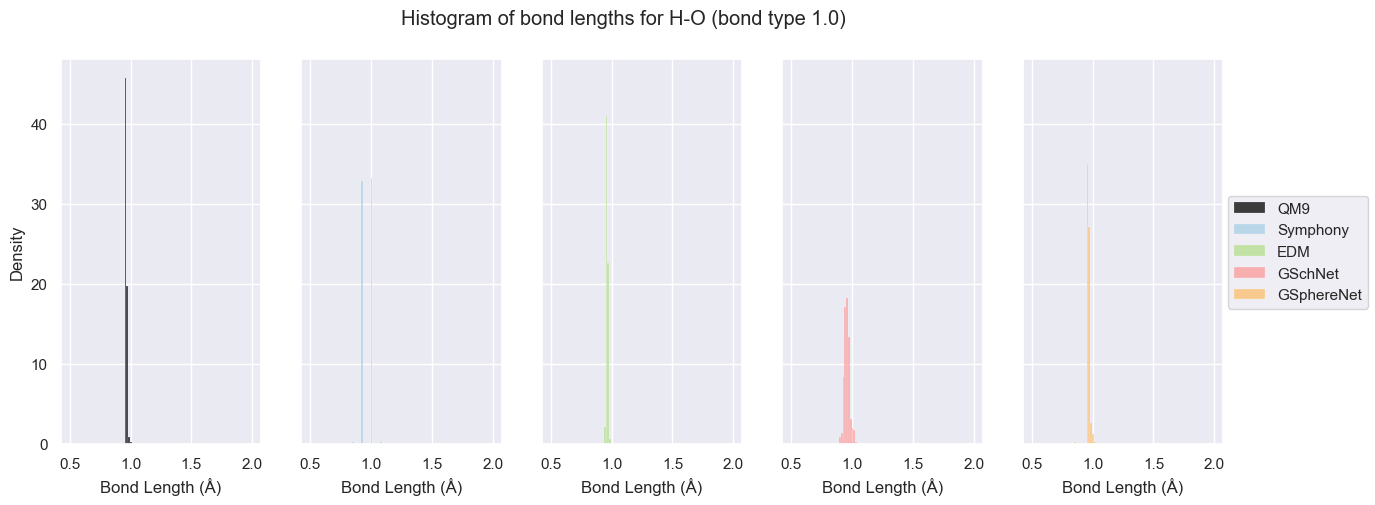

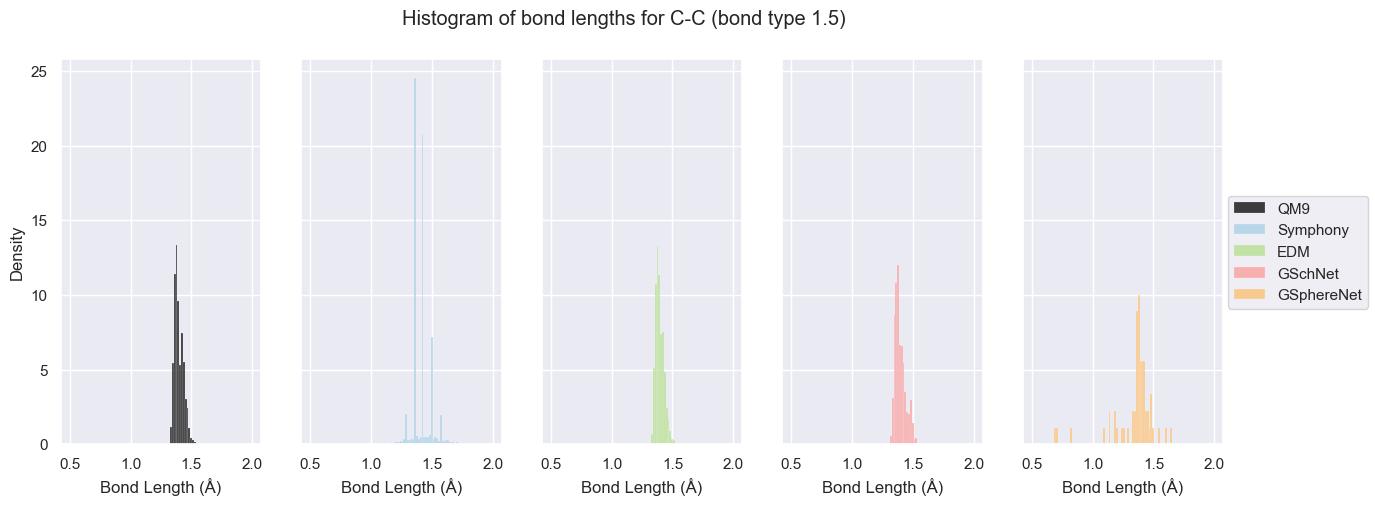

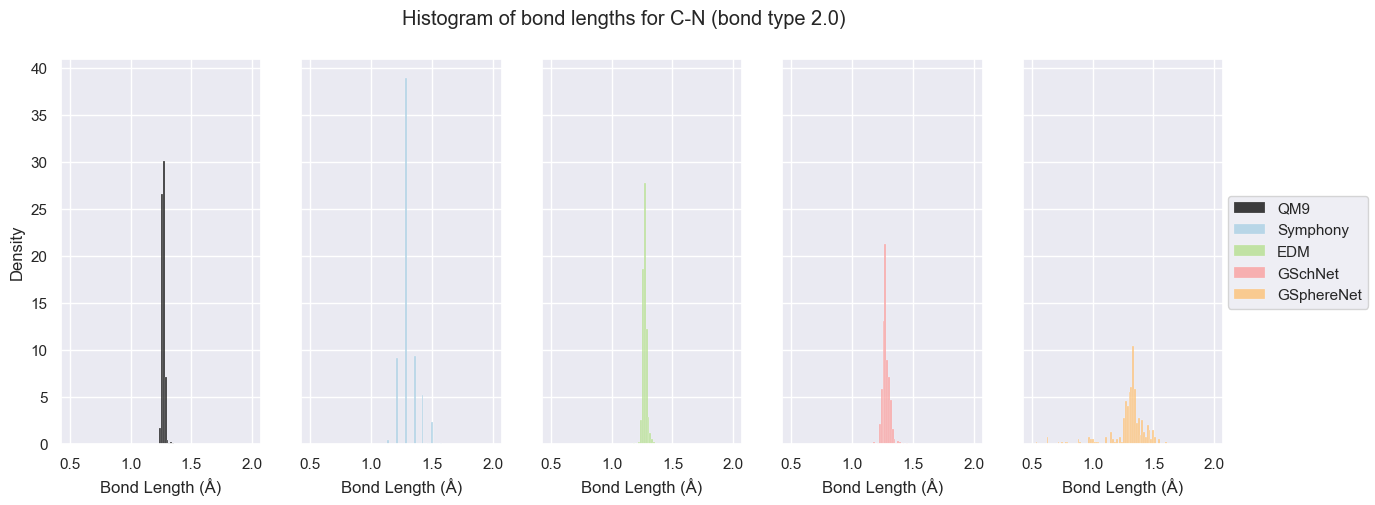

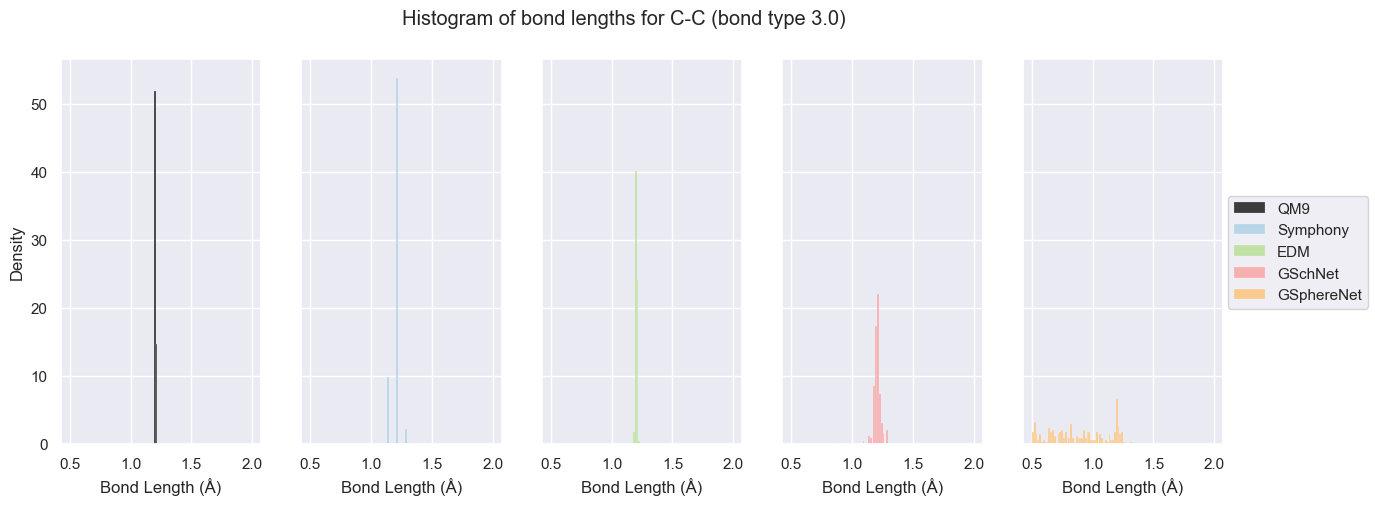

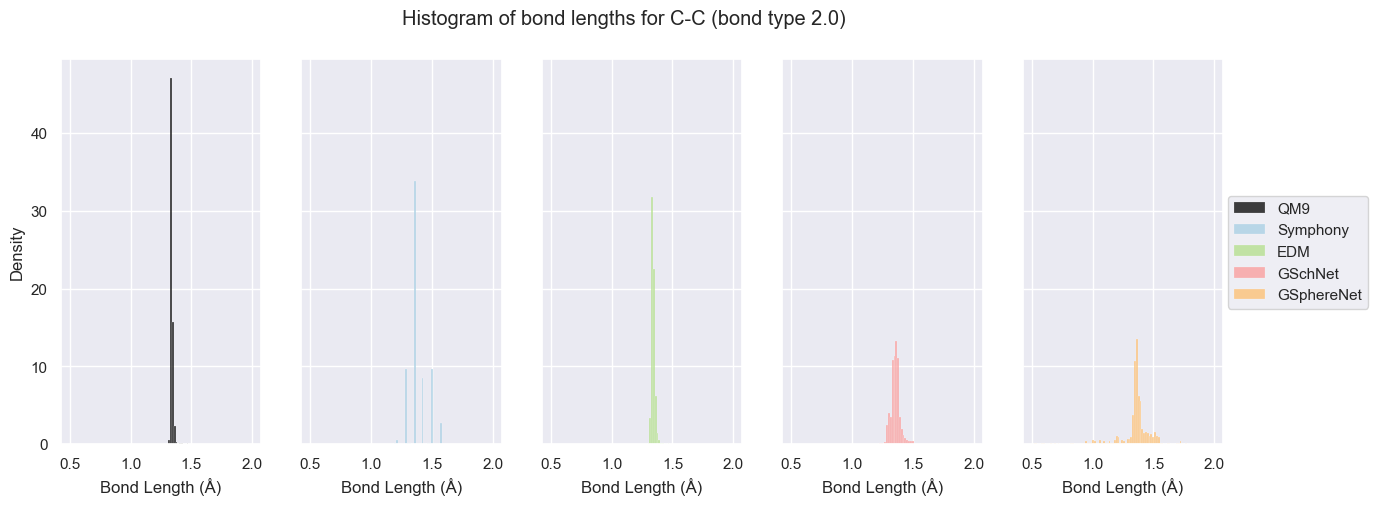

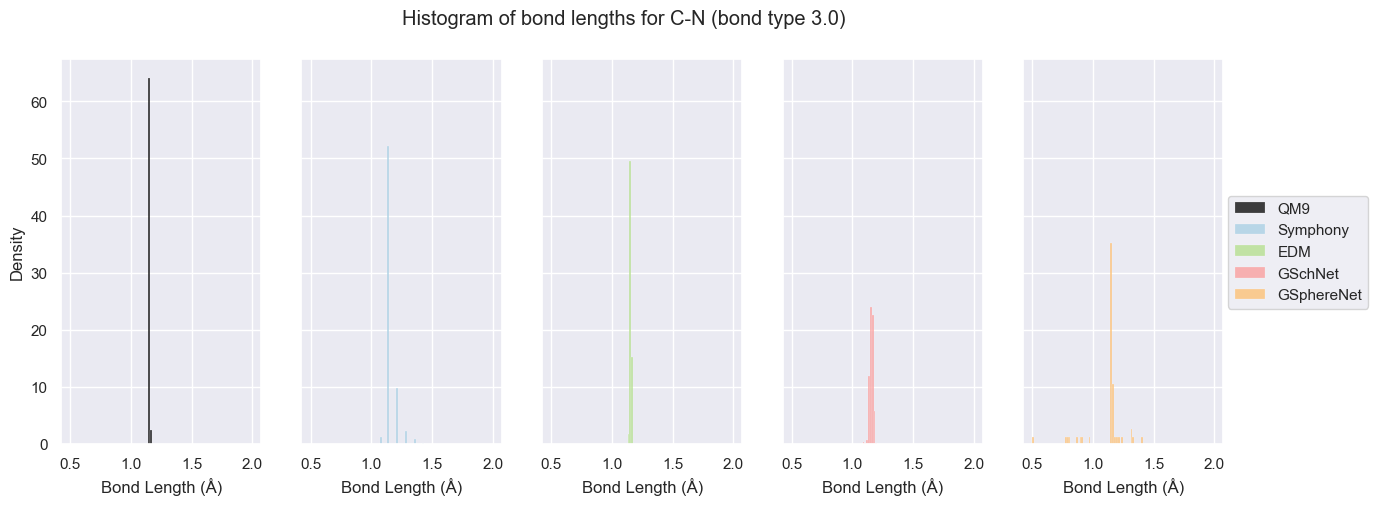

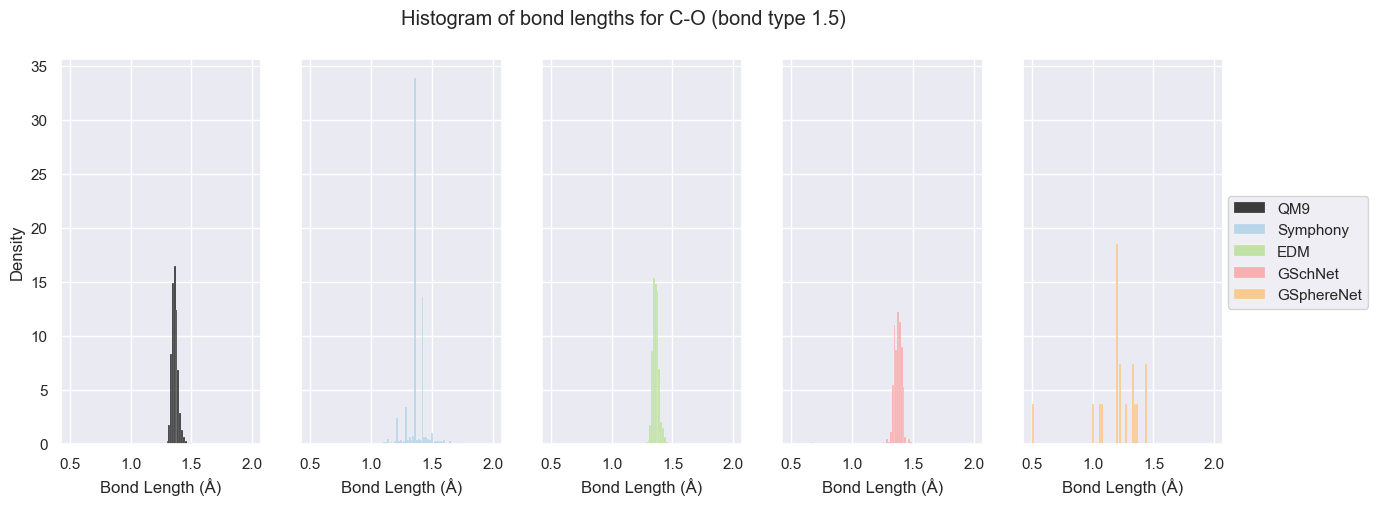

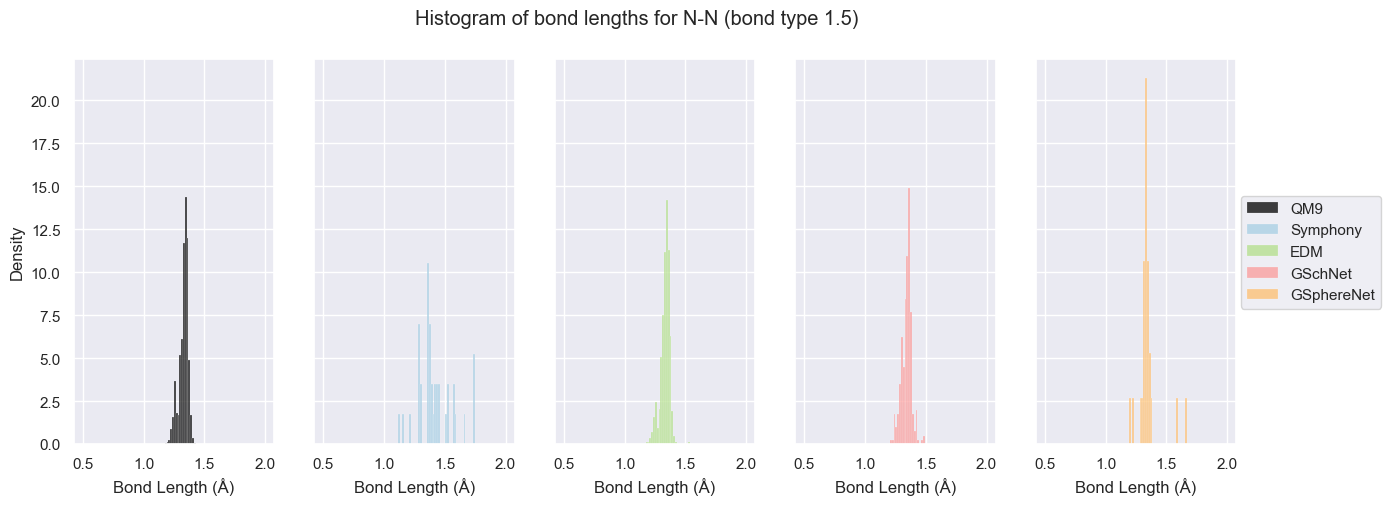

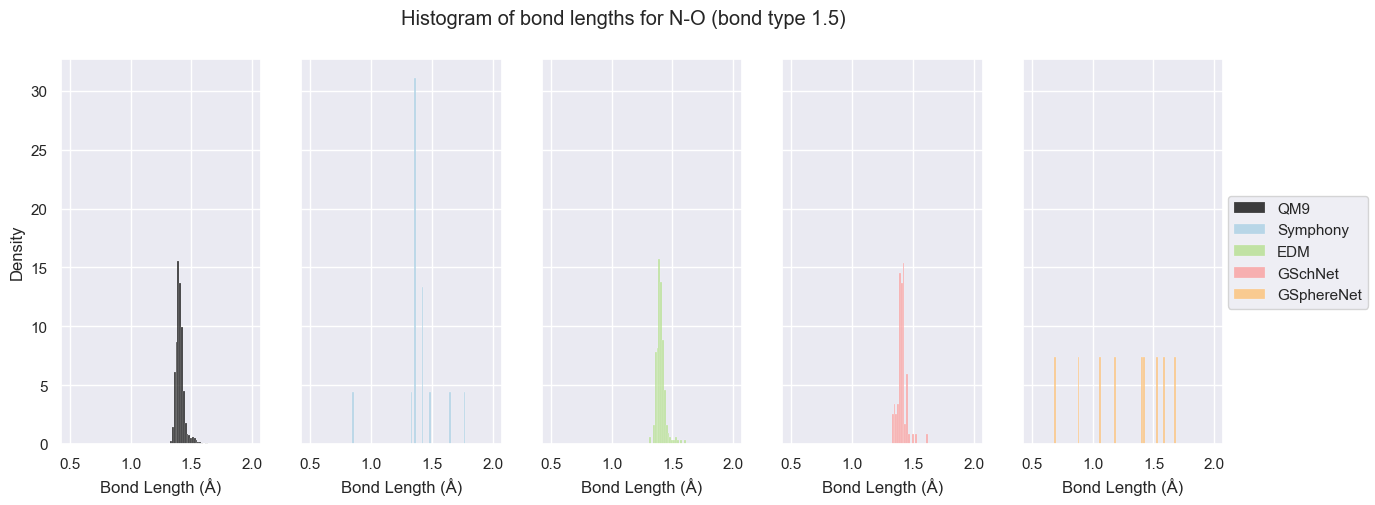

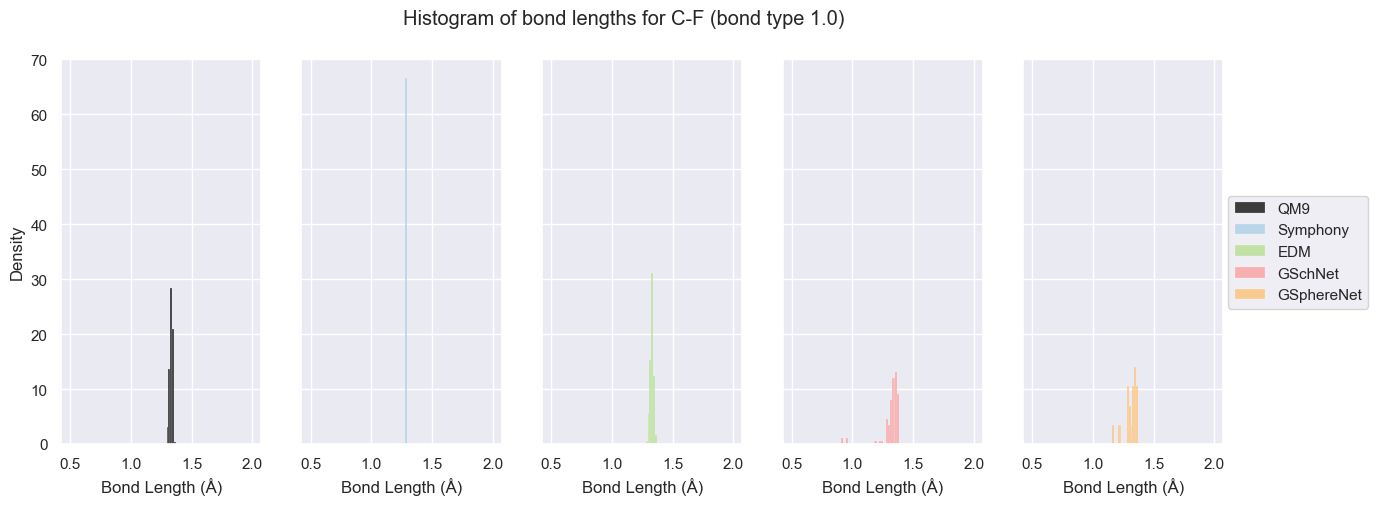

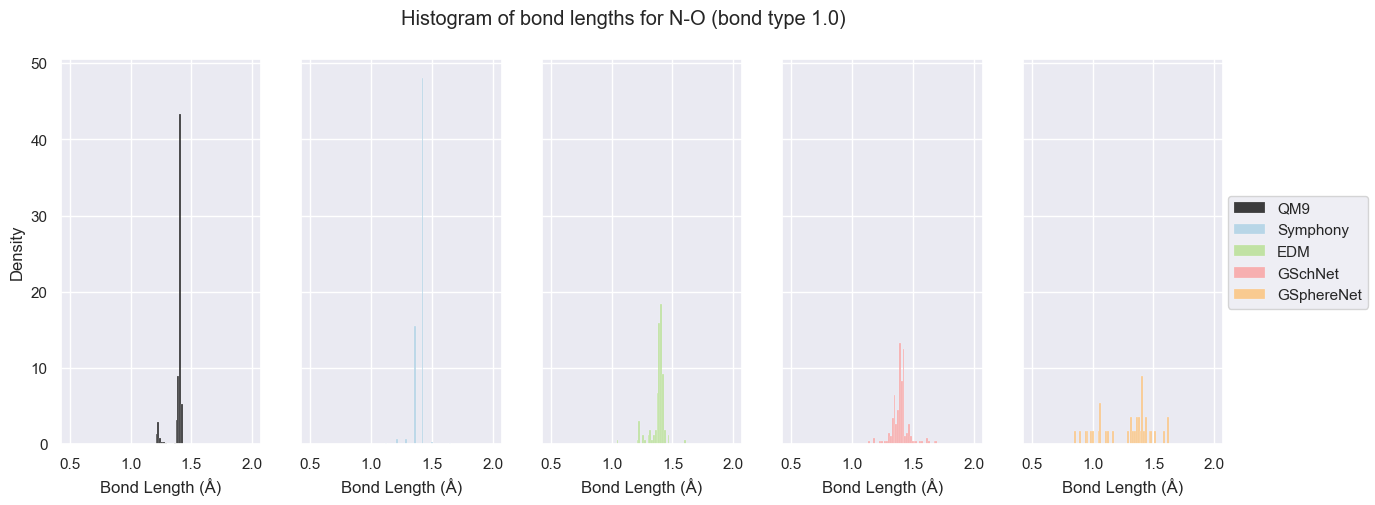

KeyError: ('N', 'O', 2.0)

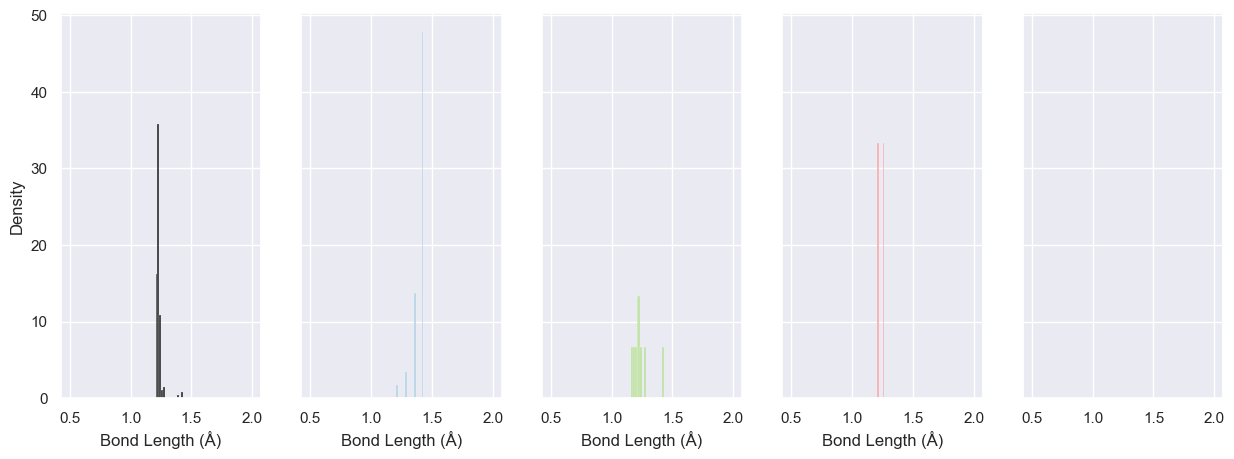

In [28]:
sns.set_theme(style="darkgrid")
for bond_key, _ in sorted_qm9_bond_counts.items():
    num_models = len(bond_dists)
    fig, axs = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 5), sharex=True, sharey=True)
    for index, model in enumerate(bond_dists):
        sns.histplot(
            bond_dists[model][bond_key],
            label=model,
            stat="density",
            color=model_palette[model],
            bins=100,
            binrange=(0.5, 2.0),
            ax=axs[index],
        )
        axs[index].set_xlabel("Bond Length (Å)")

    atom_type_1, atom_type_2, bond_type = bond_key
    fig.suptitle(
        f"Histogram of bond lengths for {atom_type_1}-{atom_type_2} (bond type {bond_type})"
    )
    fig.legend(loc="center right")
    plt.show()

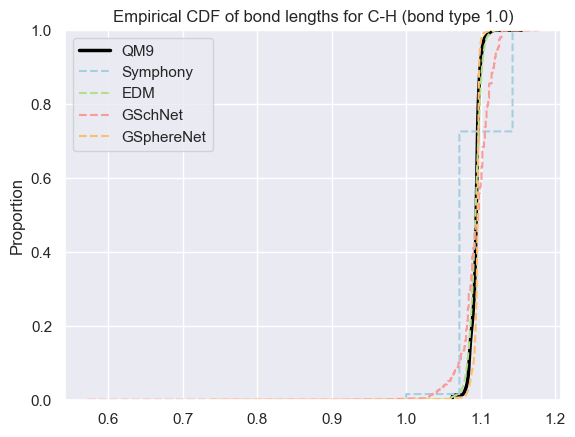

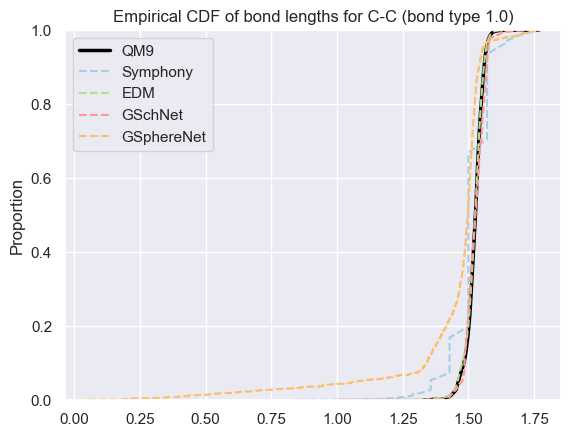

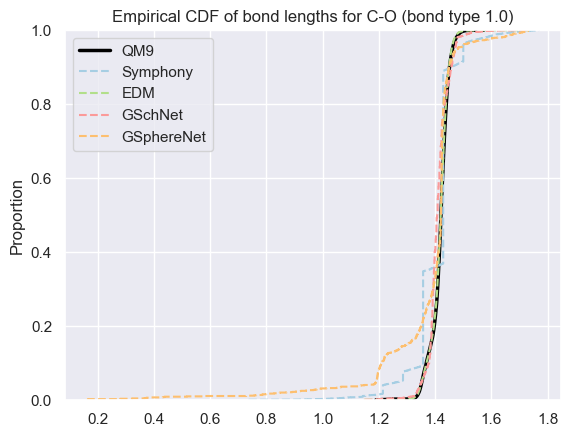

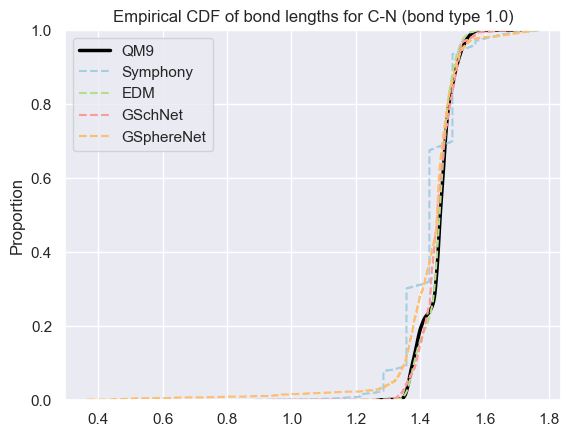

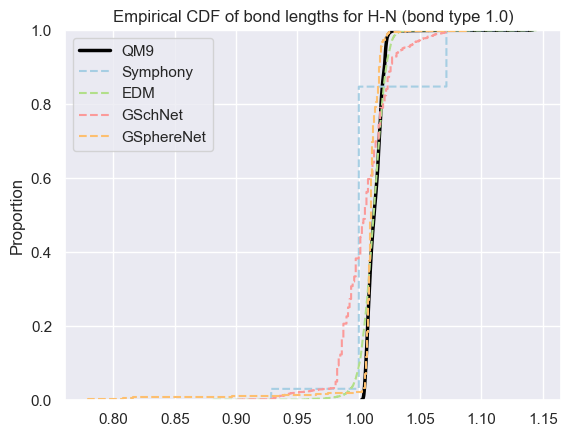

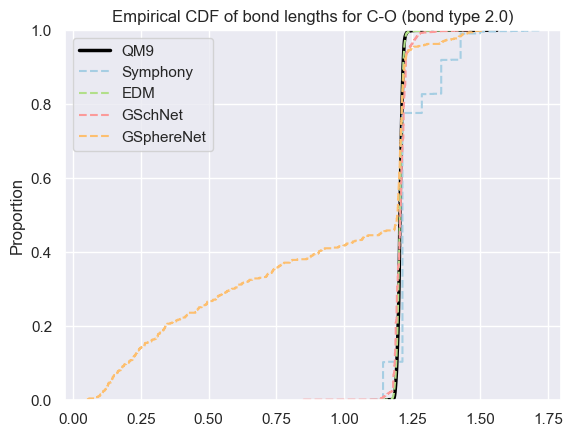

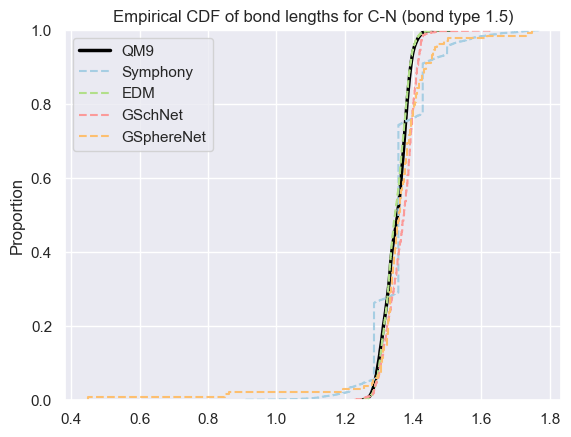

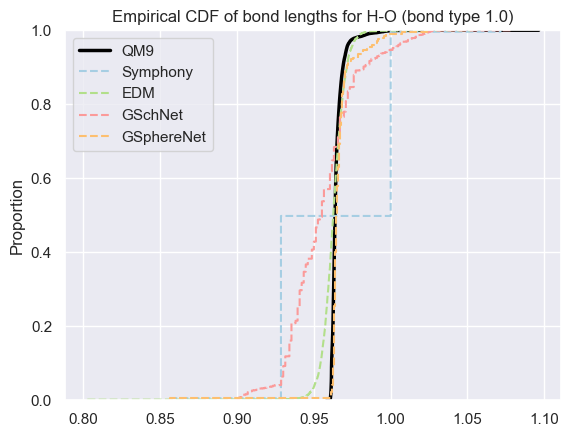

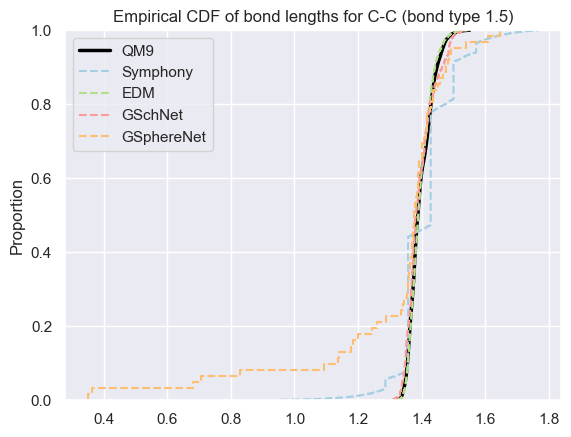

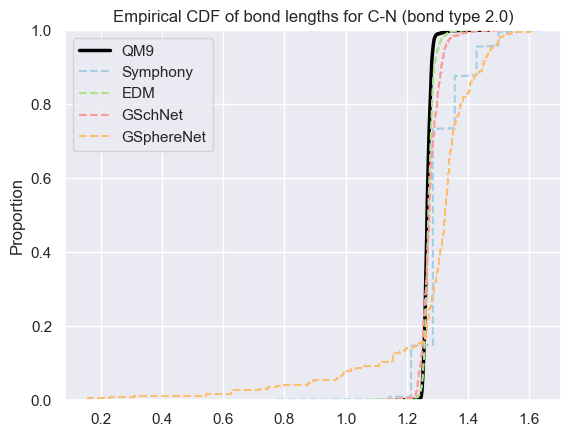

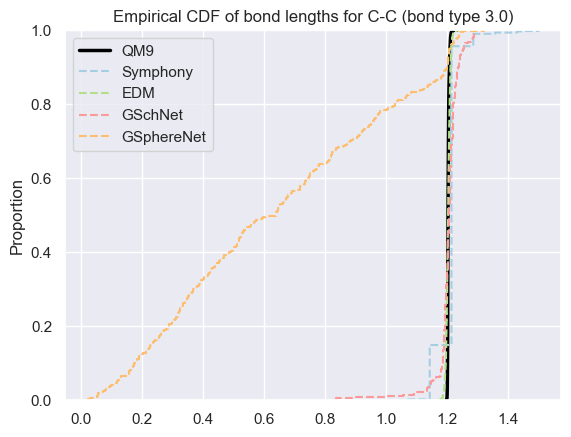

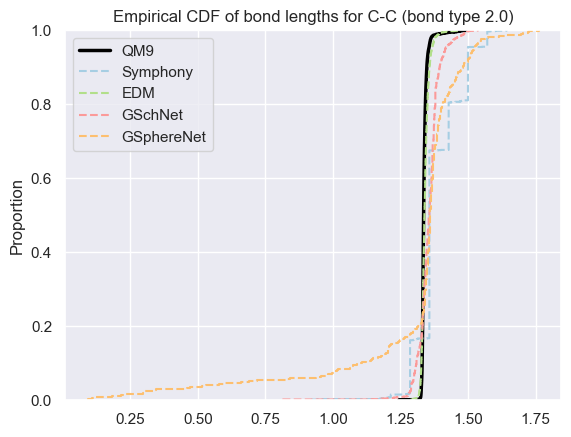

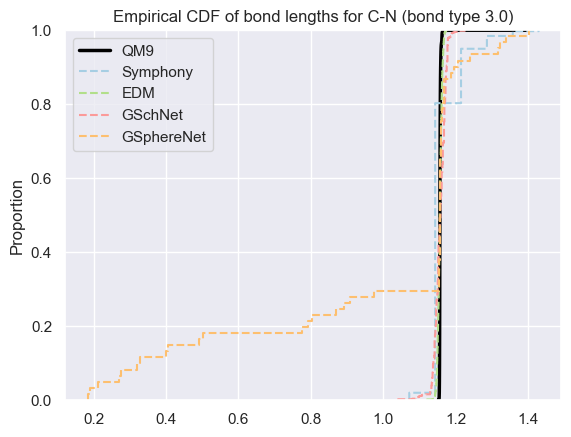

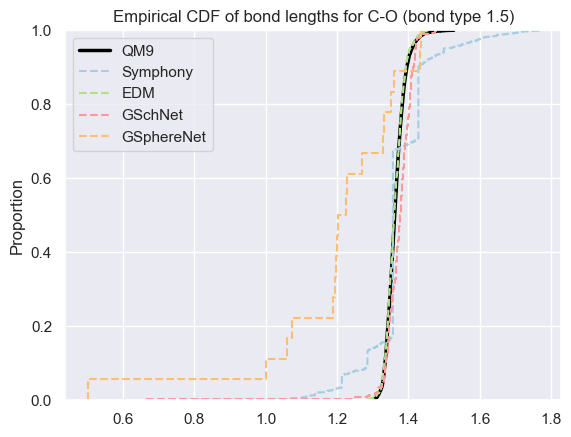

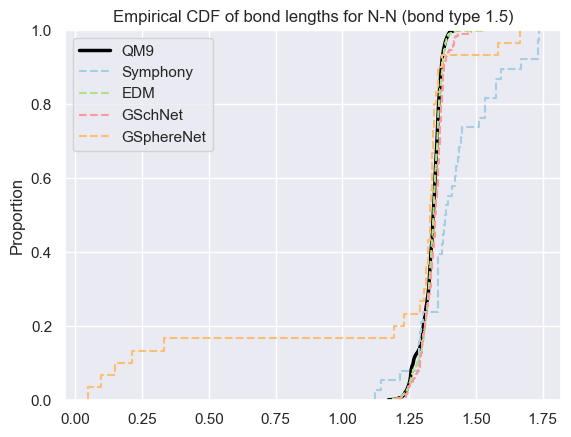

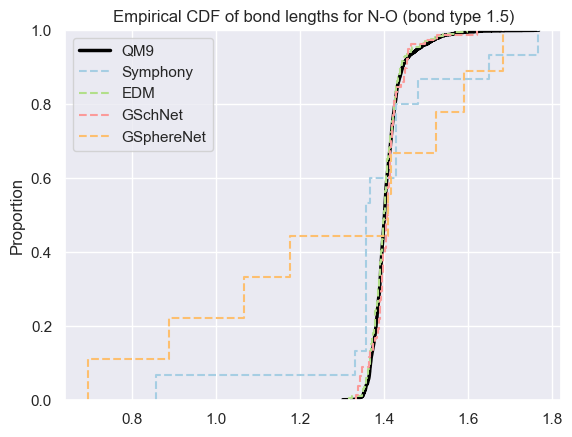

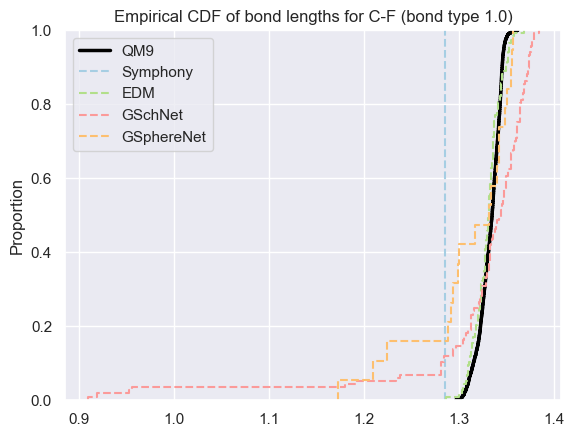

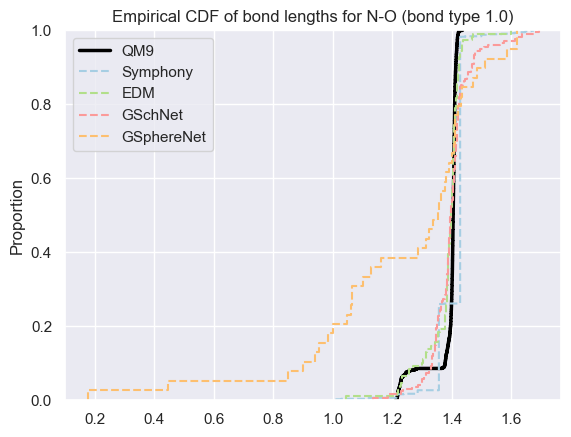

KeyError: ('N', 'O', 2.0)

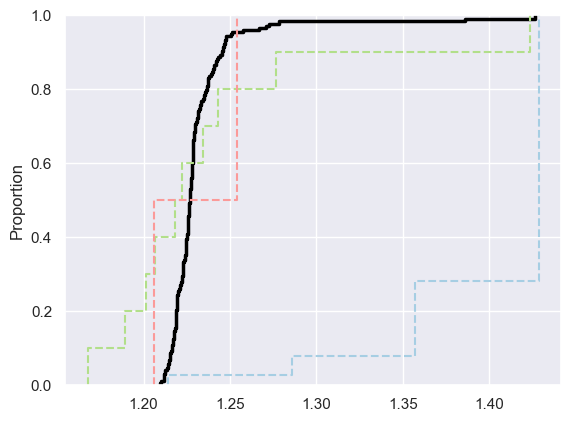

In [30]:
sns.set_theme(style="darkgrid")
for bond_key, _ in sorted_qm9_bond_counts.items():
    num_models = len(bond_dists)
    for model in generated_paths:
        if model == "QM9":
            sns.ecdfplot(bond_dists["QM9"][bond_key], label="QM9", color=model_palette[model], linewidth=2.5)
            continue

        sns.ecdfplot(
            bond_dists[model][bond_key],
            label=model,
            linestyle="--",
            color=model_palette[model],
        )

    atom_type_1, atom_type_2, bond_type = bond_key
    plt.title(
        f"Empirical CDF of bond lengths for {atom_type_1}-{atom_type_2} (bond type {bond_type})"
    )
    plt.legend()
    plt.show()

Validity:

QM9: 99.99
Symphony: 86.98
EDM: 87.72
GSchNet: 80.36
GSphereNet: 26.92


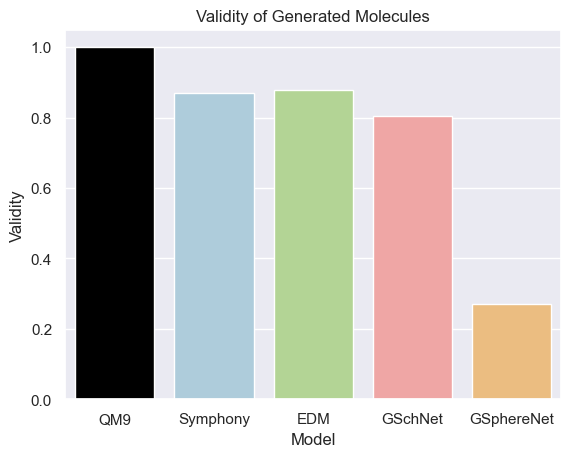

In [ ]:
# Make a dataframe for each model for the validity of the molecules.
validity_df = pd.DataFrame(columns=["model", "validity"])

for model, molecules in valid_molecules.items():
    validity_fraction = compute_validity(all_generated_molecules[model], molecules)
    print(f"{model}: {100 * validity_fraction:0.2f}")
    
    validity_df = pd.concat(
        [
            validity_df,
            pd.DataFrame.from_records(
                {"model": model, "validity": [validity_fraction]}
            ),
        ],
        ignore_index=True,
    )

sns.barplot(data=validity_df, x="model", y="validity", palette=model_palette)
plt.title("Validity of Generated Molecules")
plt.xlabel("Model")
plt.ylabel("Validity")
plt.show();


In [ ]:
formatted_validity_df = validity_df.transpose()
formatted_validity_df.columns = formatted_validity_df.iloc[0]
formatted_validity_df *= 100
formatted_validity_df = formatted_validity_df.drop("model")
formatted_validity_df = formatted_validity_df.astype(float)
formatted_validity_df = formatted_validity_df.round(2)
formatted_validity_df = formatted_validity_df.astype(str)
print(formatted_validity_df.style.to_latex())

\begin{tabular}{llllll}
model & QM9 & Symphony & EDM & GSchNet & GSphereNet \\
validity & 99.99 & 86.98 & 87.72 & 80.36 & 26.92 \\
\end{tabular}



Uniqueness:

QM9: 99.84
Symphony: 83.17
EDM: 99.07
GSchNet: 96.75
GSphereNet: 21.69


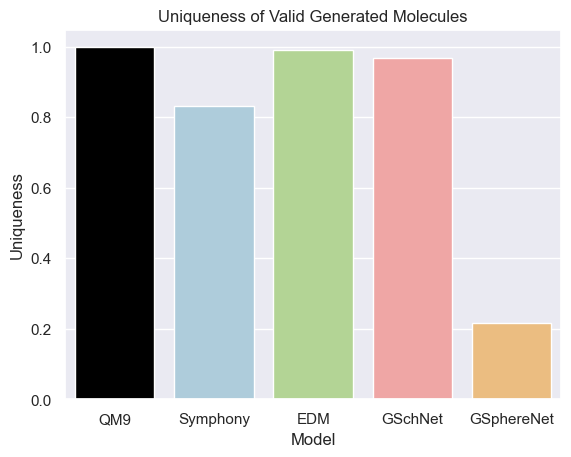

In [ ]:
# Make a dataframe for each model for the uniqueness of the molecules.
uniqueness_df = pd.DataFrame(columns=["model", "uniqueness"])

for model, molecules in valid_molecules.items():
    uniqueness_fraction = compute_uniqueness(molecules)
    print(f"{model}: {100 * uniqueness_fraction:0.2f}")
    
    uniqueness_df = pd.concat(
        [
            uniqueness_df,
            pd.DataFrame.from_records(
                {"model": model, "uniqueness": [uniqueness_fraction]}
            ),
        ],
        ignore_index=True,
    )

sns.barplot(data=uniqueness_df, x="model", y="uniqueness", palette=model_palette)
plt.title("Uniqueness of Valid Generated Molecules")
plt.xlabel("Model")
plt.ylabel("Uniqueness")
plt.show();

In [ ]:
formatted_uniqueness_df = uniqueness_df.transpose()
formatted_uniqueness_df.columns = formatted_uniqueness_df.iloc[0]
formatted_uniqueness_df *= 100
formatted_uniqueness_df = formatted_uniqueness_df.drop("model")
formatted_uniqueness_df = formatted_uniqueness_df.astype(float)
formatted_uniqueness_df = formatted_uniqueness_df.round(2)
formatted_uniqueness_df = formatted_uniqueness_df.astype(str)
print(formatted_uniqueness_df.style.to_latex())

\begin{tabular}{llllll}
model & QM9 & Symphony & EDM & GSchNet & GSphereNet \\
uniqueness & 99.84 & 83.17 & 99.07 & 96.75 & 21.69 \\
\end{tabular}



In [ ]:
print("Symphony:")
for step in [100000, 200000, 500000, 1000000, 2000000, 5000000, "best"]:
    symphony_molecules_dir_step = generated_paths["Symphony"].replace(
        "step=best", f"step={step}"
    )
    validity_fraction = compute_validity(symphony_molecules_dir_step)
    print(f" Step {step}: {100 * validity_fraction:0.2f}")

Posebusters!

In [ ]:
posebuster_results = {
    model: get_posebusters_results(molecules)
    for model, molecules in valid_molecules.items()
    if model != "QM9"
}

In [ ]:
posebuster_results_df = pd.DataFrame(columns=["model", "test", "fraction_passed"])
for model in posebuster_results:
    model_results_df = posebuster_results[model].mean()

    # Add a column for the model.
    posebuster_results_df = pd.concat(
        [
            posebuster_results_df,
            pd.DataFrame.from_records(
                {"model": model, "test": model_results_df.index, "fraction_passed": model_results_df.values}
            ),
        ],
        ignore_index=True,
    )

formatted_df = posebuster_results_df.pivot(index="test", columns="model", values="fraction_passed")[list(posebuster_results.keys())]
# Rename index.
def format_index(index: str) -> str:
    return index.replace("_", " ").title()

formatted_df.index = [
    format_index(index) for index in formatted_df.index
]
formatted_df *= 100
formatted_df = formatted_df.round(2).astype(str)
print(formatted_df.style.to_latex())

\begin{tabular}{lllll}
model & Symphony & EDM & GSchNet & GSphereNet \\
All Atoms Connected & 99.49 & 99.78 & 99.89 & 100.0 \\
Aromatic Ring Flatness & 99.99 & 100.0 & 99.91 & 99.85 \\
Bond Angles & 99.63 & 99.94 & 99.91 & 97.59 \\
Bond Lengths & 97.63 & 100.0 & 99.84 & 72.99 \\
Double Bond Flatness & 98.93 & 98.79 & 97.39 & 95.99 \\
Internal Energy & 97.94 & 94.7 & 94.79 & 36.07 \\
Internal Steric Clash & 96.67 & 99.89 & 99.48 & 98.07 \\
Mol Pred Loaded & 100.0 & 100.0 & 100.0 & 100.0 \\
Sanitization & 100.0 & 100.0 & 100.0 & 100.0 \\
\end{tabular}



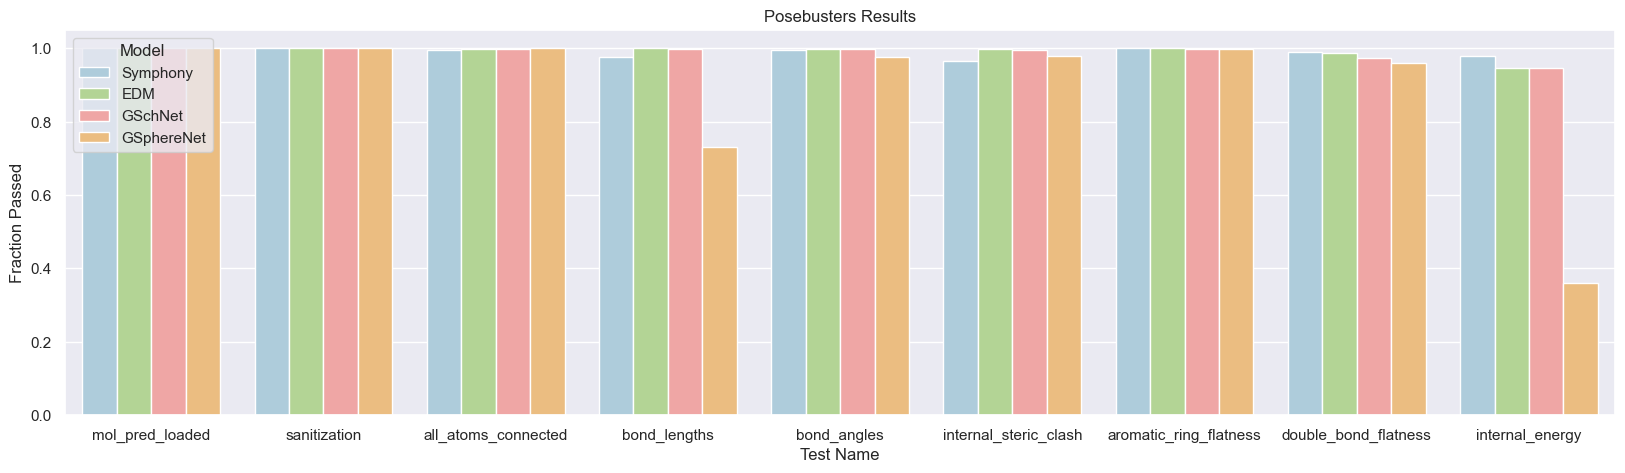

In [ ]:
# Plot each row.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="test", y="fraction_passed", hue="model", data=posebuster_results_df, palette=model_palette, ax=ax)
plt.xlabel("Test Name")
plt.ylabel("Fraction Passed")
plt.legend(title="Model", loc="upper left")
plt.title("Posebusters Results")
plt.show()

In [ ]:
# Print out the best models for each test.
for test in posebuster_results_df["test"].unique():
    print(f"{test}:")
    print(posebuster_results_df[posebuster_results_df["test"] == test].sort_values(by="fraction_passed", ascending=False).head(3))
    print("")

mol_pred_loaded:
       model             test  fraction_passed
0   Symphony  mol_pred_loaded              1.0
9        EDM  mol_pred_loaded              1.0
18   GSchNet  mol_pred_loaded              1.0

sanitization:
       model          test  fraction_passed
1   Symphony  sanitization              1.0
10       EDM  sanitization              1.0
19   GSchNet  sanitization              1.0

all_atoms_connected:
         model                 test  fraction_passed
29  GSphereNet  all_atoms_connected         1.000000
20     GSchNet  all_atoms_connected         0.998880
11         EDM  all_atoms_connected         0.997834

bond_lengths:
       model          test  fraction_passed
12       EDM  bond_lengths         1.000000
21   GSchNet  bond_lengths         0.998382
3   Symphony  bond_lengths         0.976316

bond_angles:
       model         test  fraction_passed
13       EDM  bond_angles         0.999430
22   GSchNet  bond_angles         0.999129
4   Symphony  bond_angles         0.

Some other stuff...

In [ ]:
molecule_dir1 = generated_paths["Symphony"]
molecule_dir2 = generated_paths["Symphony (UFF relaxed)"]
print(compute_validity(molecule_dir1))
print(compute_validity(molecule_dir2))

validity_sum_1 = 0
for molecule_file in os.listdir(molecule_dir1):
    if not molecule_file.endswith(".xyz"):
        continue
    if check_molecule_validity(os.path.join(molecule_dir1, molecule_file)):
        validity_sum_1 += 1
        if not check_molecule_validity(os.path.join(molecule_dir2, molecule_file)):
            print(f"{molecule_file} is valid in {molecule_dir1} but not in {molecule_dir2}")

print("done")
validity_sum_2 = 0
for molecule_file in os.listdir(molecule_dir2):
    if not molecule_file.endswith(".xyz"):
        continue
    # print(molecule_file, check_molecule_validity(os.path.join(molecule_dir2, molecule_file)), check_molecule_validity(os.path.join(molecule_dir1, molecule_file)))
    if check_molecule_validity(os.path.join(molecule_dir2, molecule_file)):
        validity_sum_2 += 1
        if not check_molecule_validity(os.path.join(molecule_dir1, molecule_file)):
            print(f"{molecule_file} is valid in {molecule_dir2} but not in {molecule_dir1}")

validity_sum_1, validity_sum_2

Seeing invalid molecules in QM9:

In [ ]:
import ase
import ase.io
import ase.visualize

invalid_mols = []
for molecules_file in os.listdir(qm9_molecules_dir):
    if not molecules_file.endswith(".xyz"):
        continue

    
    molecules_file = os.path.join(qm9_molecules_dir, molecules_file)
    if check_molecule_validity(molecules_file):
        continue

    print(f"{molecules_file} is invalid")
    mol = xyz_to_rdkit_molecule(molecules_file)

    mol = ase.Atoms(
        symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
        positions=mol.GetConformer().GetPositions(),
    )
    invalid_mols.append(mol)
        

In [ ]:
import nglview as nv
v = nv.show_asetraj(invalid_mols, gui=True)
v.add_representation("ball+stick")
v

In [ ]:
suppl = Chem.SDMolSupplier('/Users/ameyad/Documents/spherical-harmonic-net/symphony/data/qm9_data/gdb9.sdf', sanitize=False, removeHs=False)
invalid_sdf_mols = []
for mol in suppl:
    if mol is None:
        continue

    # Try to sanitize molecule.
    # If we could not sanitize, then save the molecules as an ase.Atoms object.
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        mol = ase.Atoms(
            symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
            positions=mol.GetConformer().GetPositions(),
        )
        invalid_sdf_mols.append(mol)
        continue

In [ ]:
v = nv.show_asetraj(invalid_sdf_mols[:50], gui=True)
v.add_representation("ball+stick")
v

# OpenBabel